IMPORTAMOS LAS LIBRERÍAS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

FUNCIONES

In [2]:
def plot_feature(df, col_name, isContinuous, target):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

def dame_variables_categoricas(dataset=None):
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []

    for i in dataset.columns:

        if dataset[i].dtype == object:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)
        
        if dataset[i].dtype == int:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 10:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other

def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('TARGET',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('TARGET',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))



Con estas funciones estamos tratando de hacer varias cosas:

1. plot_feature: va a generar gráficos específicos para cada variable donde hará un histograma para analizar la distribución y boxplot para ver cómo se distribuyen los valores en base a la variable TARGET para las variables contínuas. Para las variables categóricas va a crear dos gráficos de barras, para la frecuencia de la variable y otro con las proporciones por categoría de TARGET

2. dame_variables_categoricas: trata de identificar variables categóricas y separarlas en dos: aquellas variables que tienen menos de 100 valores únicos (estas pueden ser muy útiles en nuestro análisis), y aquellas que tienen más de 100 registros únicos

3. get_corr_matrix: para visualizar la matriz de correlación para variables numéricas 

4. get_deviation_of_mean_perc: crea un rango de valores alrededor de la media con la desviación típica y encuentra la proporción de valores dentro y fuera de este intervalo, para así poder ver los valores atípicos y la relación que tienen con la variable TARGET.

5. get_percent_values_target: es para analizar la relación que hay entre valores nulos y la variable TARGET. 

6. cramers_v: para ver la relación entre variables categóricas usando la estadística de Cramer

LECTURA DE DATOS DEL PREPROCESADO INICIAL

In [6]:
path_folder = "../data/"
pd_loan = pd.read_csv(path_folder + "application_data.csv", low_memory = False).set_index('SK_ID_CURR')

pd_loan.head()


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
SK_ID_CURR                                                                  
100002          24700.5         351000.0   Unaccompanied          Working   
100003          35698.5        1129500.0          Family    State servant   
100004           6750.0         135000.0   Unaccompanied          Working   
100006          29686.5         297000.0   Unaccompanied          Working   
100007          21865.5         513000.0   Unaccompanied          Working   

                      NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
SK_ID_CURR                                                        
100002      Secondary / secondary special  Single / not married   
100003                   Higher education               Married   
100004      Secondary / secondary special  Single / not married   
100006      Secondary / secondary special        Civil marriage   
100007      Secondary / secondary special  Single / not married   

            NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                              
100002      House / apartment                    0.018801       -9461   
100003      House / apartment                    0.003541      -16765   
100004      House / apartment                    0.010032      -19046   
100006      House / apartment                    0.008019      -19005   
100007      House / apartment                    0.028663      -19932   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100002               -637            -3648.0            -2120          NaN   
100003              -1188            -1186.0             -291          NaN   
100004               -225            -4260.0            -2531         26.0   
100006              -3039            -9833.0            -2437          NaN   
100007              -3038            -4311.0            -3458          NaN   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
100002               1               1                0                 1   
100003               1               1                0                 1   
100004               1               1                1                 1   
100006               1               1                0                 1   
100007               1               1                0                 1   

            FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
SK_ID_CURR                                                            
100002               1           0        Laborers              1.0   
100003               1           0      Core staff              2.0   
100004               1           0        Laborers              1.0   
100006               0           0        Laborers              2.

Utilizamos el ID de cliente como el índice del Dataframe. A continuación, identificamos las variables continuas y categóricas dentro del conjunto de datos

In [4]:
def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función recibe un DataFrame una lista de las variables categóricas 
        (con pocos valores únicos).
        
    - Inputs: 
        - dataset (DataFrame): DataFrame que contiene los datos de entrada.
        
    - Return:
        - lista_variables_categoricas (list): Lista con los nombres de las variables 
          categóricas en el DataFrame.
        - other (list): Lista con los nombres de las variables que no cumplen los criterios 
          para ser categóricas.
        - 1: Indica que la ejecución es incorrecta debido a la falta del 
          argumento 'dataset'.
    '''
    # Verificar que el DataFrame de entrada no sea nulo
    if dataset is None:
        print(u'\nError: Falta el argumento dataset en la función')
        return 1 
    
    lista_variables_categoricas = []  
    other = []  

    # Recorrer las columnas del DataFrame
    for i in dataset.columns:
        
        # Si la columna es de tipo objeto (posiblemente categórica)
        if dataset[i].dtype == object:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)  
            else:
                other.append(i)  
                
        # Si la columna es de tipo entero                
        if dataset[i].dtype == int:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 10:
                lista_variables_categoricas.append(i)  
            else:
                other.append(i) 

    return lista_variables_categoricas, other

In [7]:
import numpy as np
#Aquí identificamos las variables categóricas
list_var_cat, other = dame_variables_categoricas(dataset=pd_loan)
pd_loan[list_var_cat] = pd_loan[list_var_cat].astype("category")

#Seleccionamos las columnas que tienen datos numéricos continuos
list_var_continuous = list(pd_loan.select_dtypes('float').columns)
pd_loan[list_var_continuous] = pd_loan[list_var_continuous].astype(float)
pd_loan.dtypes

pd_loan.dtypes.to_dict()

{'TARGET': dtype('int64'),
 'NAME_CONTRACT_TYPE': CategoricalDtype(categories=['Cash loans', 'Revolving loans'], ordered=False, categories_dtype=object),
 'CODE_GENDER': CategoricalDtype(categories=['F', 'M', 'XNA'], ordered=False, categories_dtype=object),
 'FLAG_OWN_CAR': CategoricalDtype(categories=['N', 'Y'], ordered=False, categories_dtype=object),
 'FLAG_OWN_REALTY': CategoricalDtype(categories=['N', 'Y'], ordered=False, categories_dtype=object),
 'CNT_CHILDREN': dtype('int64'),
 'AMT_INCOME_TOTAL': dtype('float64'),
 'AMT_CREDIT': dtype('float64'),
 'AMT_ANNUITY': dtype('float64'),
 'AMT_GOODS_PRICE': dtype('float64'),
 'NAME_TYPE_SUITE': CategoricalDtype(categories=['Children', 'Family', 'Group of people', 'Other_A',
                   'Other_B', 'Spouse, partner', 'Unaccompanied'],
 , ordered=False, categories_dtype=object),
 'NAME_INCOME_TYPE': CategoricalDtype(categories=['Businessman', 'Commercial associate', 'Maternity leave',
                   'Pensioner', 'State servant

Algunas variables clasificadas inicialmente como enteras son de carácter booleano, lo que las hace categóricas. 

SEPARACIÓN EN TRAIN Y TEST ESTRATIFICADO


In [12]:
pd_plot_target = pd_loan['TARGET'].value_counts(normalize=False).reset_index()

pd_plot_target.columns = ['TARGET', 'count']

fig = px.bar(pd_plot_target, x='TARGET', y='count')
fig.update_xaxes(tickvals=[0, 1])
fig.show()

Se observa que el muestreo está desbalanceado, ya que la mayoría de los clientes no tienen dificultades para pagar el préstamo. (0 = pagado y 1 = no pagado)
El 20% de los datos se asignan al conjunto de prueba y el 80% al conjunto de entrenamiento para entrenar el modelo.

In [13]:
from sklearn.model_selection import train_test_split
X_pd_loan, X_pd_loan_test, y_pd_loan, y_pd_loan_test = train_test_split(pd_loan.drop('TARGET',axis=1), 
                                                                     pd_loan['TARGET'], 
                                                                     stratify=pd_loan['TARGET'], 
                                                                     test_size=0.2)
pd_loan_train = pd.concat([X_pd_loan, y_pd_loan],axis=1)
pd_loan_test = pd.concat([X_pd_loan_test, y_pd_loan_test],axis=1)

In [14]:
print('== Train\n', pd_loan_train['TARGET'].value_counts(normalize=True))
print('== Test\n', pd_loan_test['TARGET'].value_counts(normalize=True))

== Train
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
== Test
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


Como observamos en el resultado, cada categoría de la variable target tiene la misma proporción tanto en el train como en el test, lo que permite que el modelo tenga
ejemplos de todas las clases en ambos conjuntos y asi evita que el modelo tenga un sesgo hacia una clase en particular.

VISUALIZACIÓN DESCRIPTIVA DE LOS DATOS

Aquí vamos a realizar la suma de la cantidad de valores nulos que hay por filas y por columnas. 

pd_null_columnas contiene el número de valores nulos por columna y el % de valores nulos respecto al total de filas.
pd_null_filas contiene el número de valores nulos por filas y el porcentaje de valores nulos respecto al total de columnas, y la relación con la variable TARGET

In [15]:
#Veo el número de valores nulos por filas y columnas
pd_series_null_columns = pd_loan_train.isnull().sum().sort_values(ascending=False)
pd_series_null_rows = pd_loan_train.isnull().sum(axis=1).sort_values(ascending=False)
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  
pd_null_filas['TARGET'] = pd_loan['TARGET'].copy()
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/pd_loan_train.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/pd_loan_train.shape[1]

(121,) (246008,)


In [16]:
pd_null_columnas.head()

nulos_columnas  porcentaje_columnas
COMMONAREA_MODE                   171913             0.698811
COMMONAREA_MEDI                   171913             0.698811
COMMONAREA_AVG                    171913             0.698811
NONLIVINGAPARTMENTS_MEDI          170833             0.694421
NONLIVINGAPARTMENTS_MODE          170833             0.694421

In [17]:
pd_null_filas.head()

nulos_filas  TARGET  porcentaje_filas
SK_ID_CURR                                       
274127               61       0          0.504132
255145               61       0          0.504132
412312               61       0          0.504132
329262               61       0          0.504132
180861               61       0          0.504132

Hemos hecho un conteo y porcentaje de valores nulos por filas y columnas para identificar qué columnas y filas tienen más valores nulos por si hubiese que tomar la decisión de imputarlas o eliminarlas

In [18]:
list_var_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



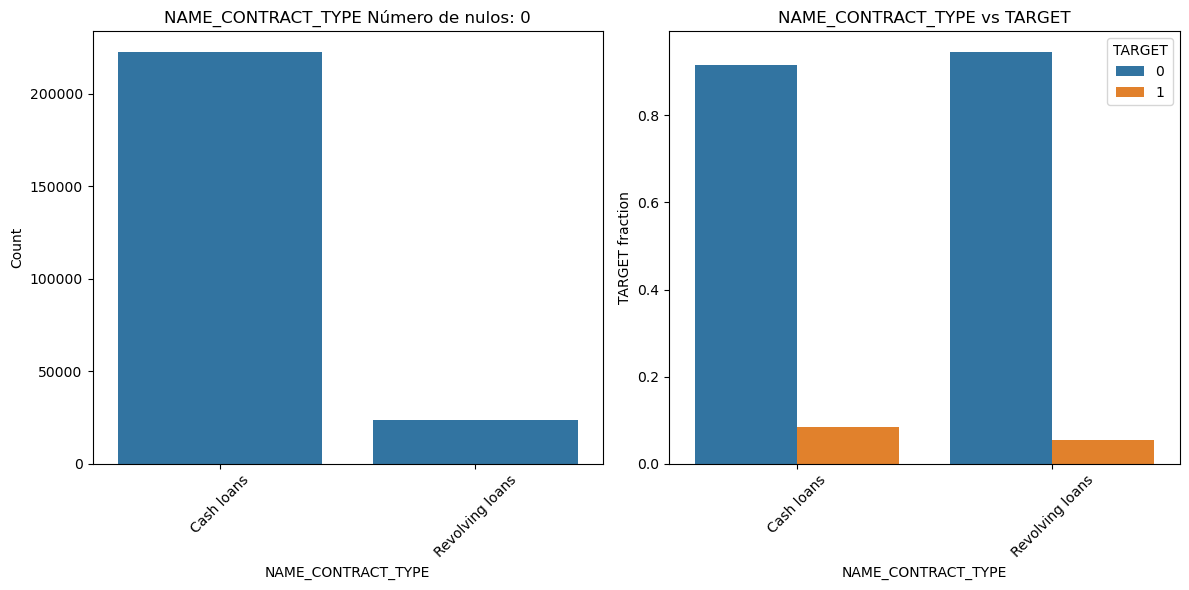

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



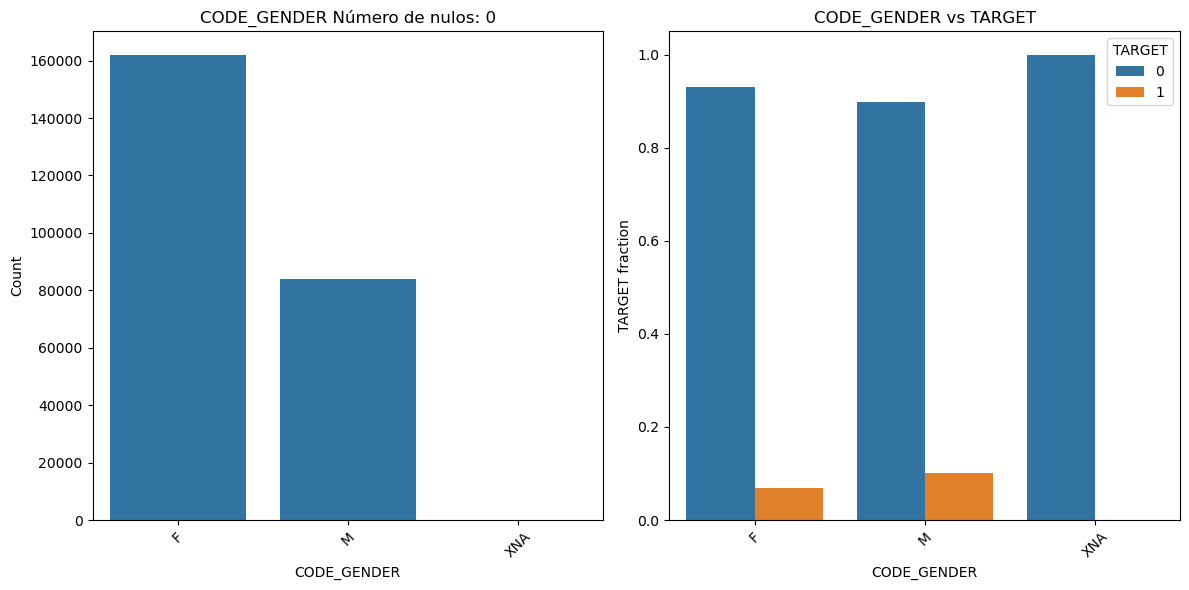

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



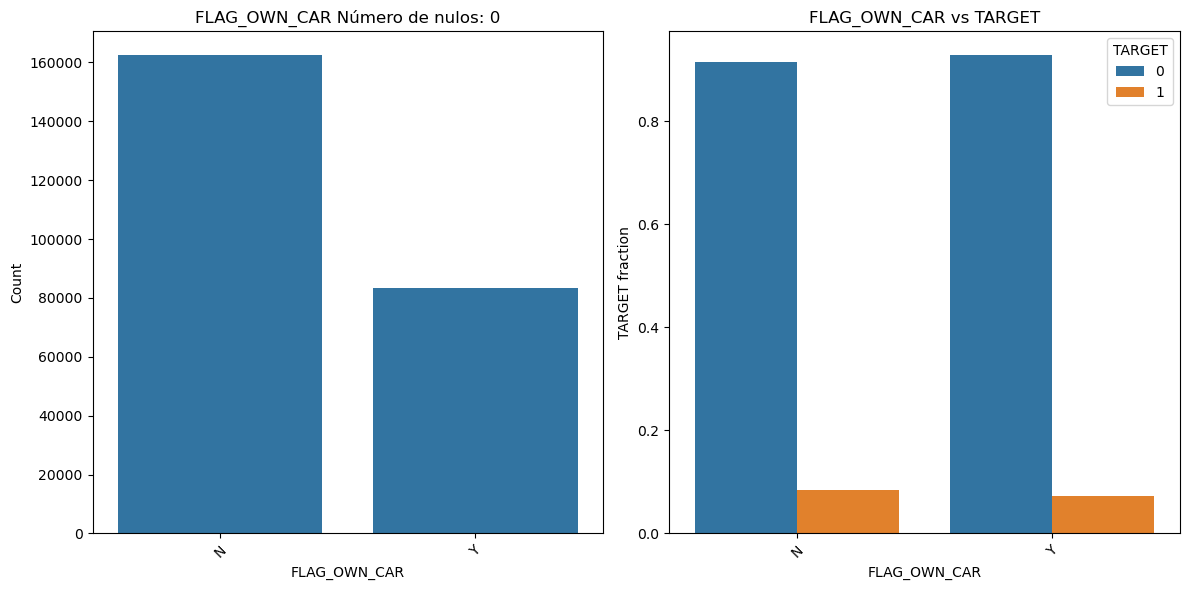

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



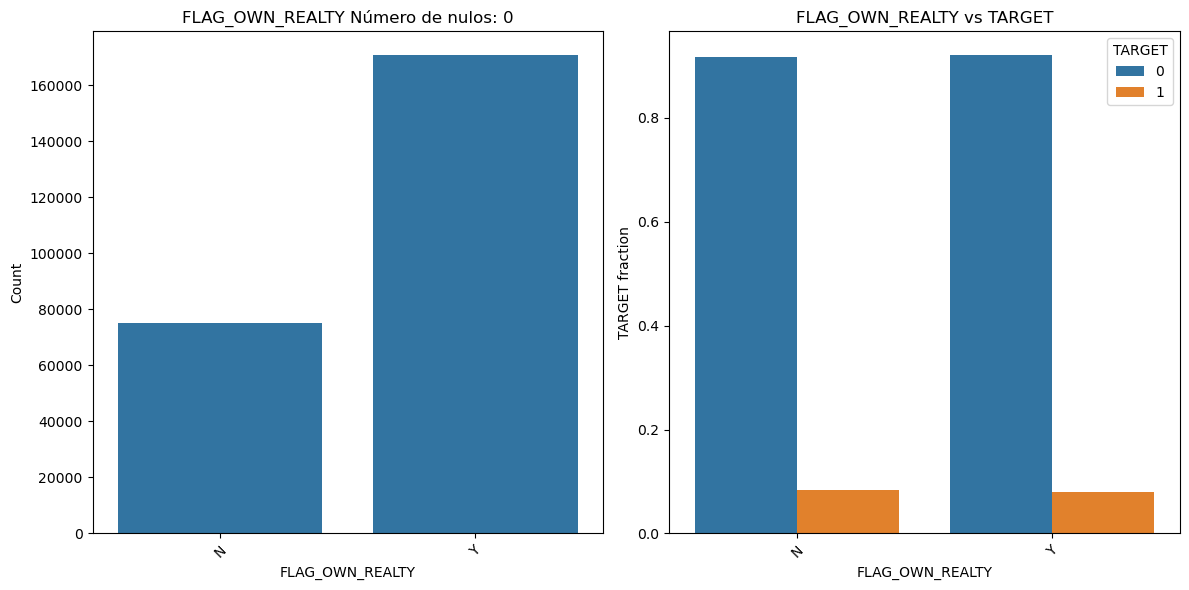

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



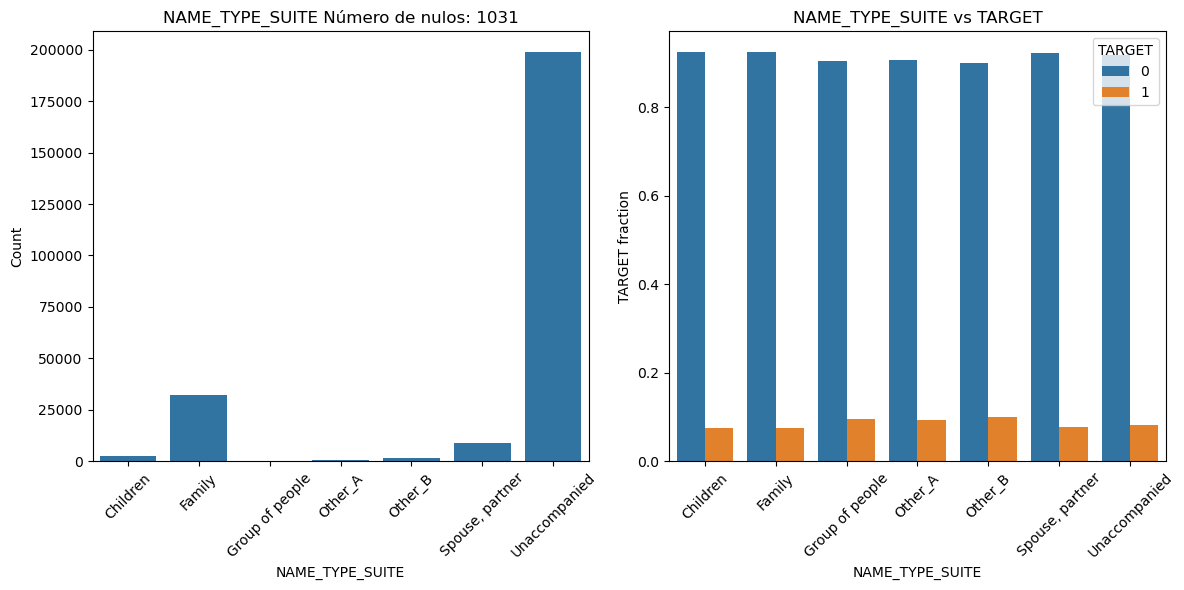

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



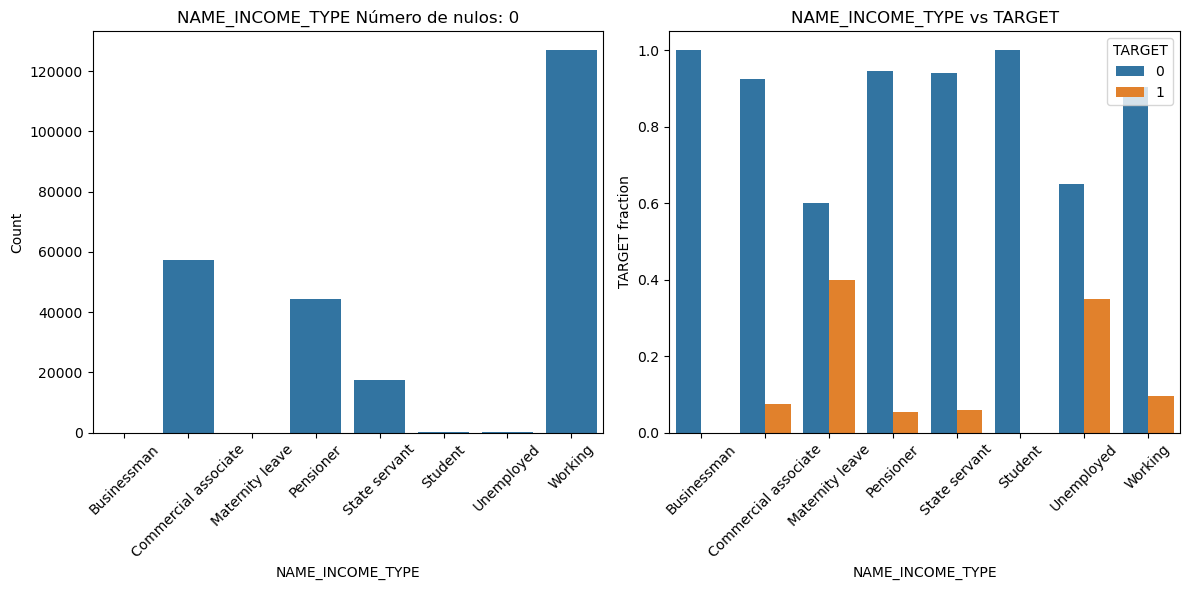

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



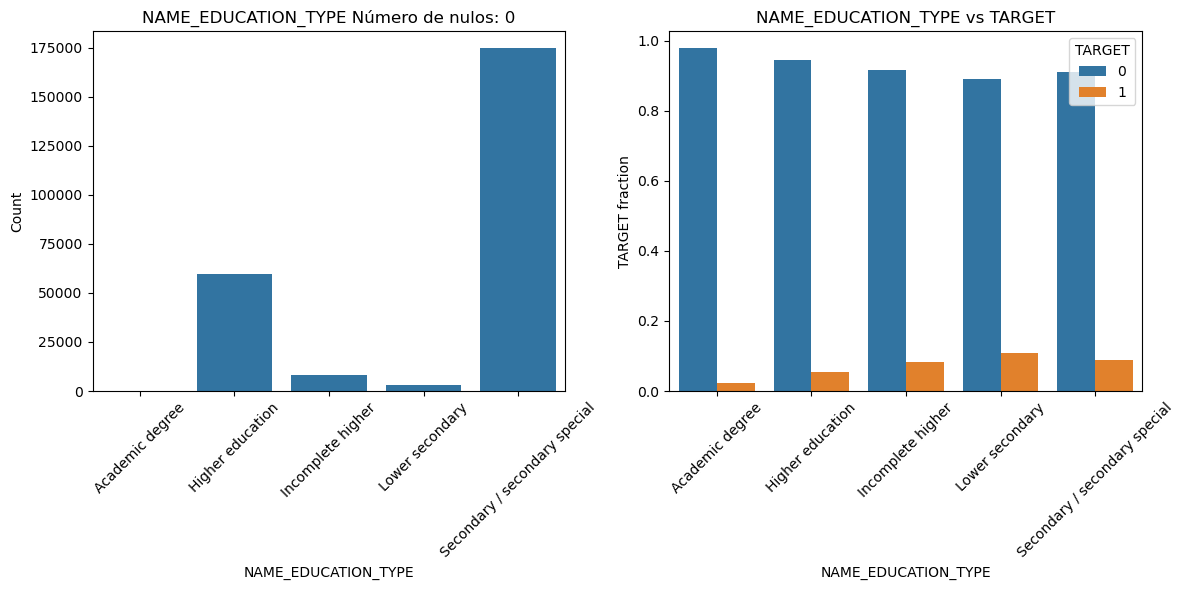

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



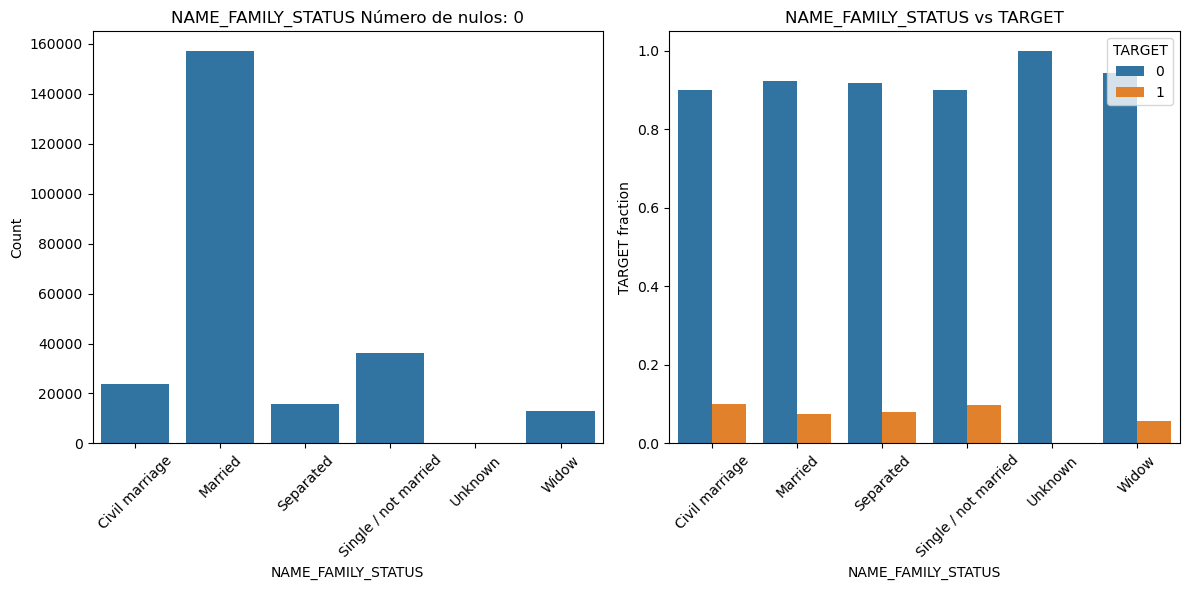

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



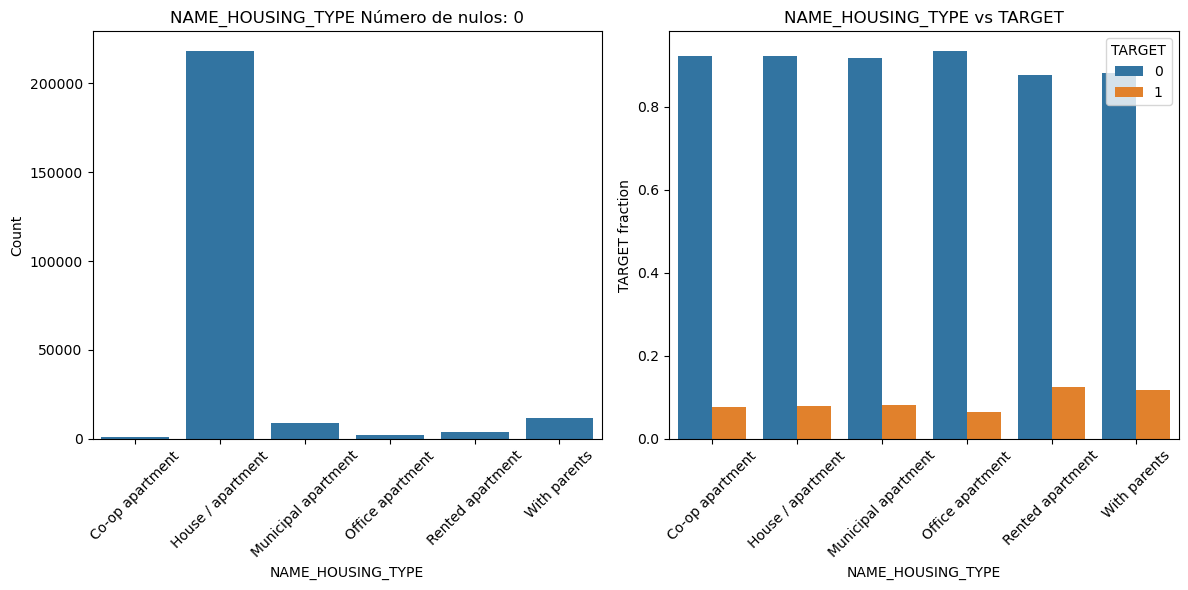

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



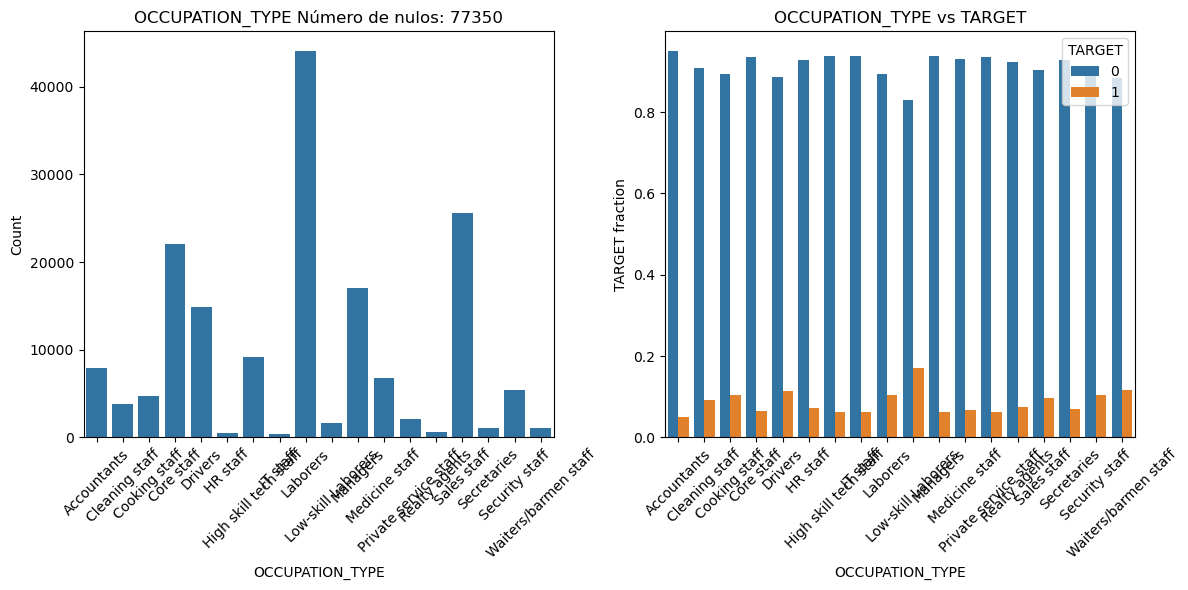

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



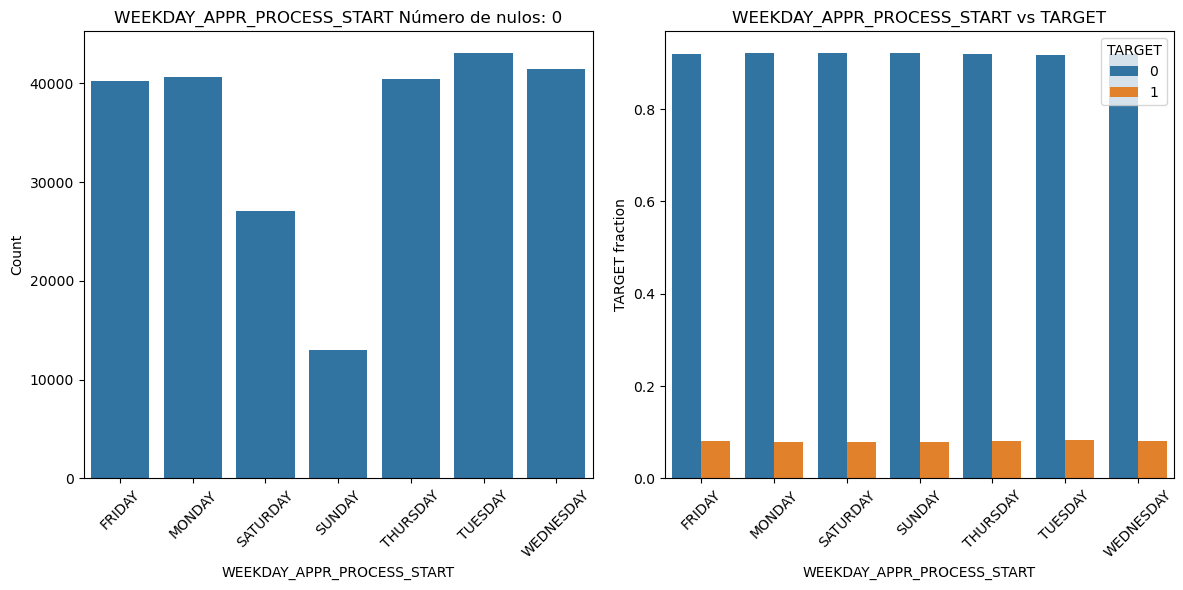

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



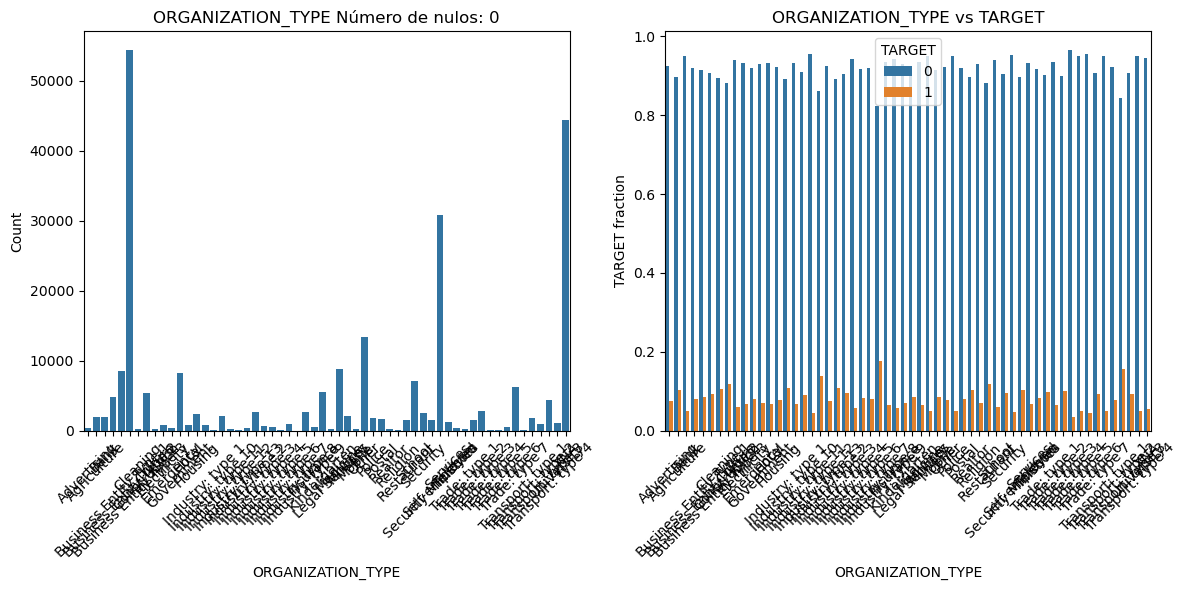

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



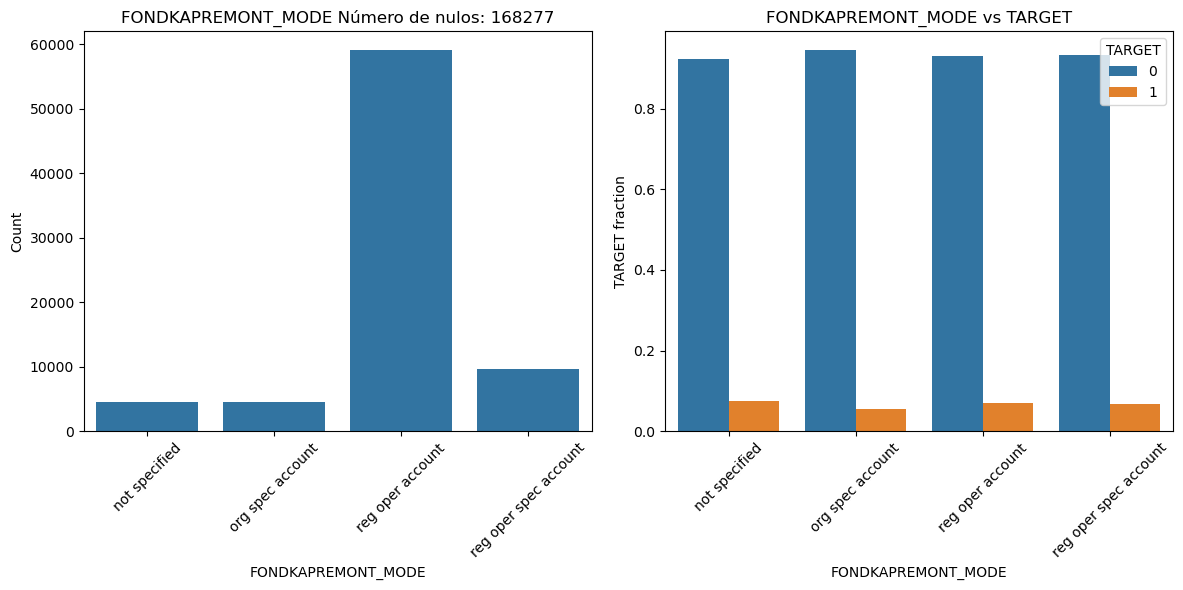

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



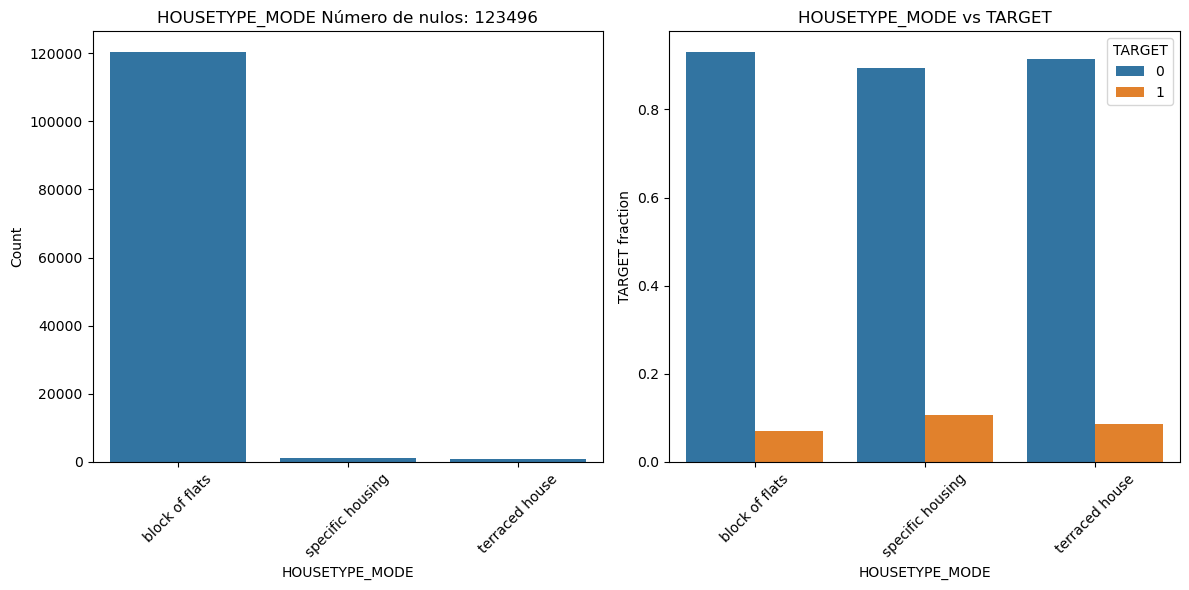

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



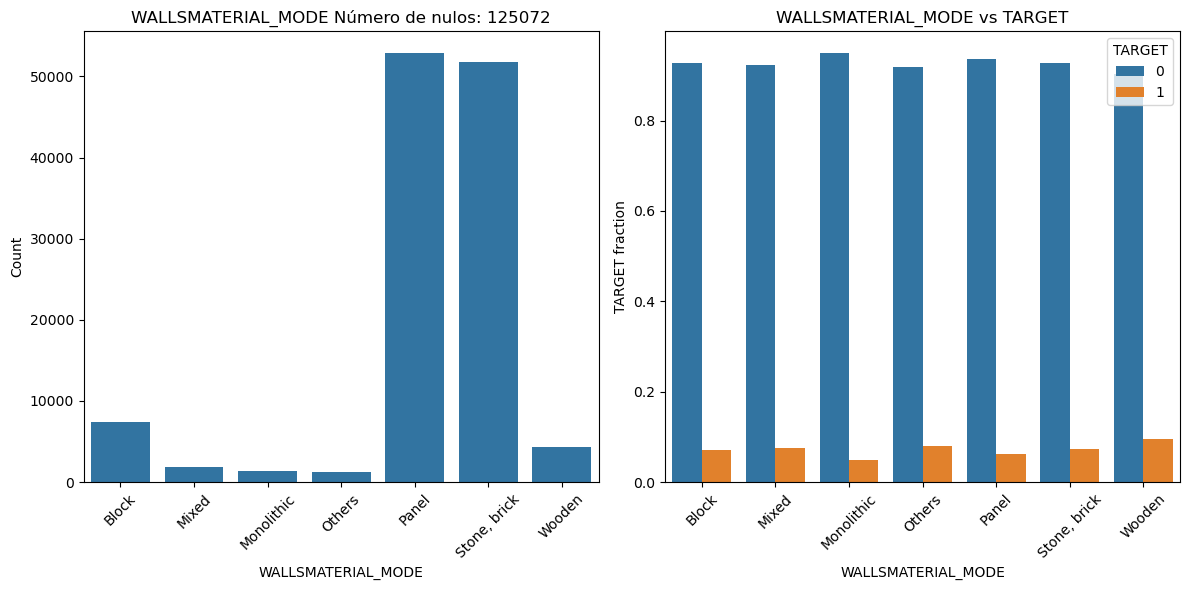

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Guille\AppData\Local\Temp\ipykernel_15832\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



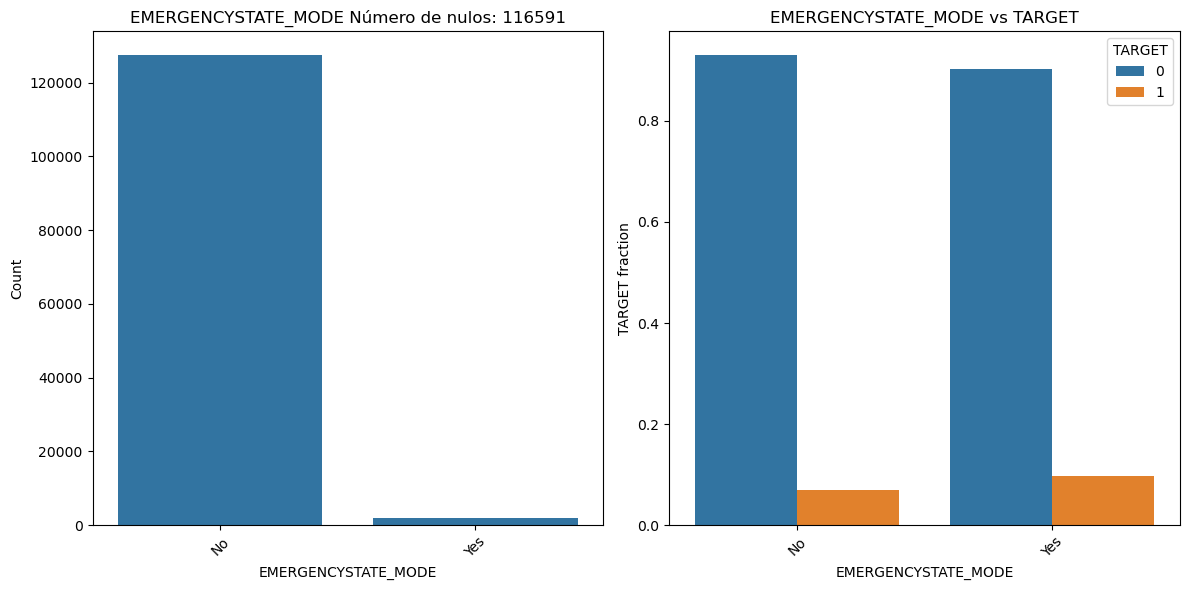

In [19]:
#Realizamos un bucle para las variables categóricas

for variable in list_var_cat:
    if variable != "TARGET":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Gráfico de conteo
        sns.countplot(data=pd_loan_train, x=variable, ax=axes[0])
        axes[0].set_title(f'{variable} Número de nulos: {pd_loan_train[variable].isna().sum()}')
        axes[0].set_ylabel('Count')

        # Rotar etiquetas del eje X
        axes[0].tick_params(axis='x', rotation=45)

        # Para cada categoría: gráfico de fracciones
        pd_loan_df = pd_loan_train.groupby([variable, 'TARGET']).size().reset_index(name='count')
        pd_loan_df['fraction'] = pd_loan_df['count'] / pd_loan_df.groupby(variable)['count'].transform('sum')

        sns.barplot(data=pd_loan_df, x=variable, y='fraction', hue='TARGET', ax=axes[1])
        axes[1].set_title(f'{variable} vs TARGET')
        axes[1].set_ylabel('TARGET fraction')

        # Rotar etiquetas del eje X
        axes[1].tick_params(axis='x', rotation=45)

        # Ajustar diseño
        plt.tight_layout()
        plt.show()

A partir de estos gráficos, podemos ver a la izquierda el número de valores nulos para cada categoría de las variables, y en el de la derecha, cómo se distribuye una variable en función de la variable TARGET. Por lo general, vemos que los datos están bastante desbalanceados, pues hay muchas variables que no vemos que tengan un impacto fuerte en el impago del préstamo. A continuación, vamos a comentar algunas variables que puedan ser significativas en el impago del préstamo.

NAME_INCOME_TYPE (Situación laboral del solicitante)
En el gráfico de la izquierda vemos que la mayoría de los datos se asocian con 'Working', es decir, personas que tienen un empleo. Otras categorías presentan también una parte de los datos, como 'Pensioner' o 'Commercial Associate'. Otras categorías como 'Student' o 'Unemployed' presentan muy poca distribución de los datos, o ninguna. En el gráfico de la derecha, que muestra la fracción de incumplimiento para cada categoría, vemos que las personas desempleadas o las que están de baja por maternidad, tienen un porcentaje alto de incumplimiento. Los desempleados parece lógico, pues se asocia con la falta de un trabajo estable. Otras categorías como los pensionistas o los trabajadores presentan un grado bajo de incumplimiento, pues están asociados con un salario o pensión.

NAME_EDUCATION_TYPE(Nivel de educación)
En el gráfico de la izquierda vemos que los datos se distribuyen sobre todo en clientes que tienen 'Secondary/Secondary Special', seguidos de 'Higher Education'. 'Academid degree' o 'Lower Secundary' son menos comunes.En el gráfico de la derecha se muestra las fracciones de incumplimiento para cada nivel educativo. Como vemos, secundaria, secundaria especial o secundaria baja son los niveles que más probabilidad de incumplimiento tienen, algo que puede estar relacionado por el tipo de empleo que estos clientes tienen, asociado con la baja formación académica recibida. Los clientes con un grado o educación superior presentan menor riesgo de incumplimiento, algo que también puede estar relacionado por el caso contrario al anterior.Podemos concluir que el nivel educativo influye en la capacidad de incumplimiento del solicitante.

NAME_HOUSING_TYPE(Tipo de vivienda)
En el gráfico de la izquierda vemos que la mayoría de los datos se asocian con clientes que vivene un apartameto o casa, que por otra parte es lo más normal. Otras categorías presentan una distribución de los datos mucho menor, como 'Municipal Apartment', 'With Parents' o 'Rented Apartment'. En cuanto a su relación con TARGET, vemos que la fracción de incumplimineto es algo mayor para aquellos solicitantes que viven con los padres o de alquiler. Esto puede estar relacionado con un menor grado de cumplimineto, pues los que viven con sus padres es posible que no tengan una ocupación, aunque también pueden ser aún jóvenes para independizarse. Aun así, no parece una variable muy significativa en cuanto al grado de incumplimiento del préstamo.

OCCUPATYON_TYPE (Tipo de trabajo)
Al observar la variable, vemos que presenta una buena cantidad de nulos que podríamos imputar para mejorar el análisis. En el gráfico de la izquierda, vemos que la mayoría de los solicitantes pertenecen a 'Laborers'(en mayor proporción), 'Core Staff' y 'Sales Staff'. Como vemos en el gráfico de la derecha, los trabajadores dedicados a actividades manuales o físicas como la construcción, fabricación, agaricultura, así como aquellos con una baja especialización, como por ejemplo, ayudante de obra, presentan mayor incumplimineto de devolver el préstamo. Otros gremios, como los conductores o los vigilantes de seguridad presentan un grado de incumplimiento menor, aunque mayor que el resto. Esto puede estar debido a la formación educativa, ya que estos trabajos no requieren de una cualificación para dedicarse a ellos. Podemos concluir que el tipo de ocupación puede influir en el grado de incumplimiento del préstamo.

CODE_GENDER(Género)
Como vemos en el gráfico de la izquierda, hay mayor proporción de clientes femeninos que masculinos.En el gráfico de la derecha no parece haber una diferencia extremadamente significativa entre el grado de incumplimineto de hombres y mujeres, aunque si nos fijamos el grado de incumplimiento mayor es ligeramente masculino. Esto puede deberse a muchas razones como el tipo de trabajo, mentalidad o tipo de educación, entre otras. En conclusión, esta variable tiene una relación moderada con la probabilidad de incumplkimiento, siendo importante considerar cómoa actúa con otras variables.

NAME_CONTRACT_TYPE (Tipo de contrato)
En el gráfico de la izquierda vemos que la mayoría de los préstamos pertenecen a 'Cash Loans', mientras que los 'Revolving Loans' tienen una proproción mucho menor. Con respecto a la variable TARGET, vemos que no hay una gran diferencia en la probabilidad de incumplimiento entre ambos préstamos, pero sí que es verdad que los 'Cash Loans' tienen una probabilidad mayor, cosa que tiene sentido al ser mucho más comunes en el día a día.

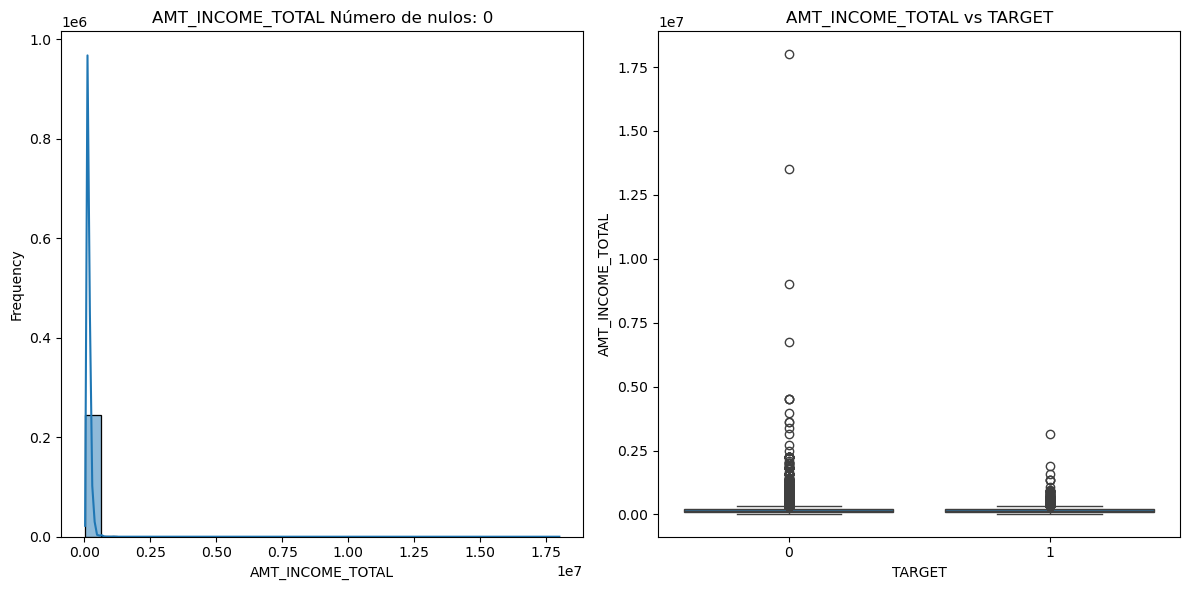

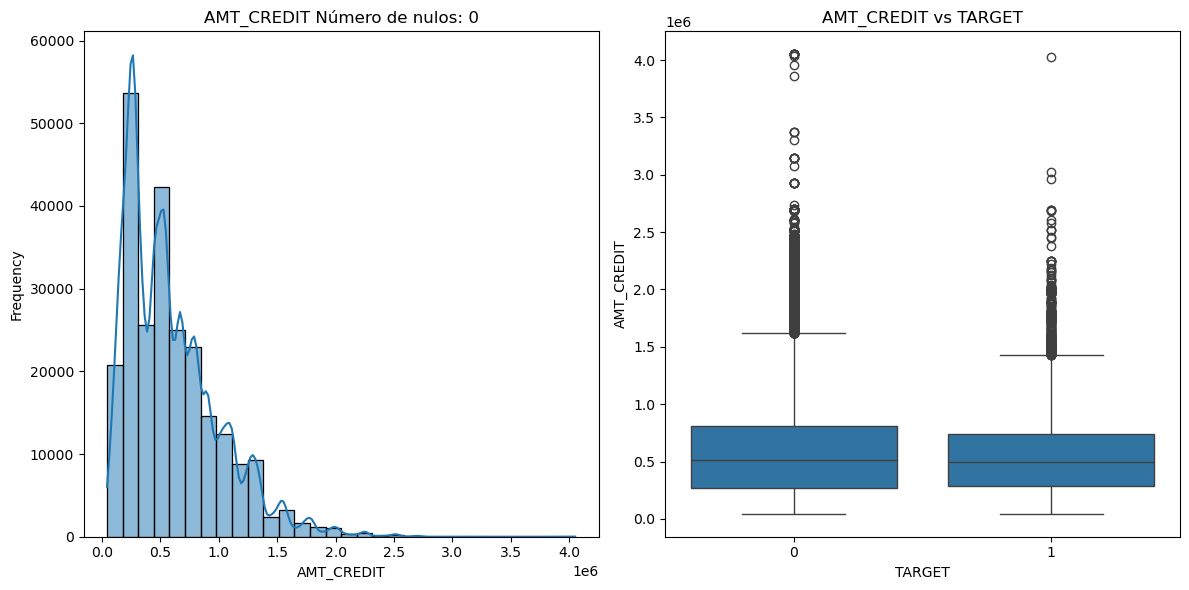

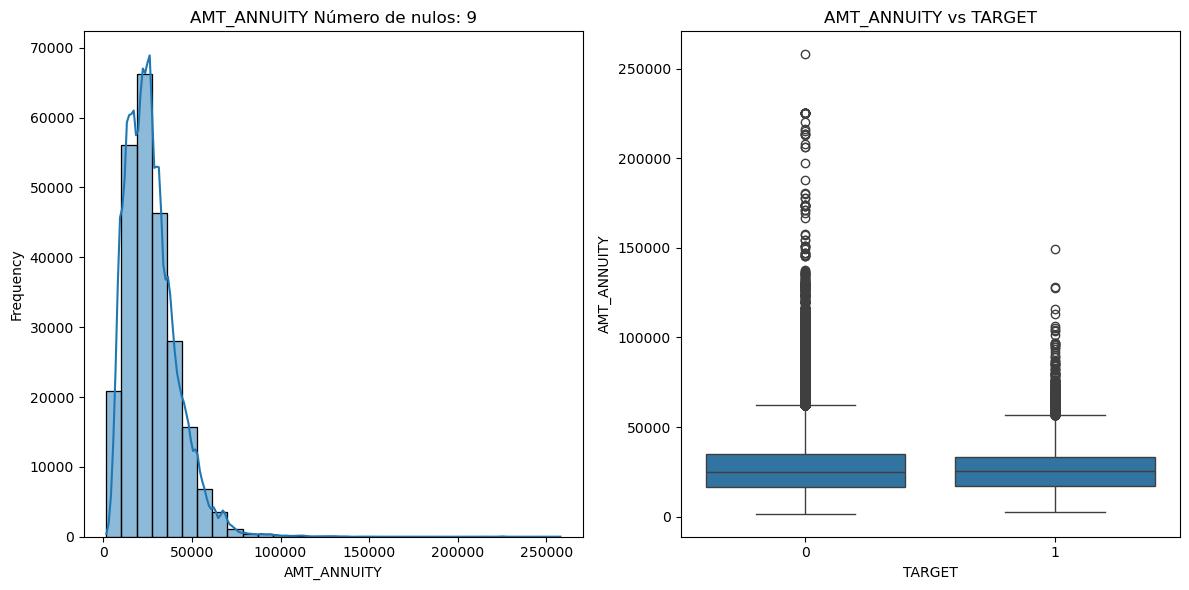

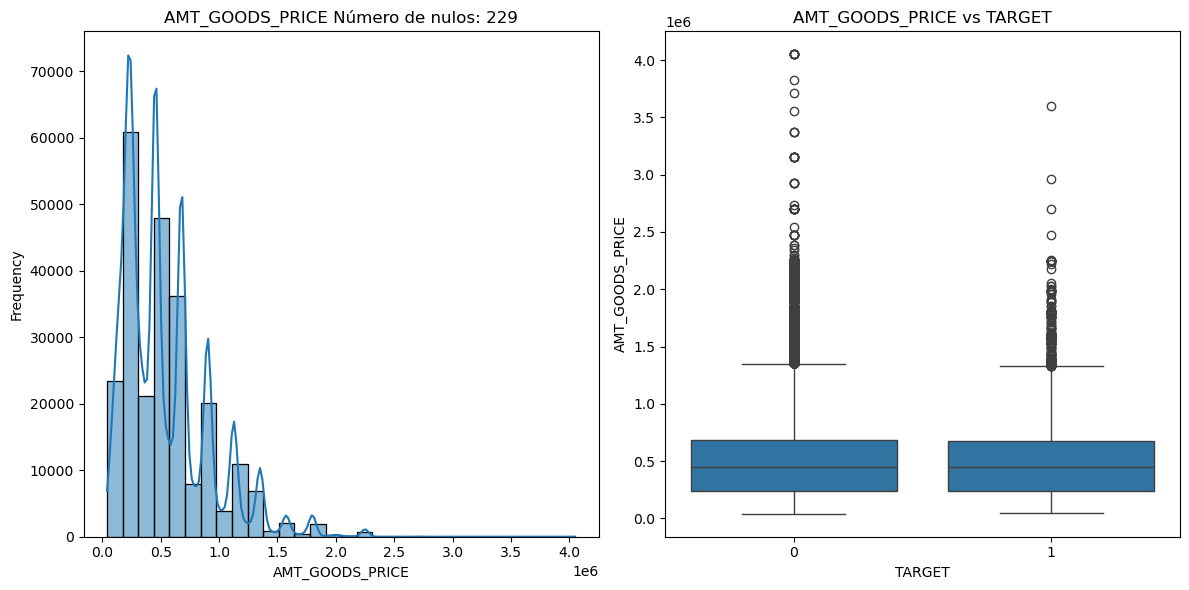

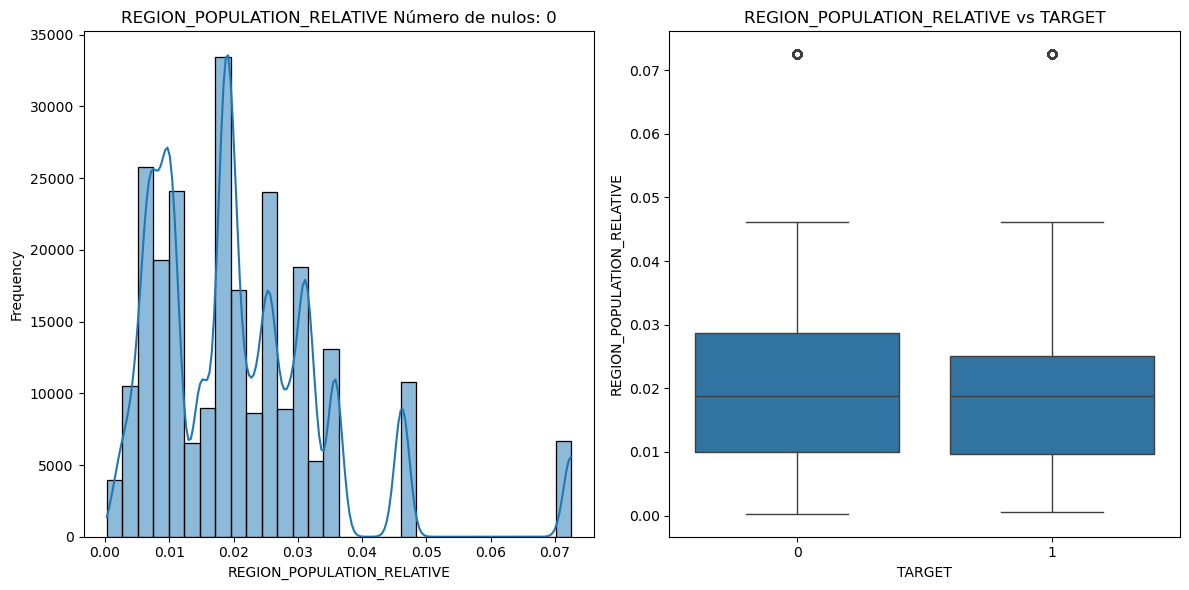

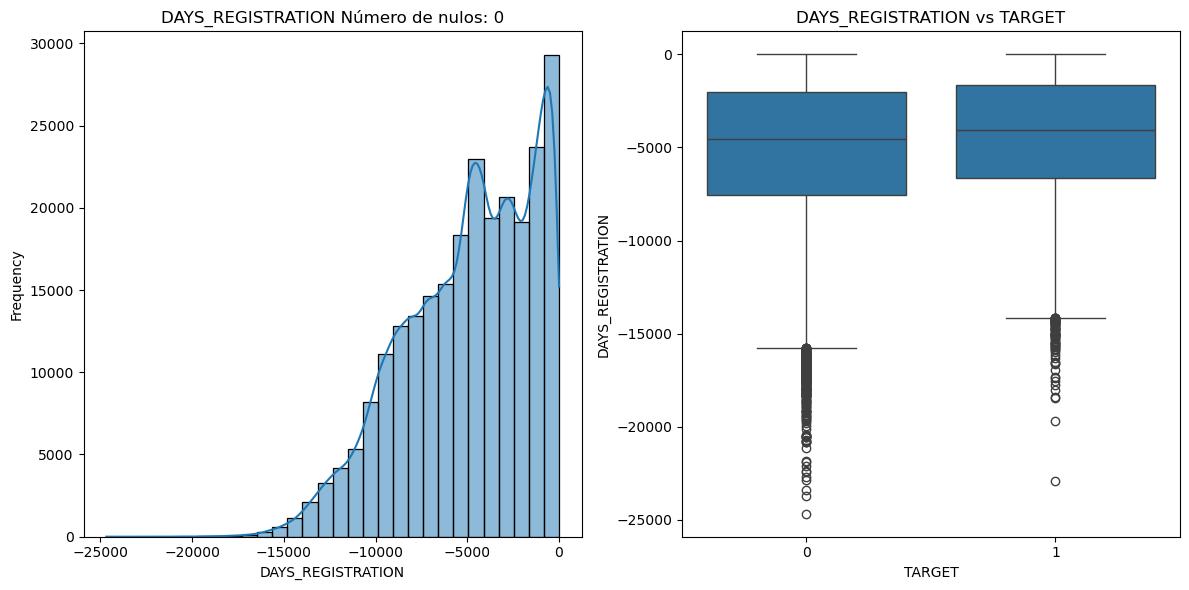

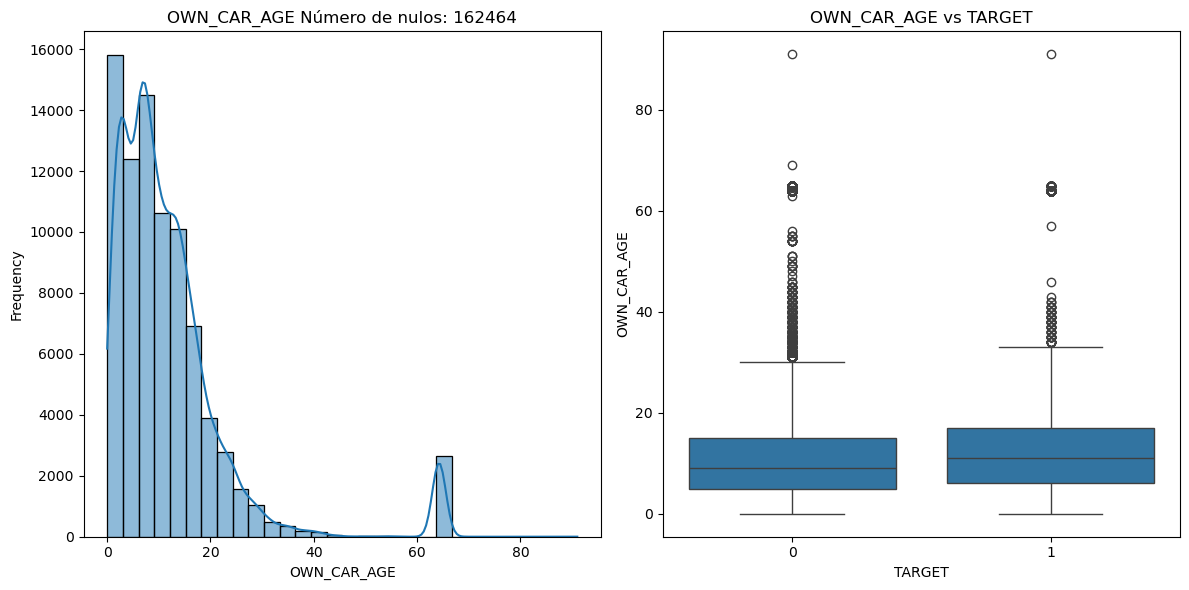

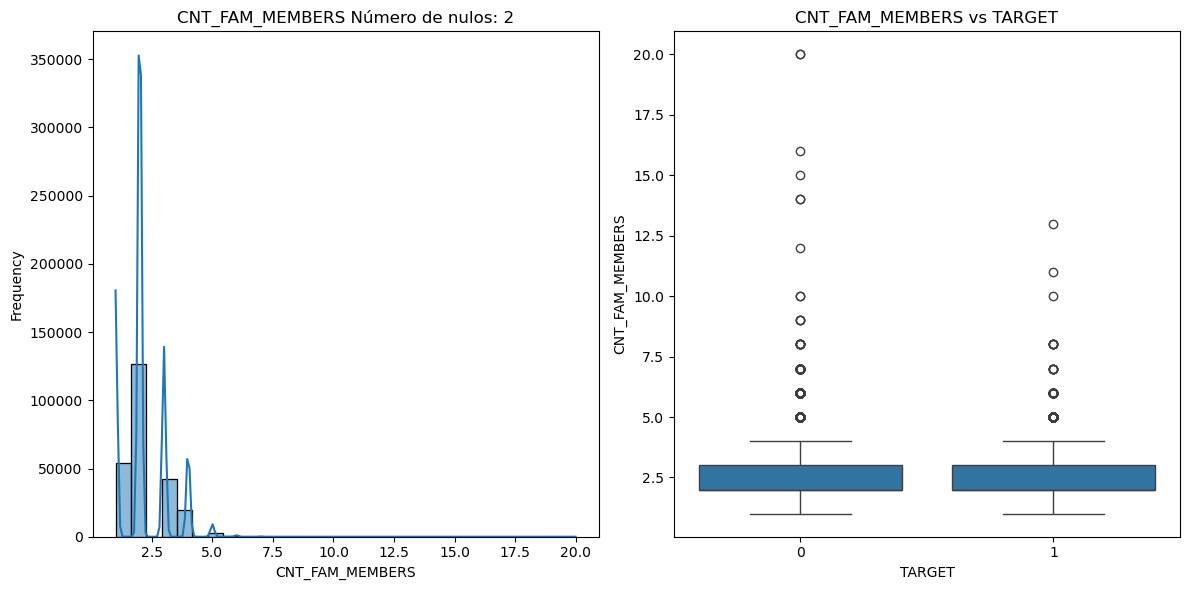

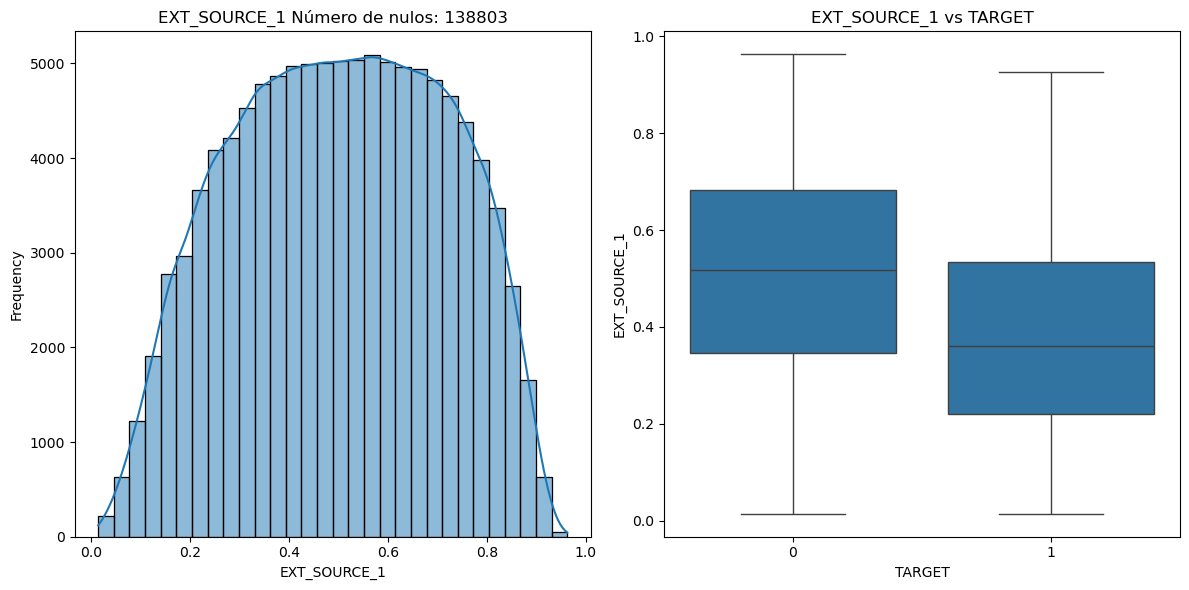

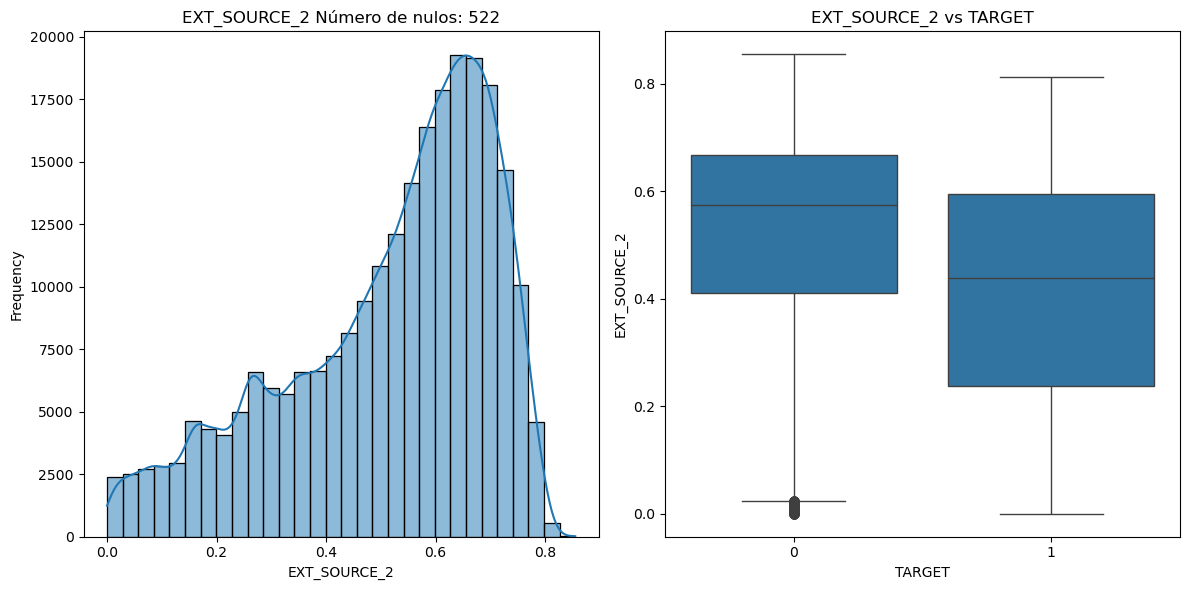

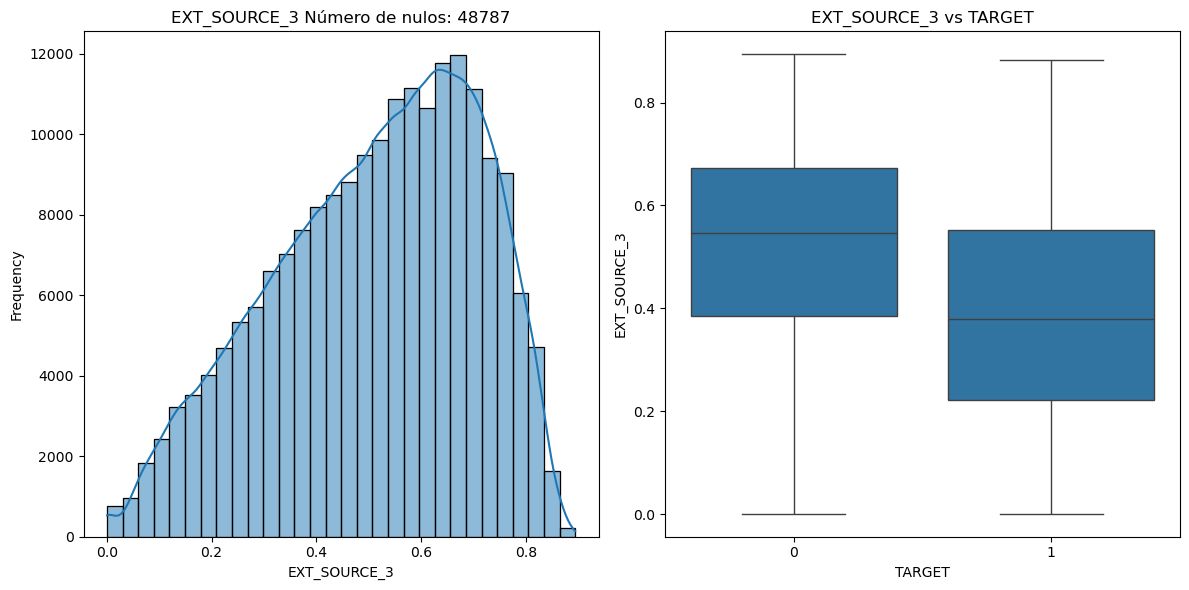

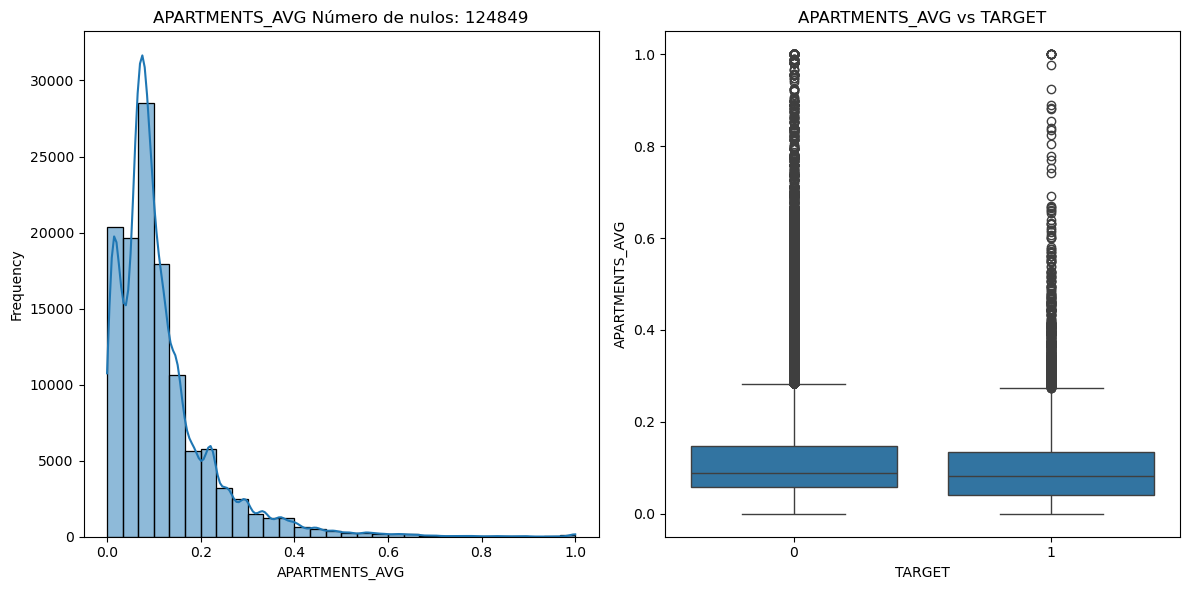

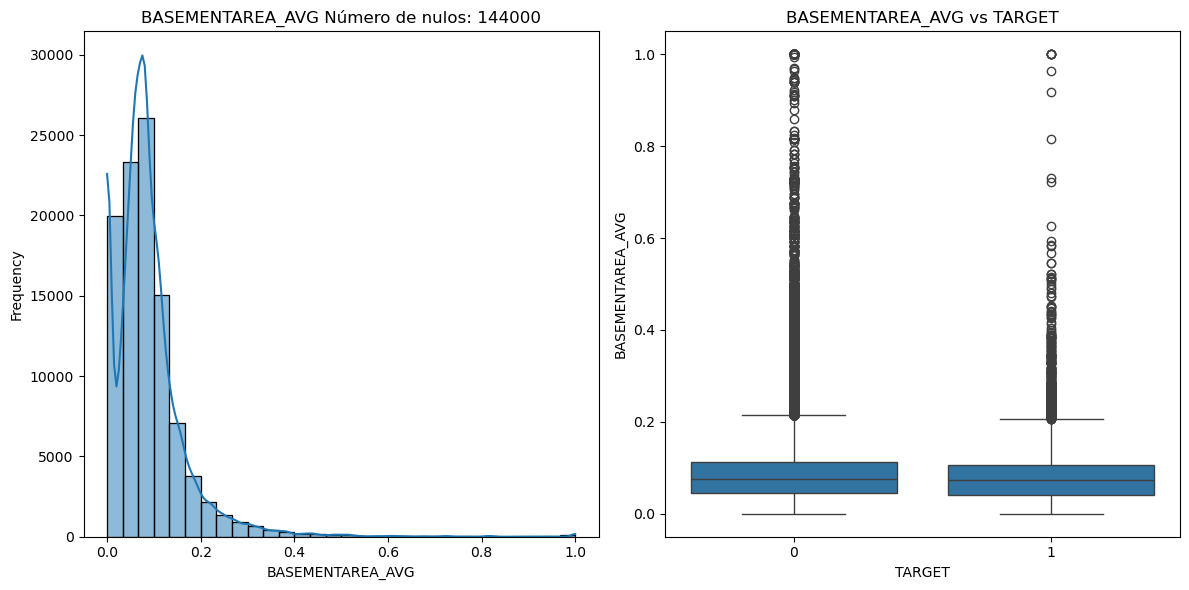

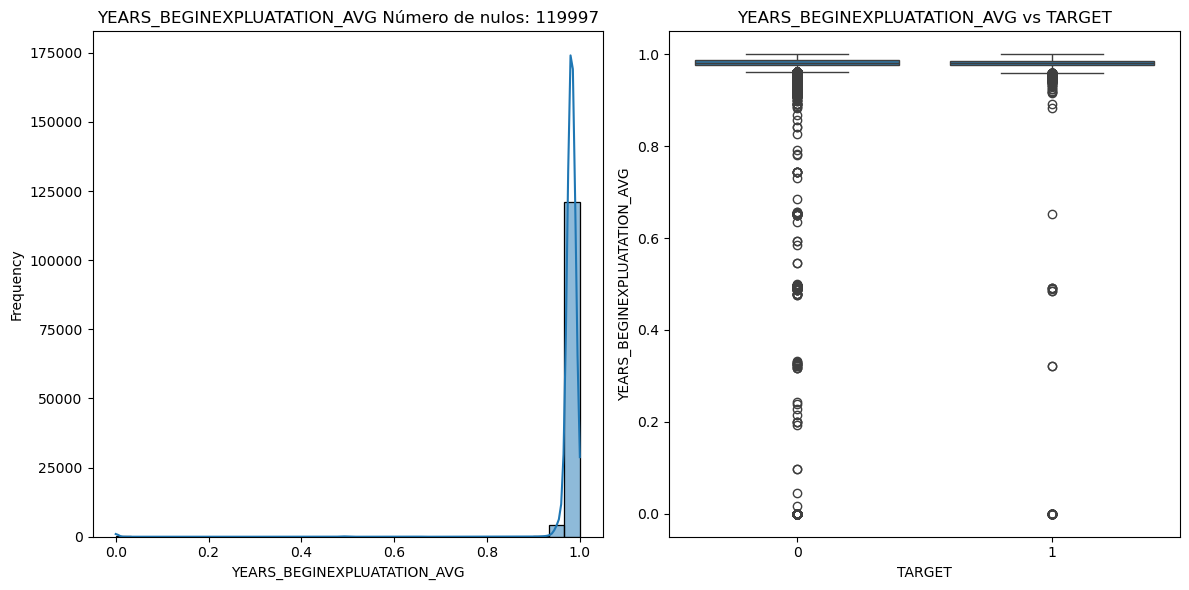

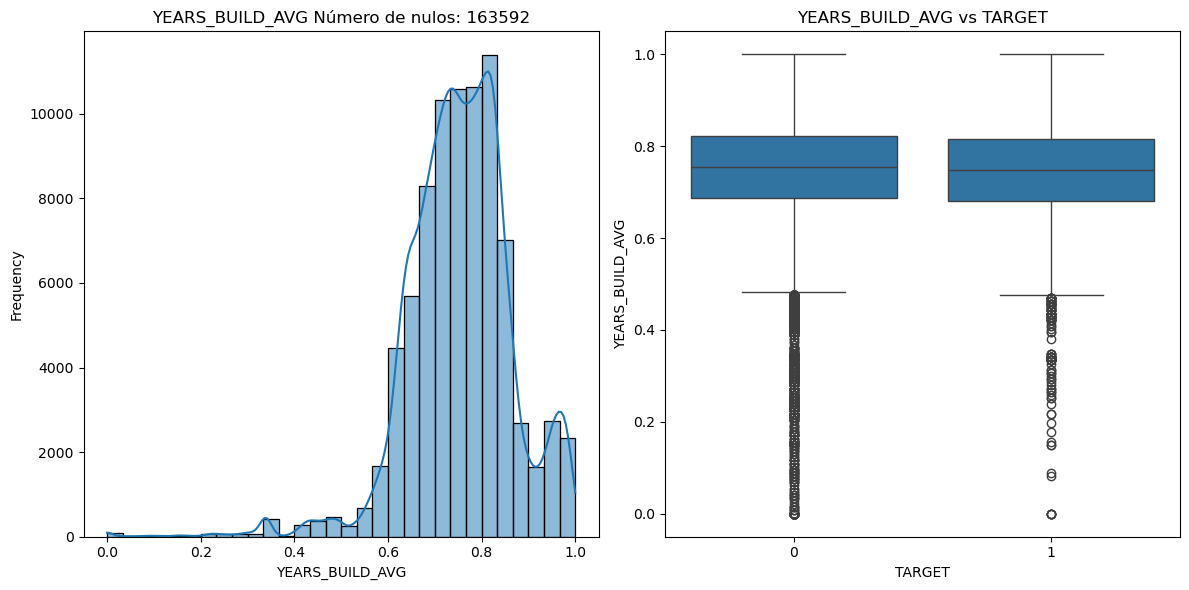

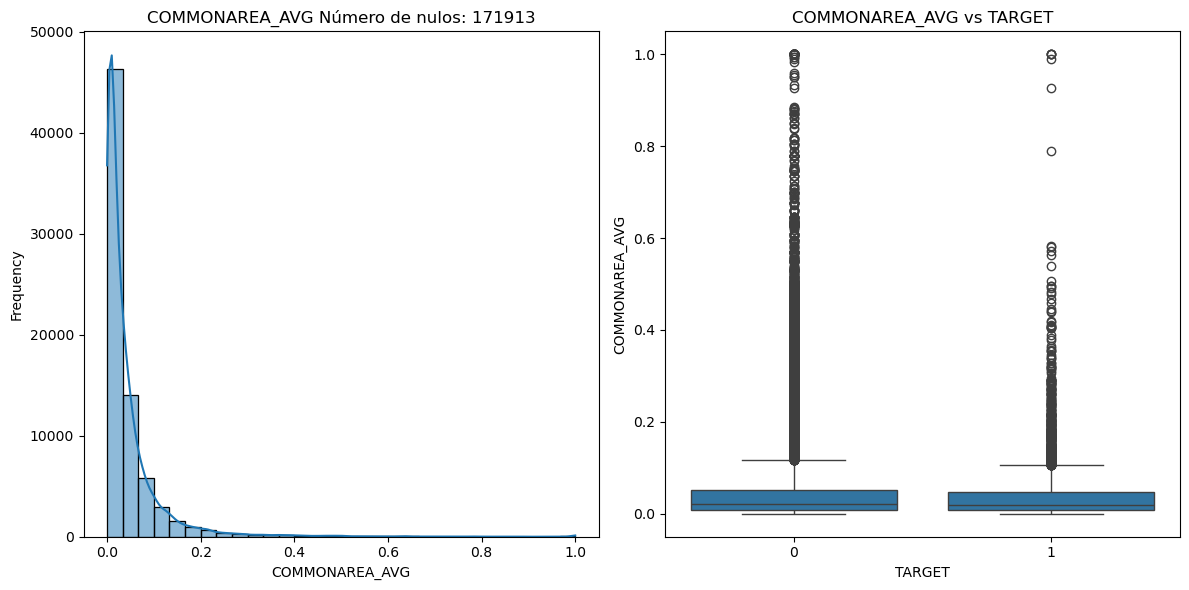

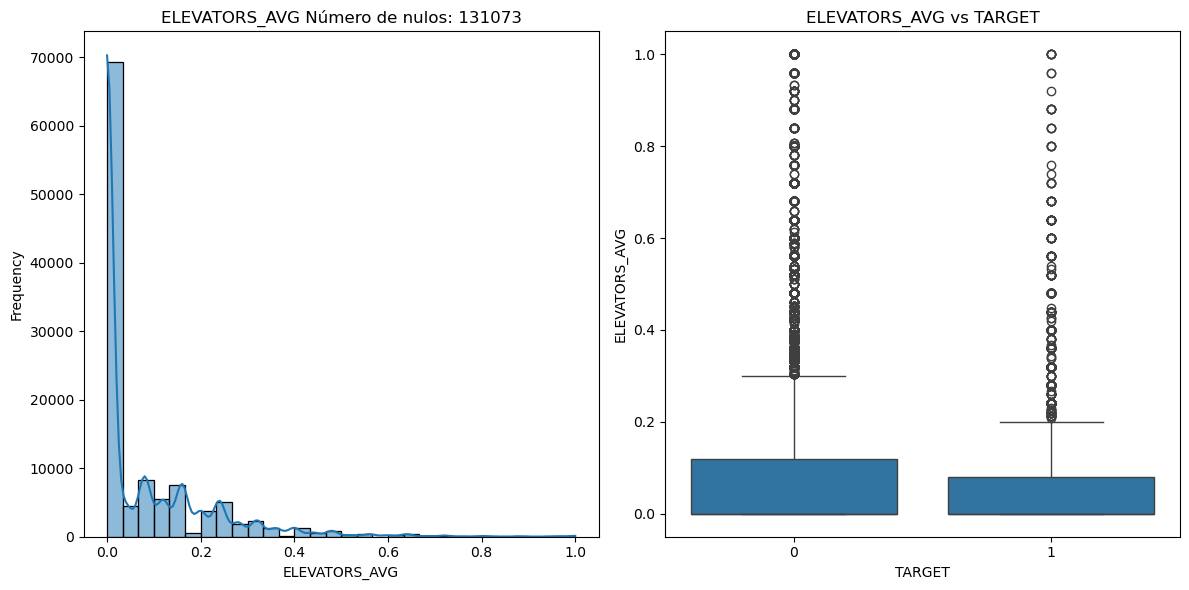

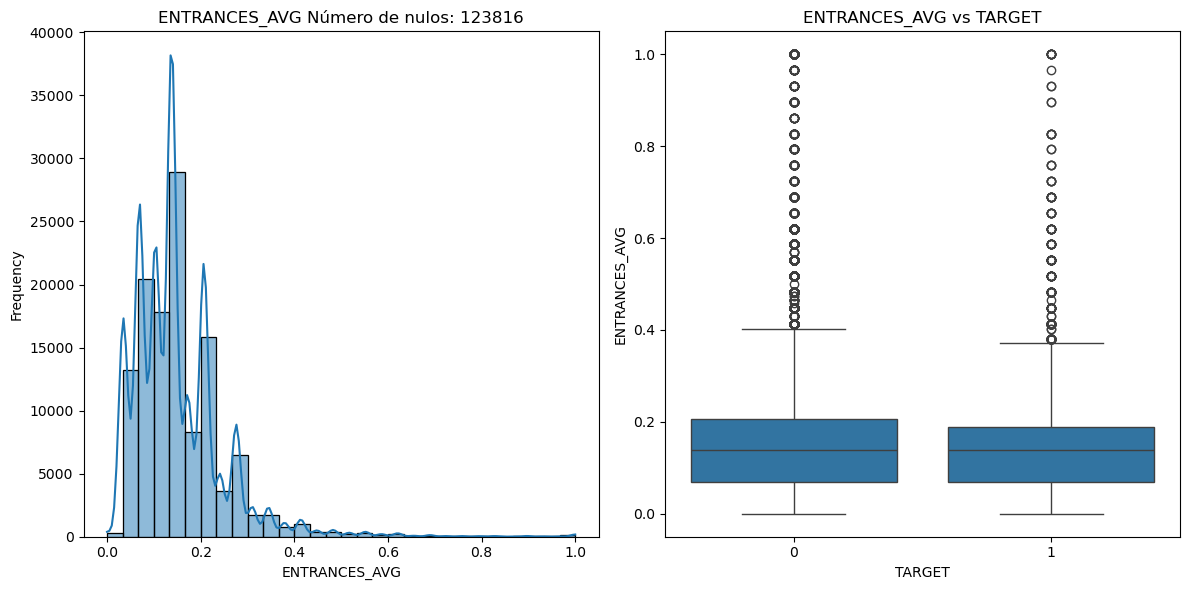

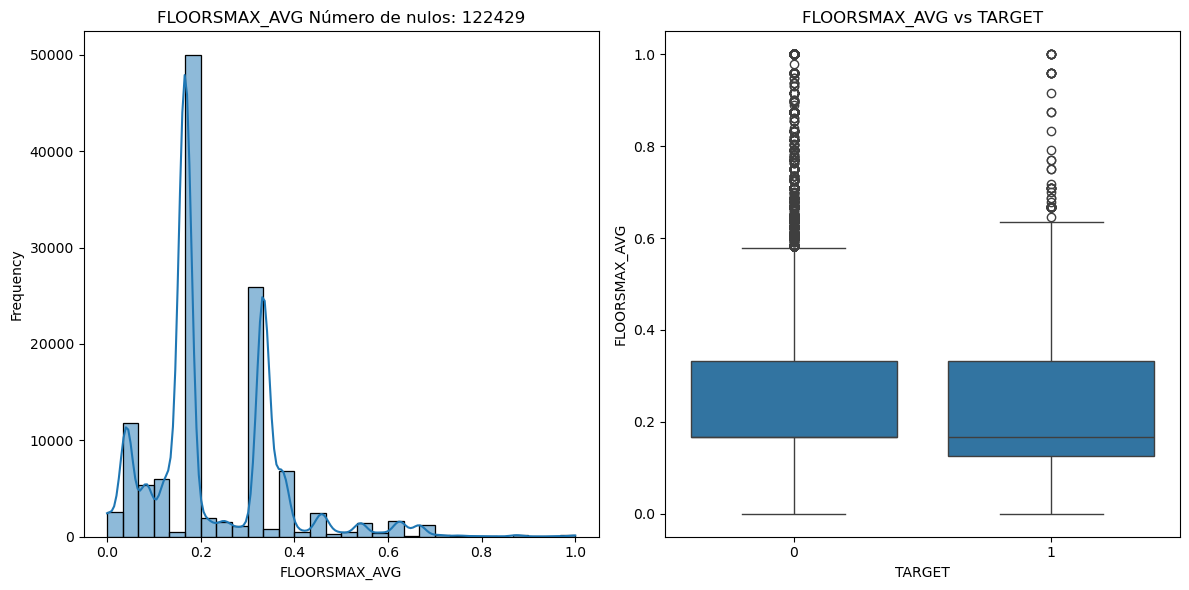

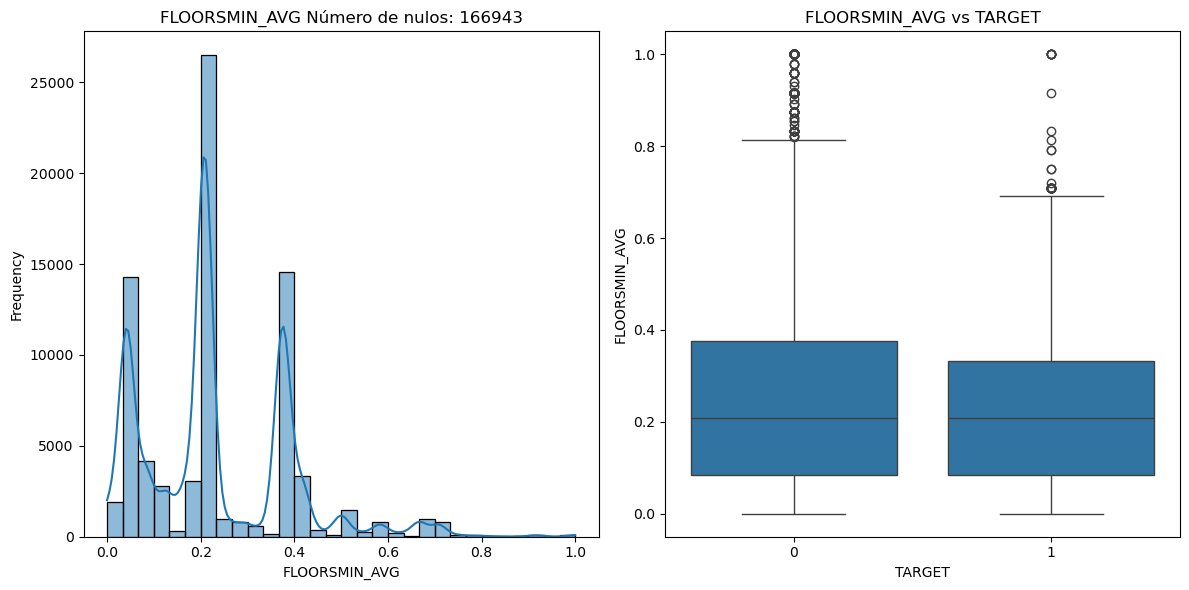

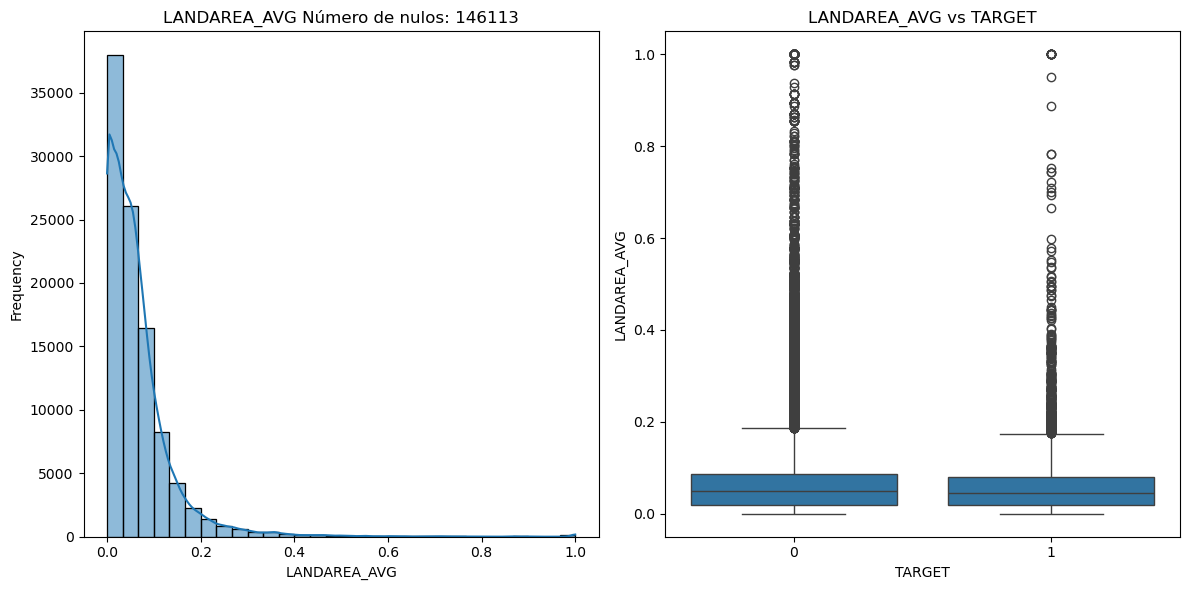

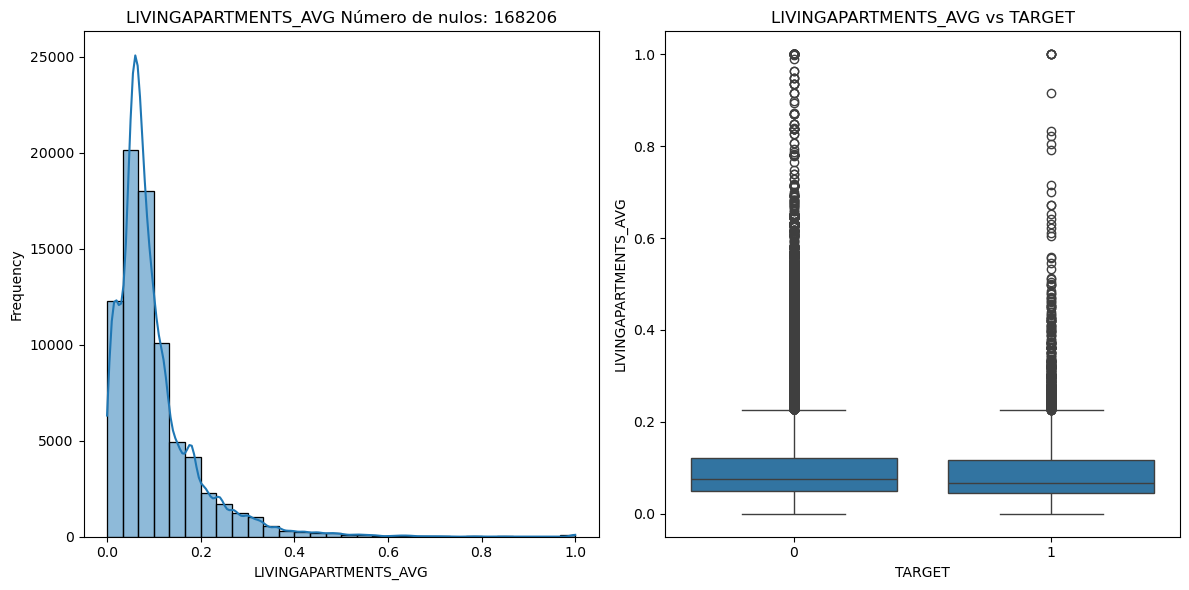

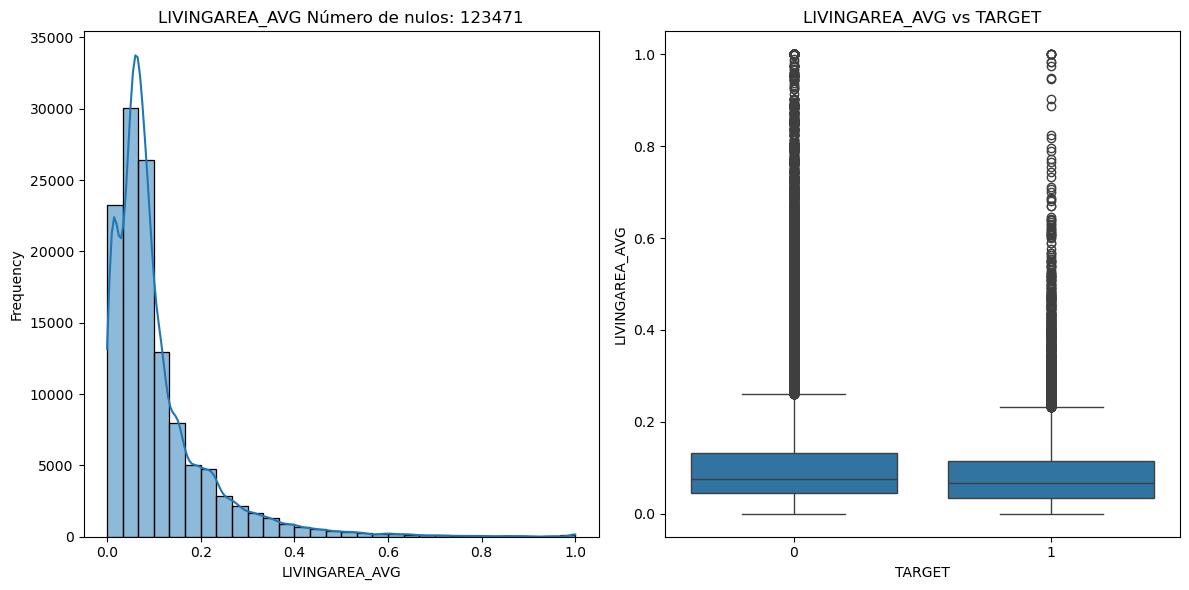

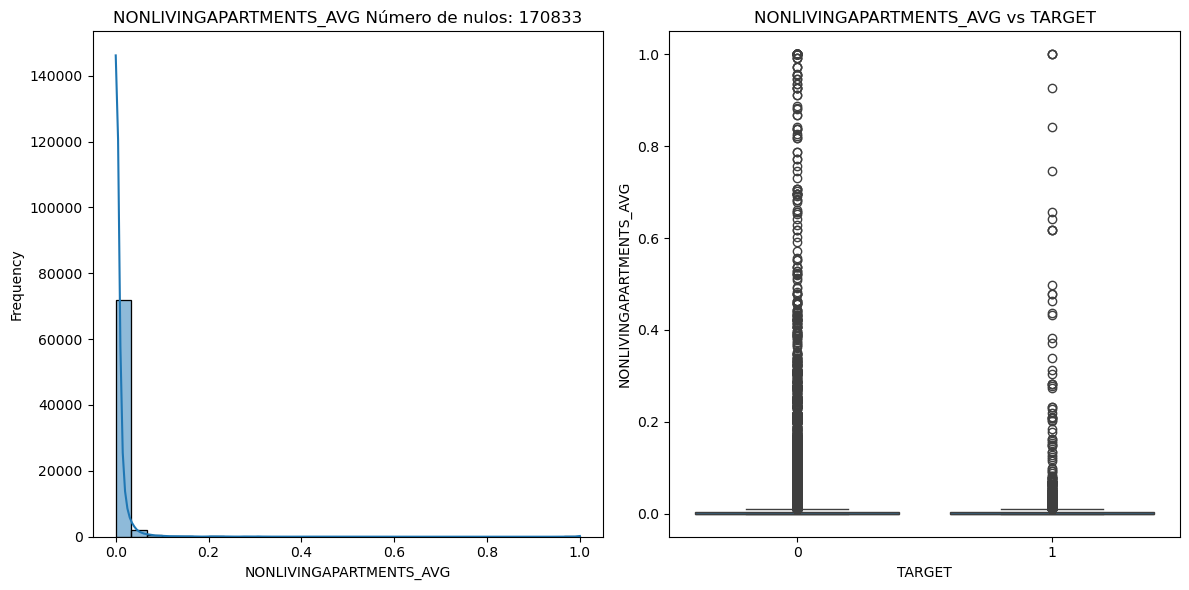

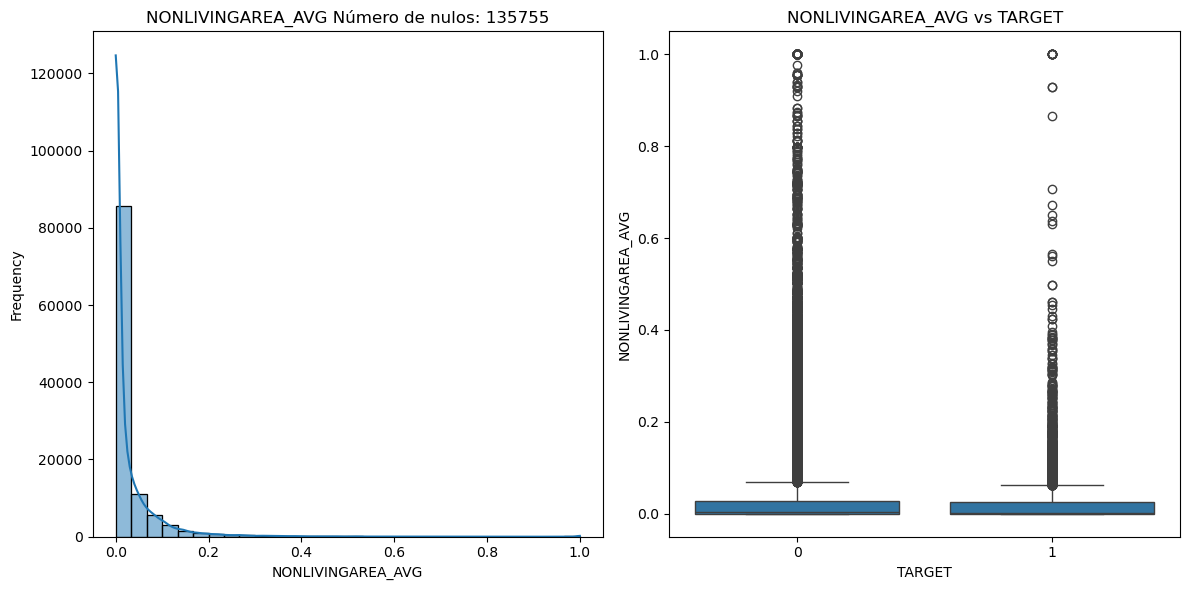

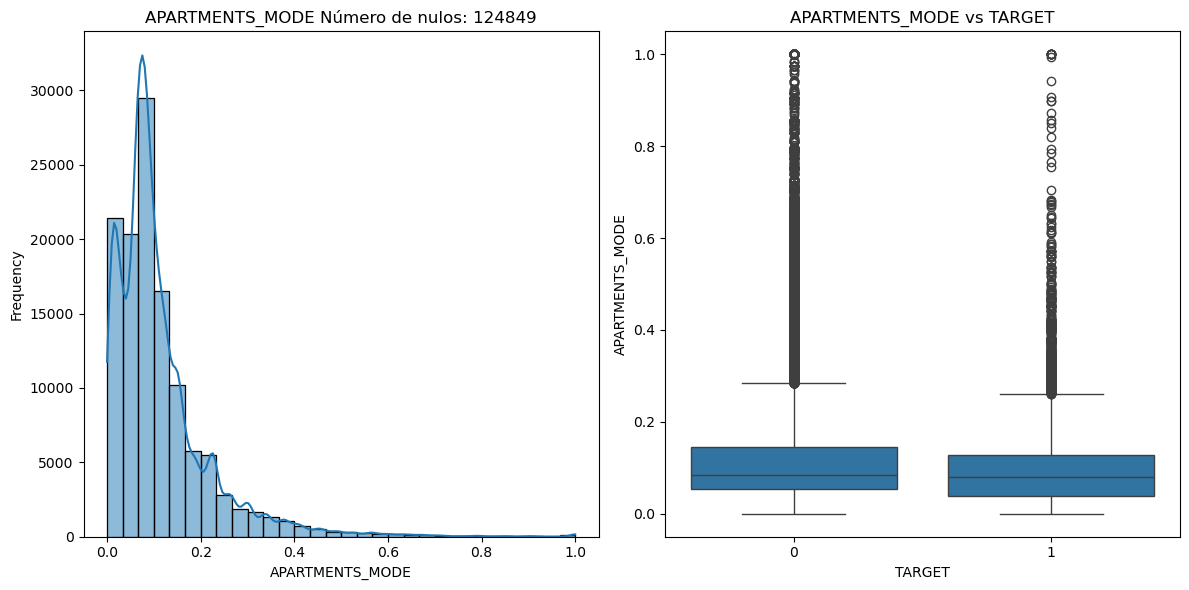

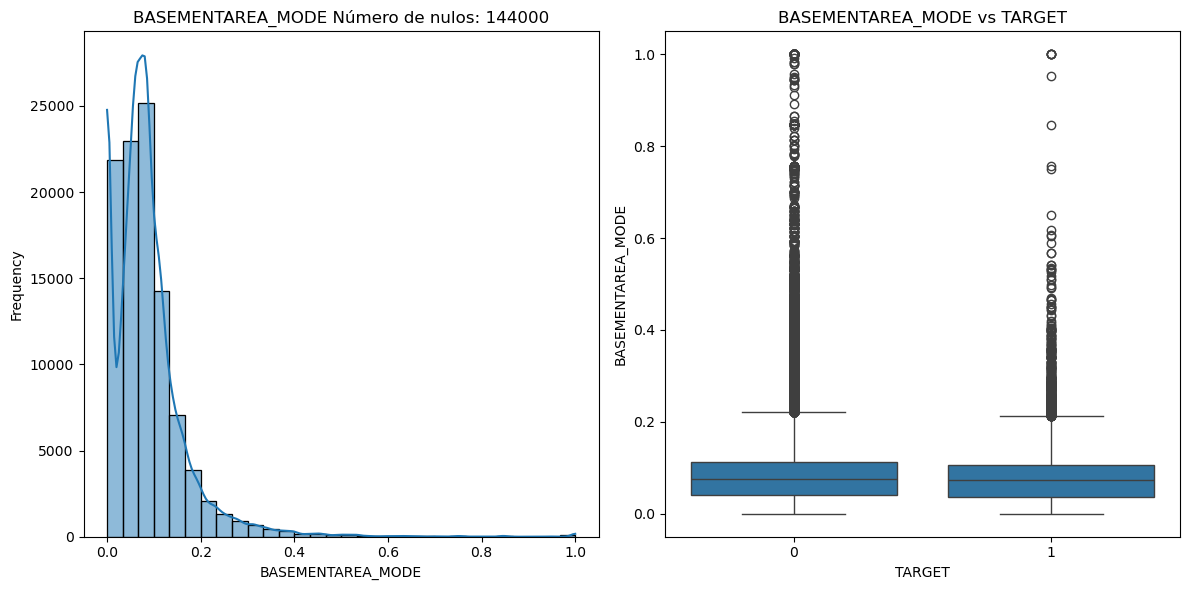

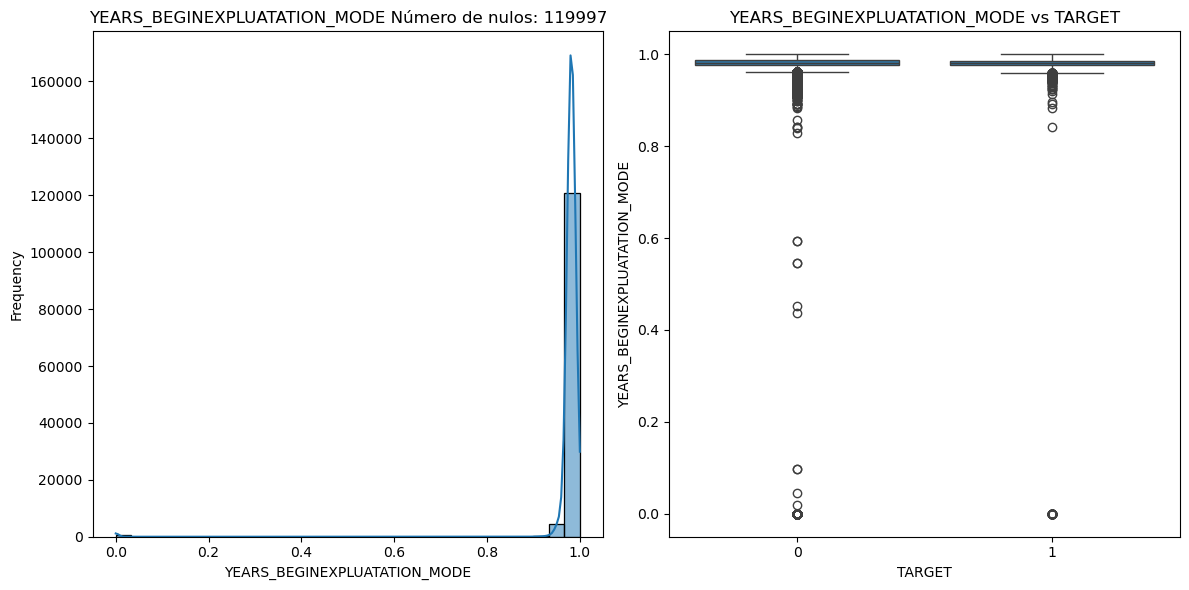

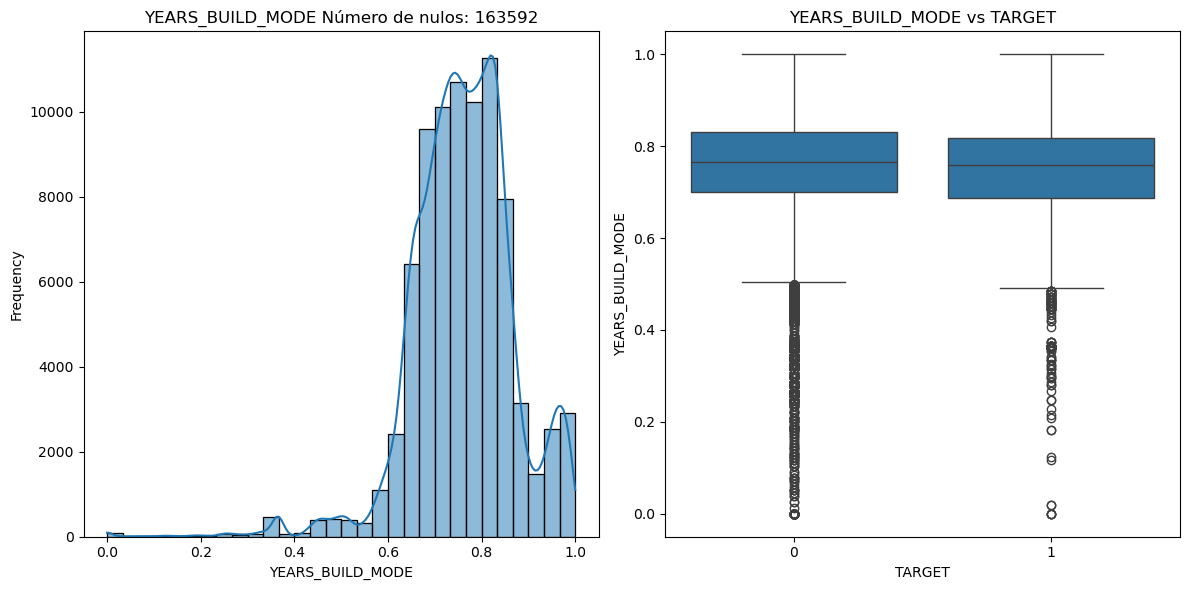

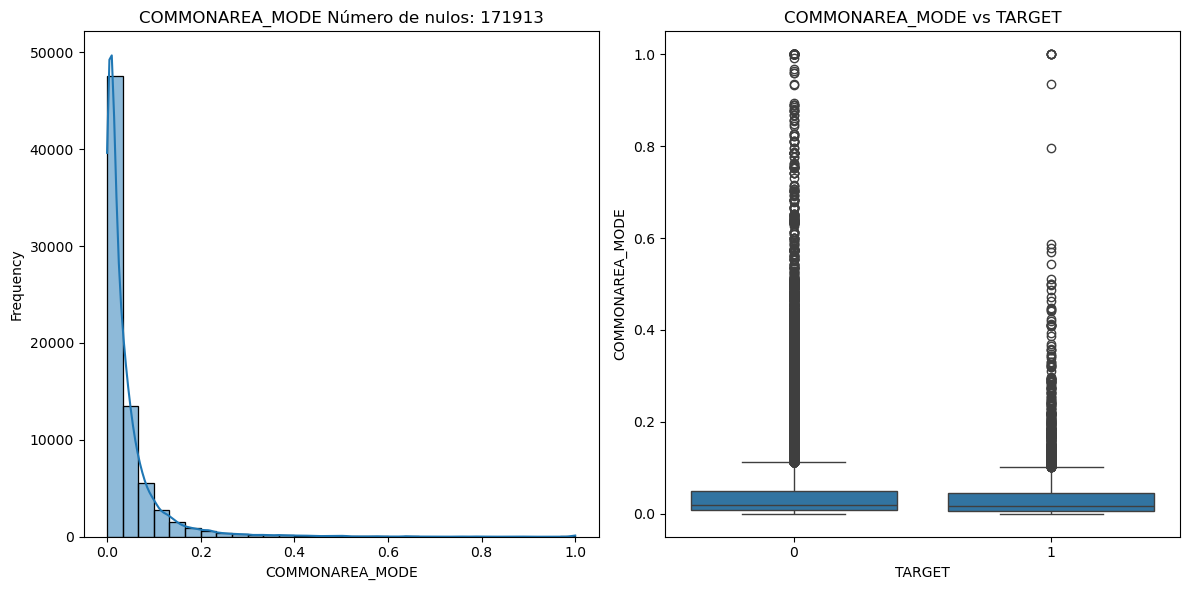

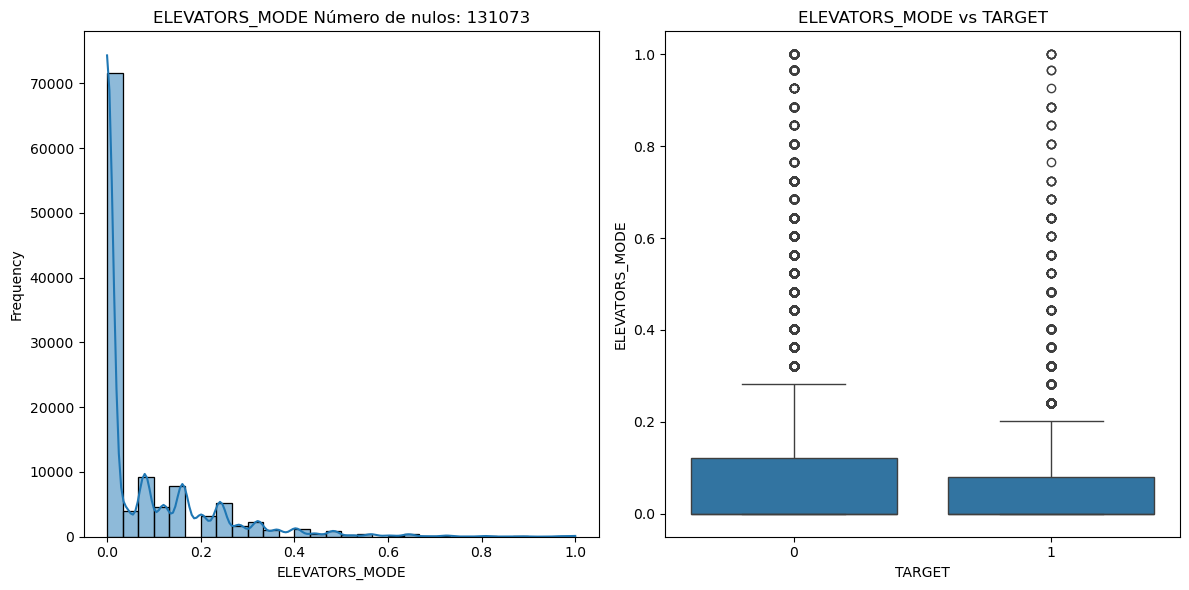

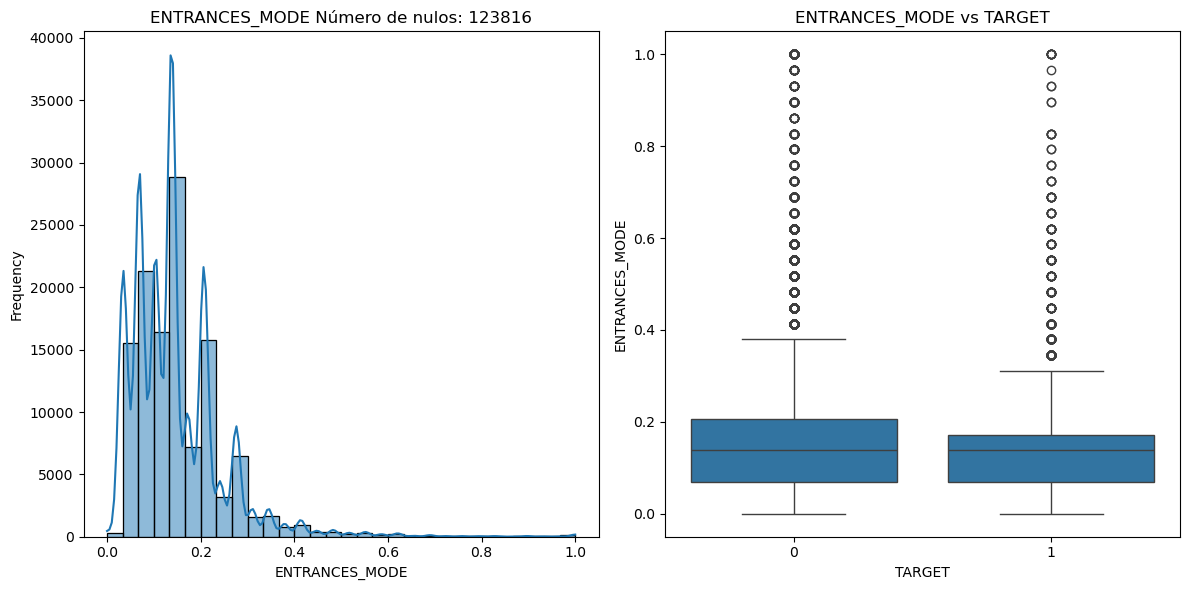

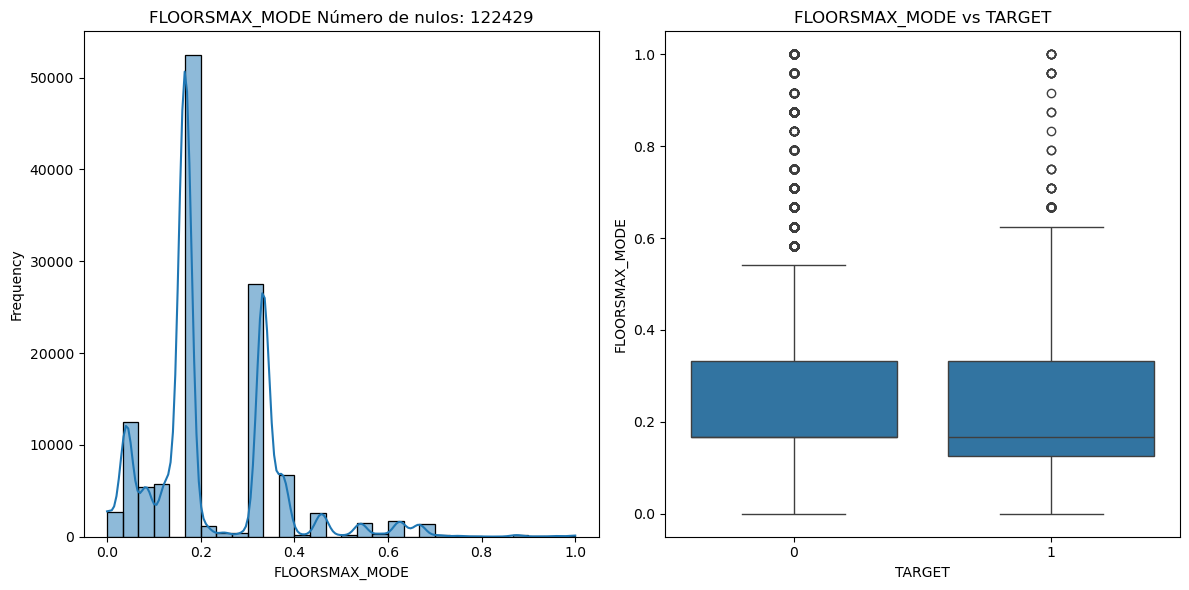

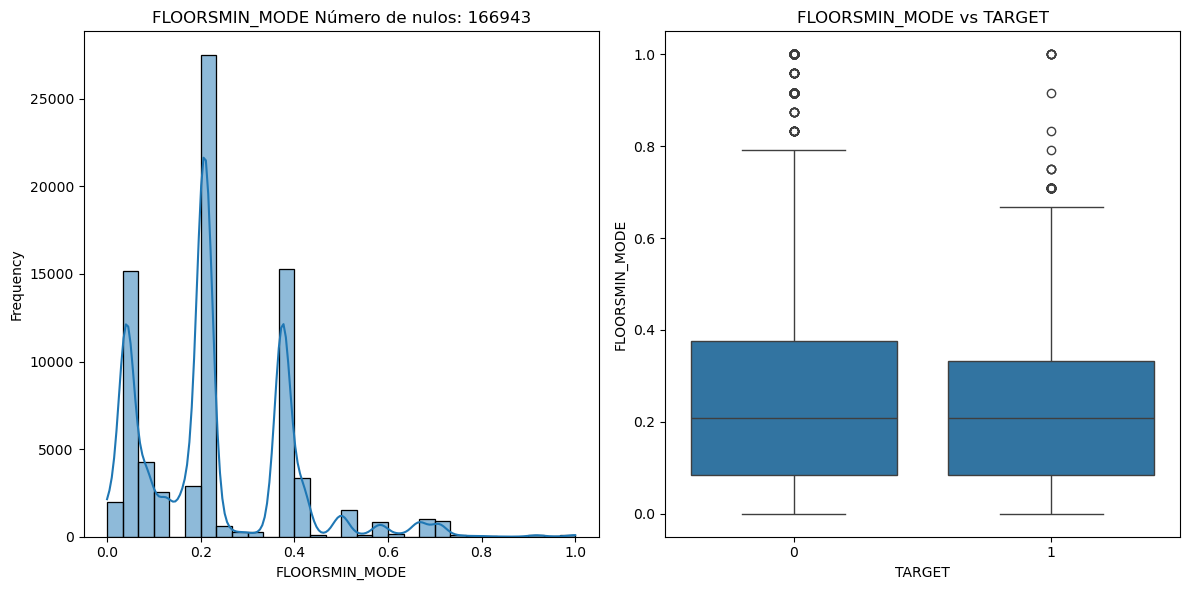

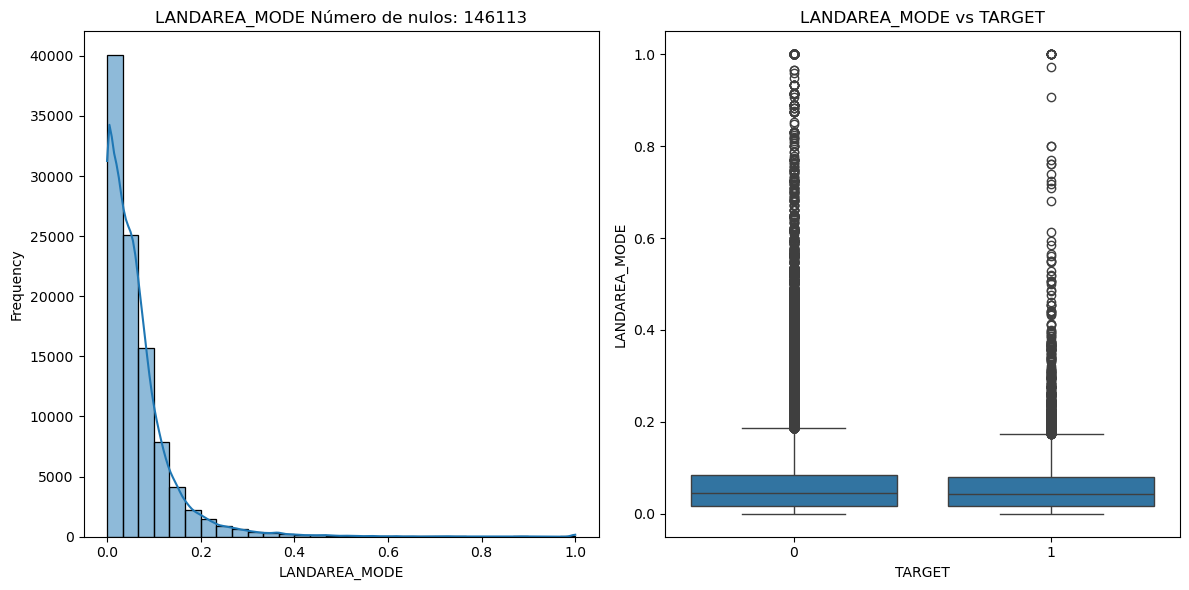

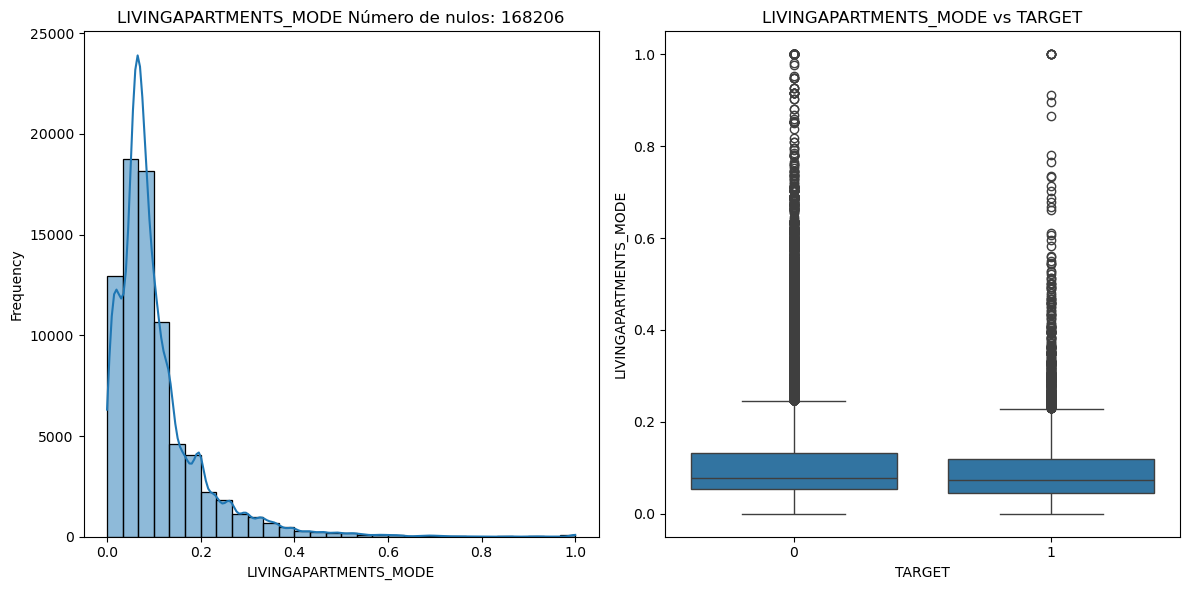

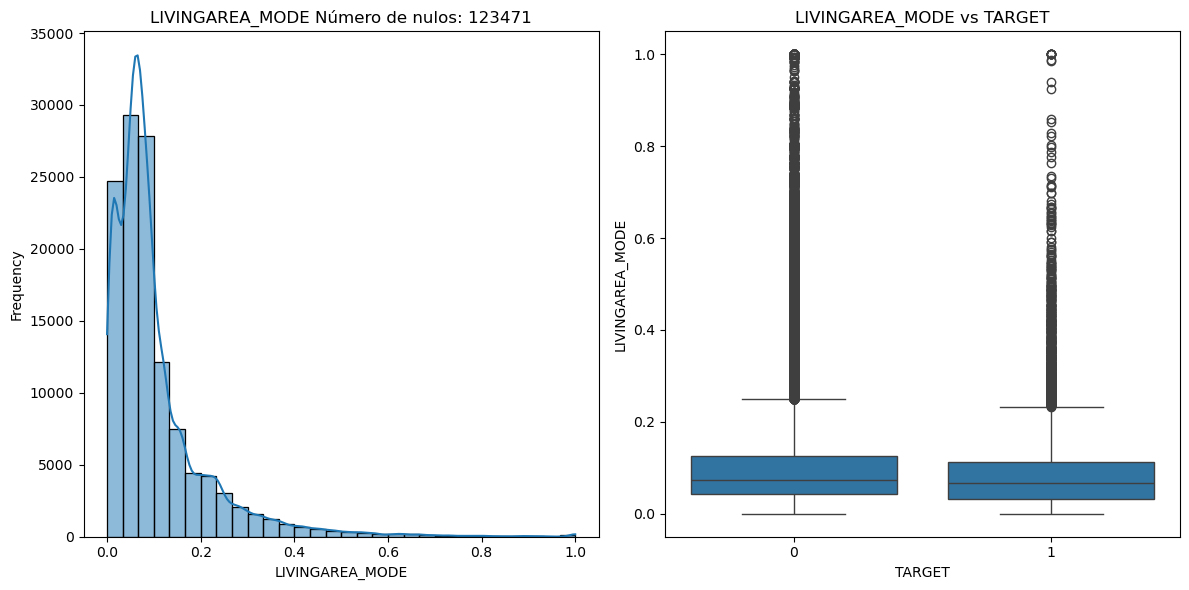

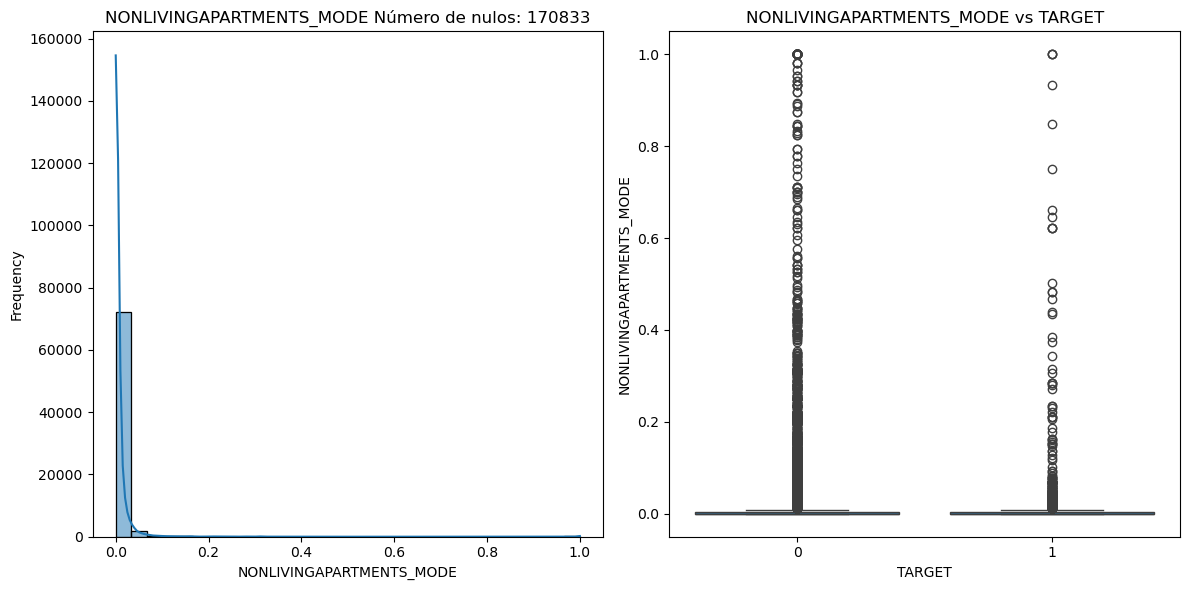

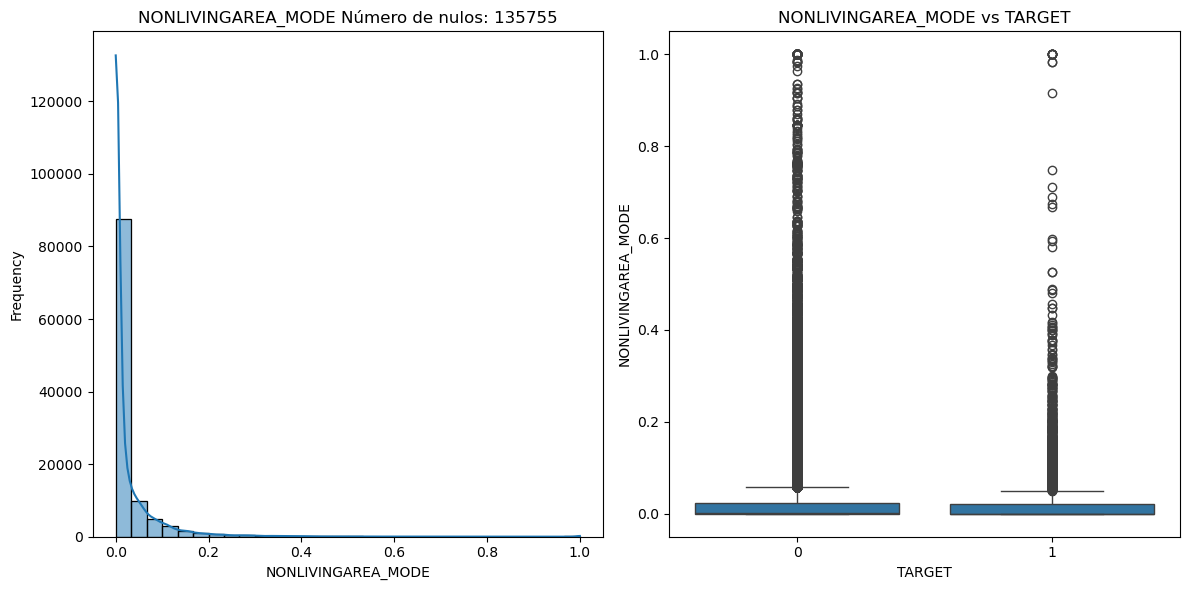

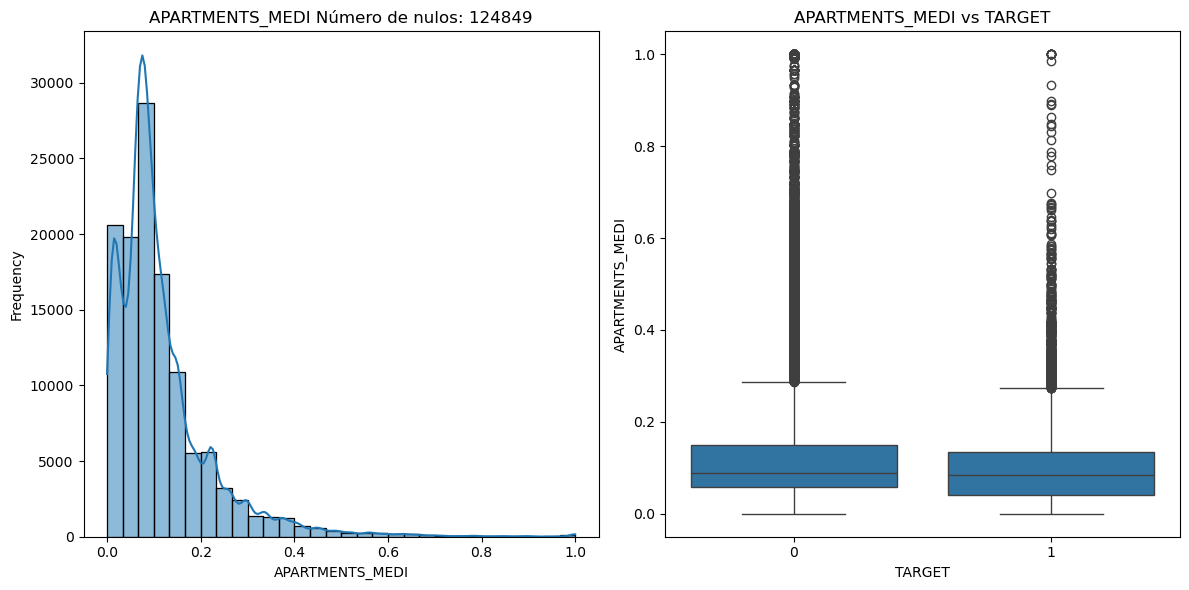

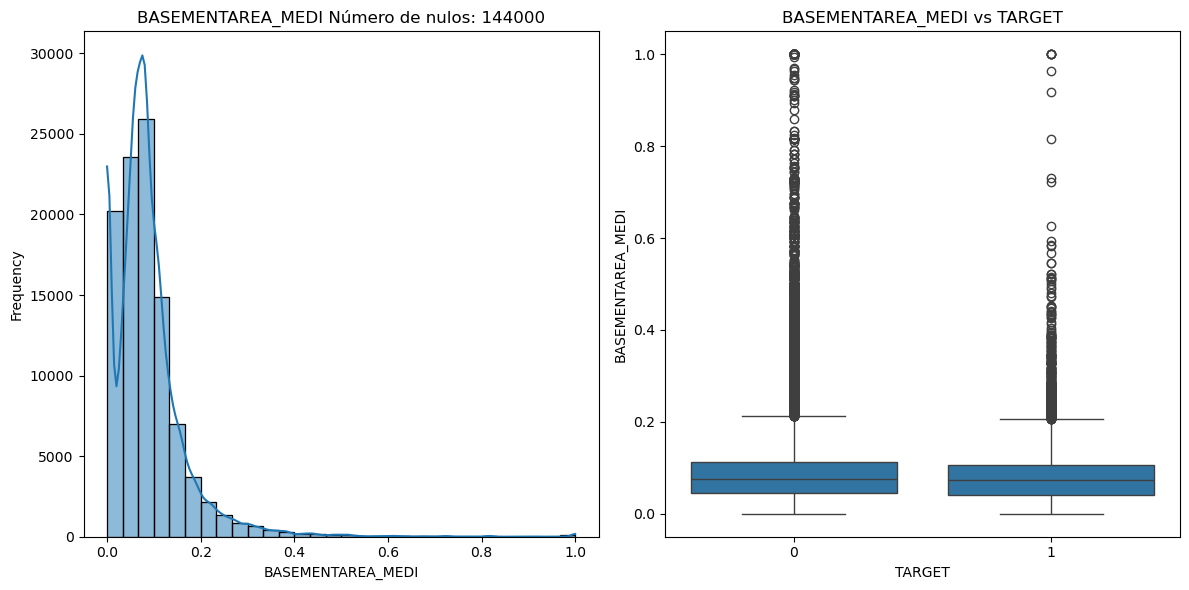

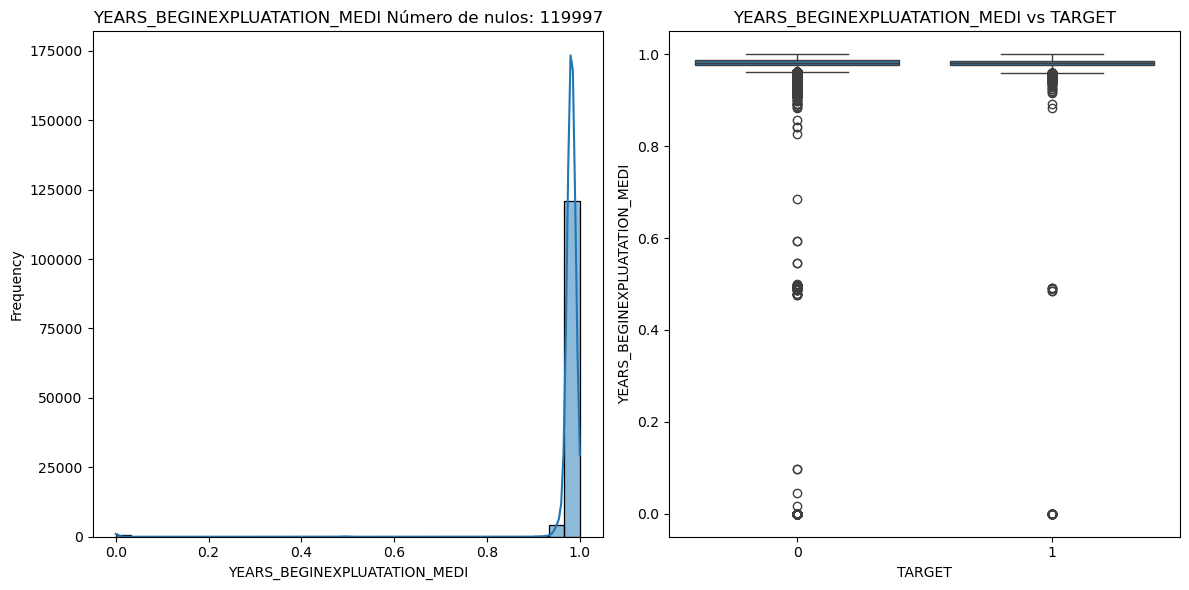

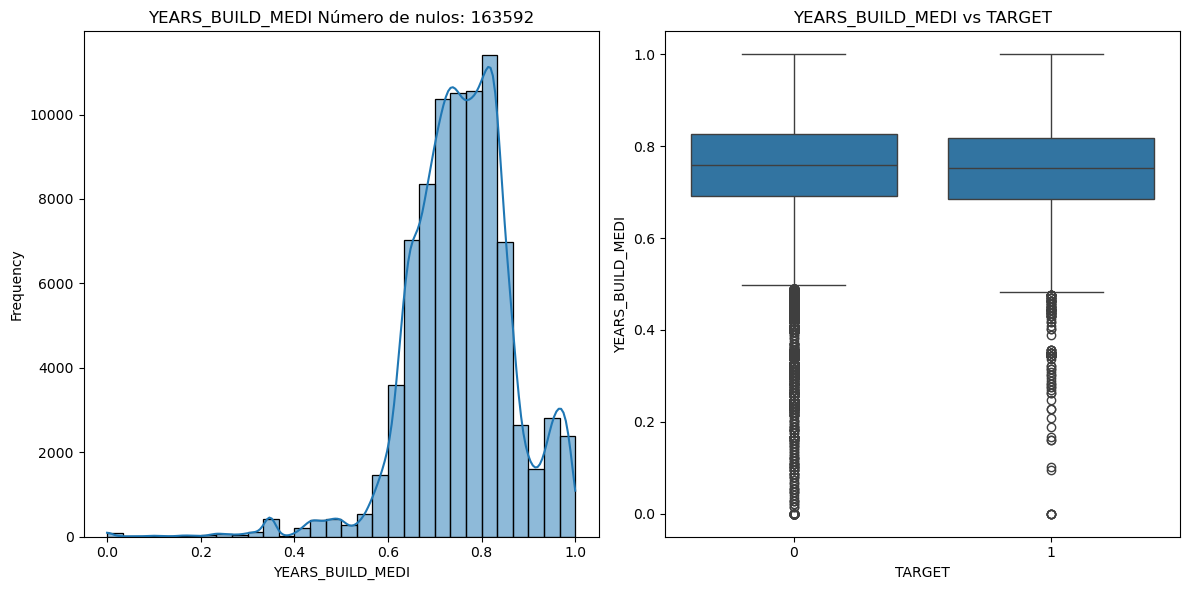

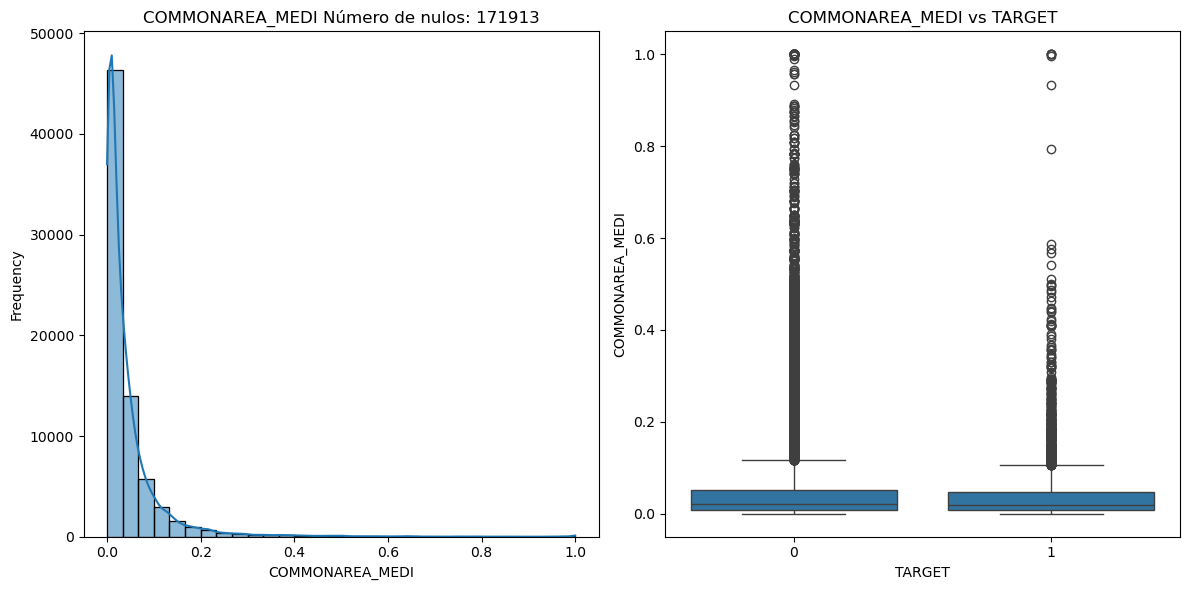

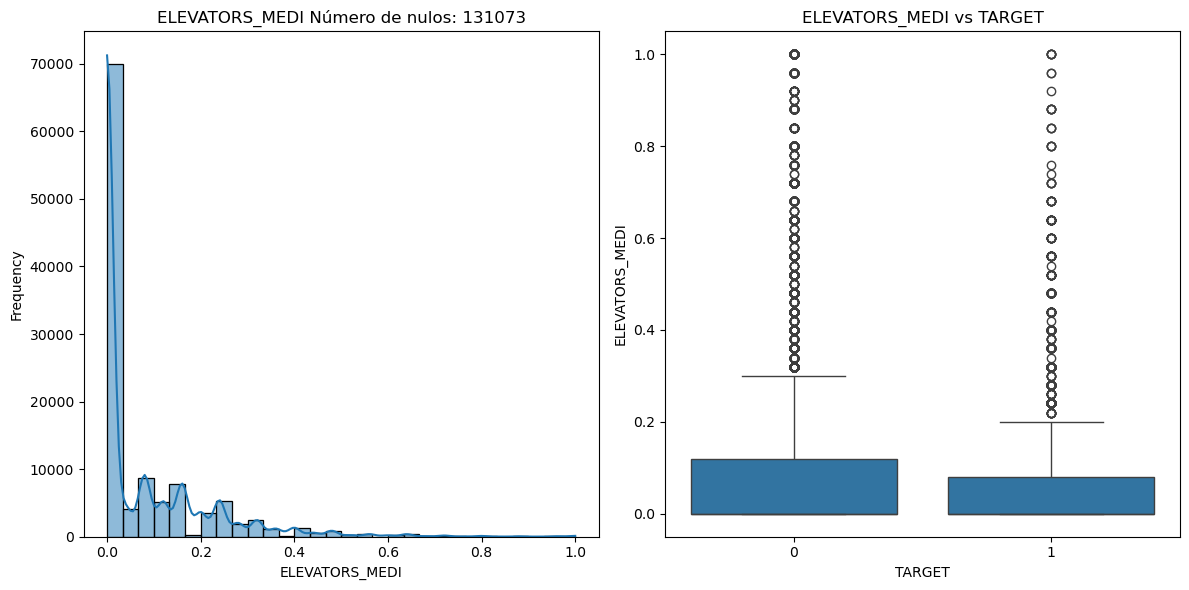

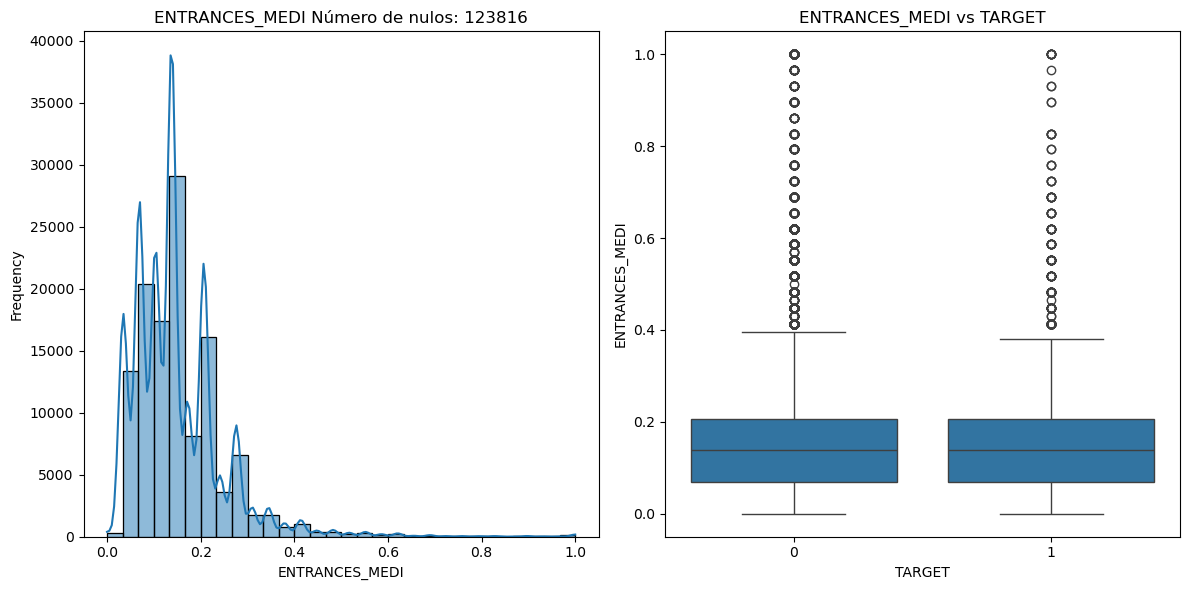

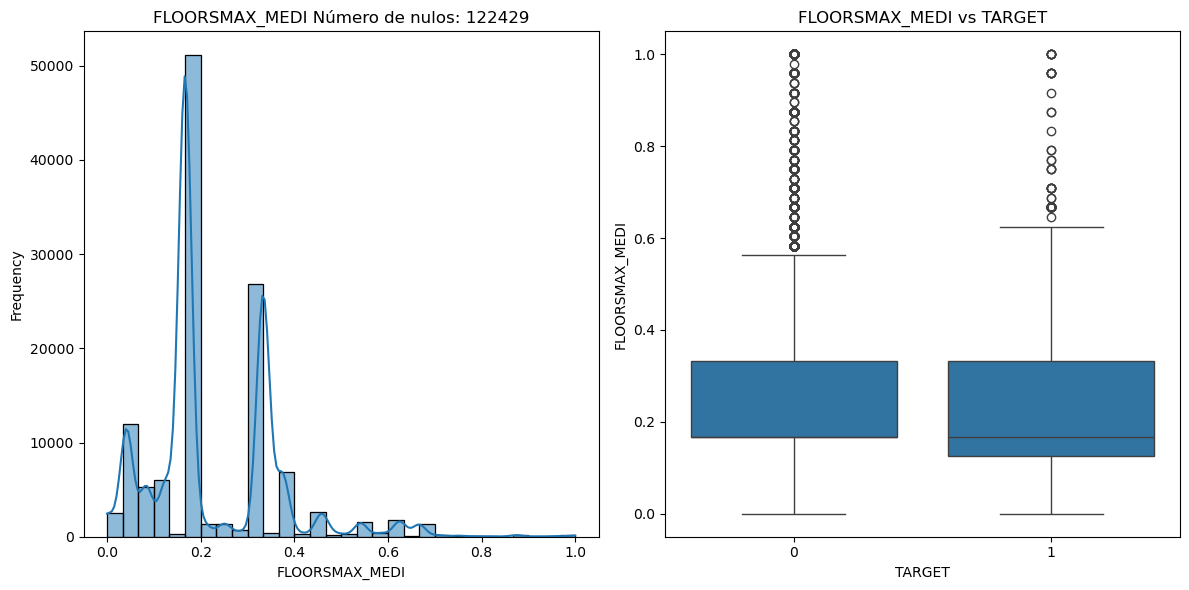

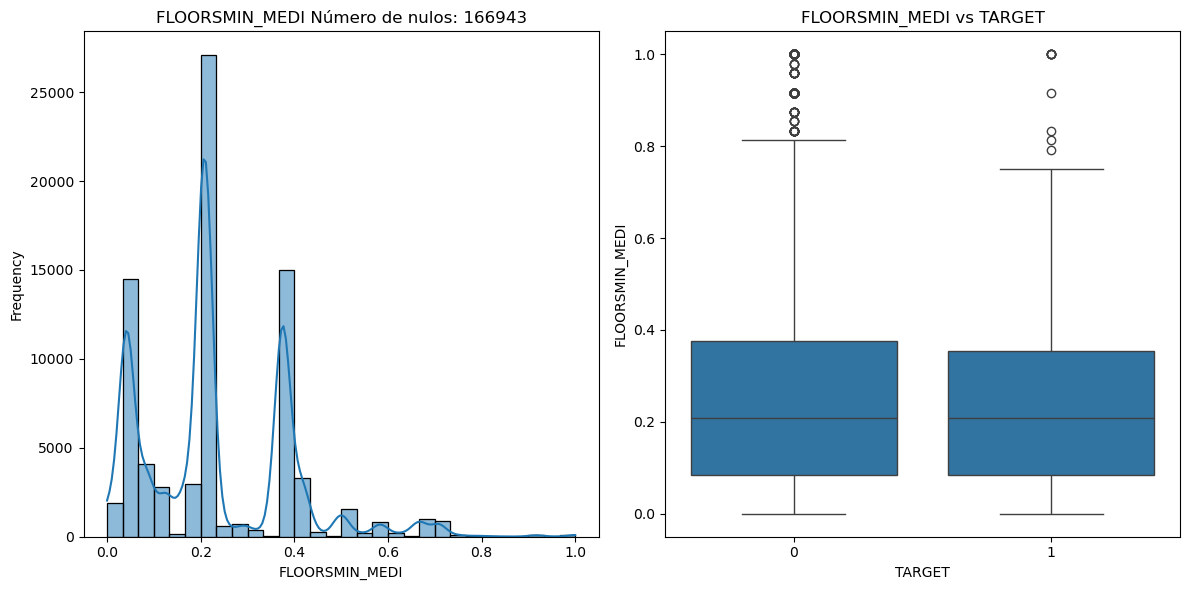

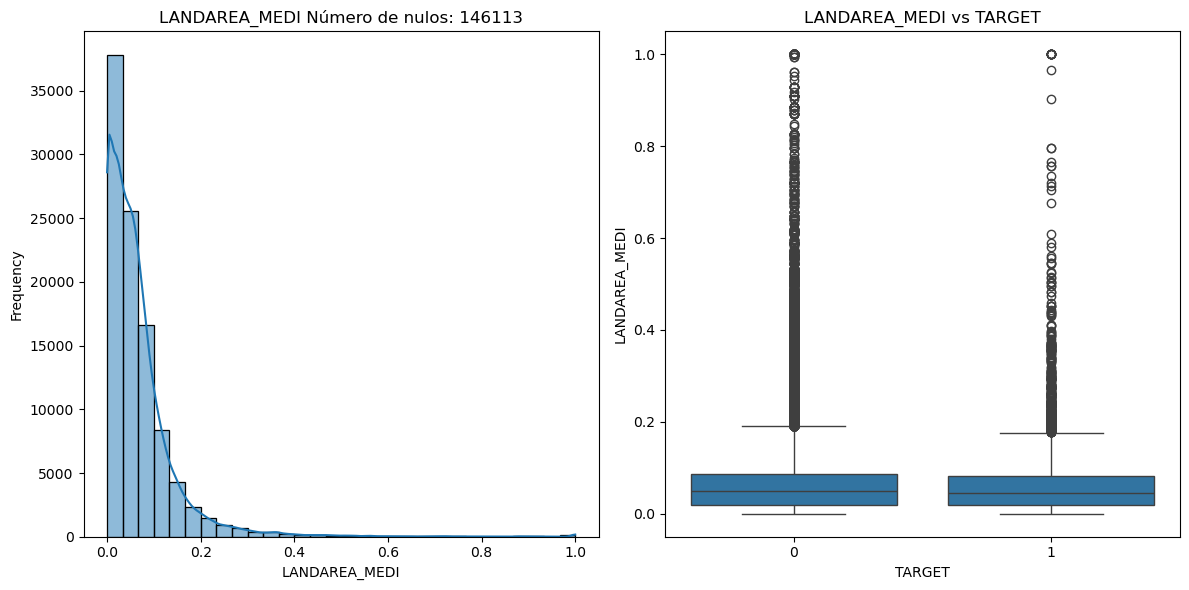

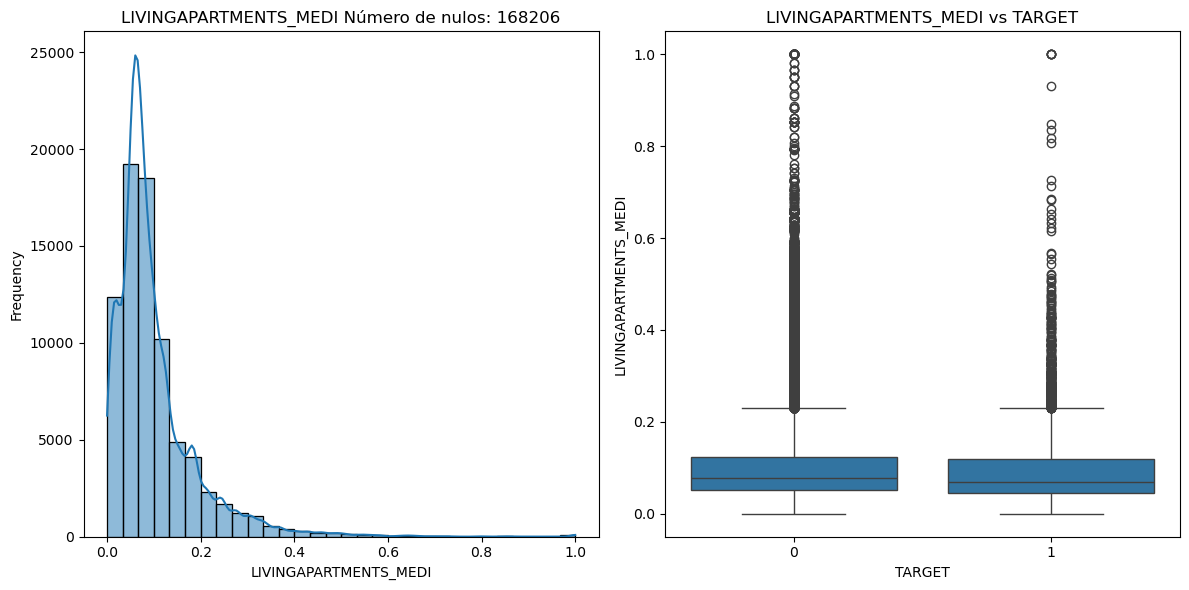

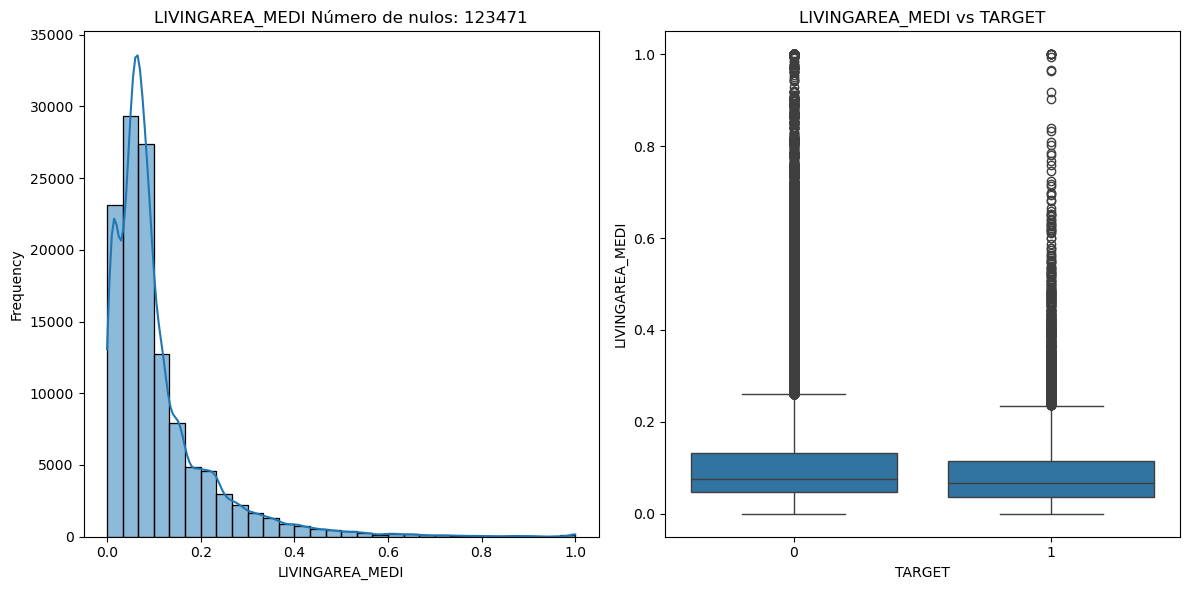

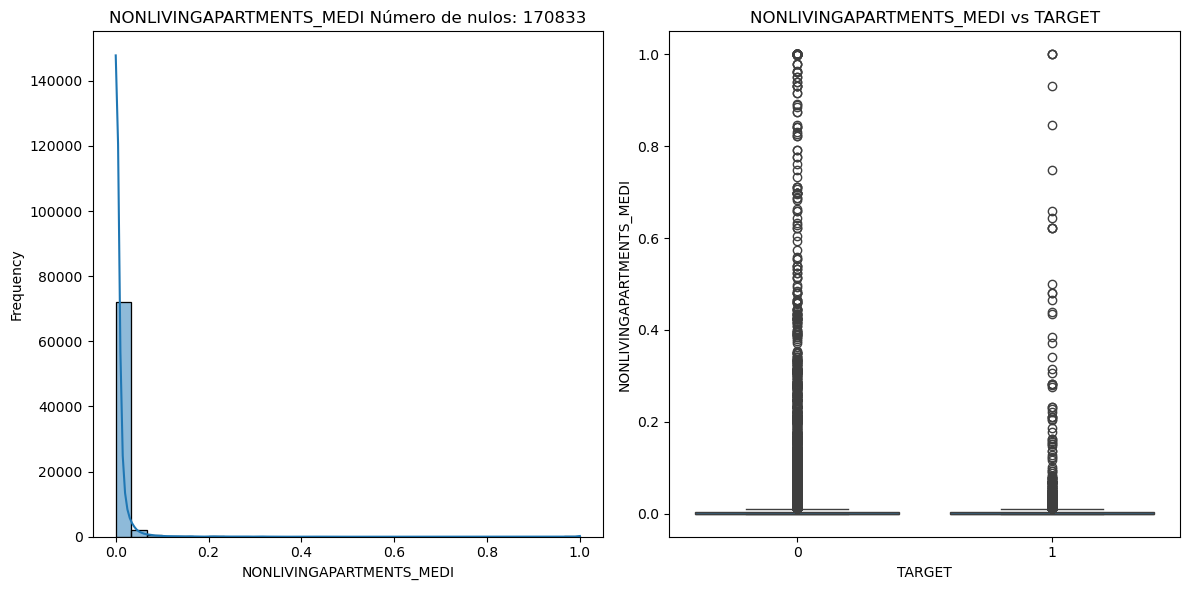

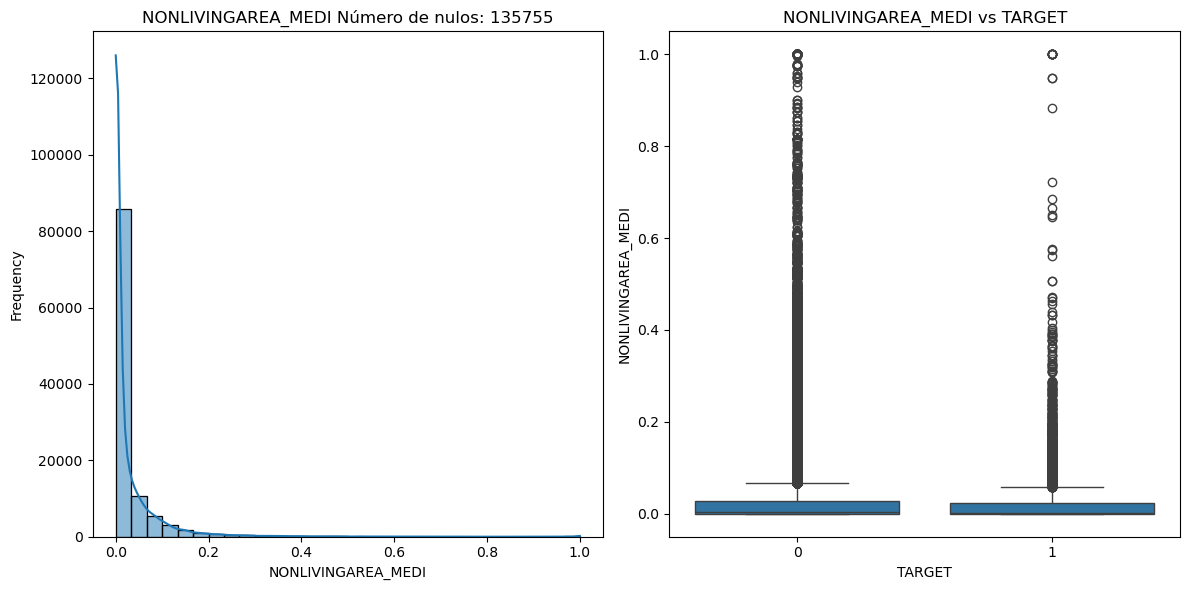

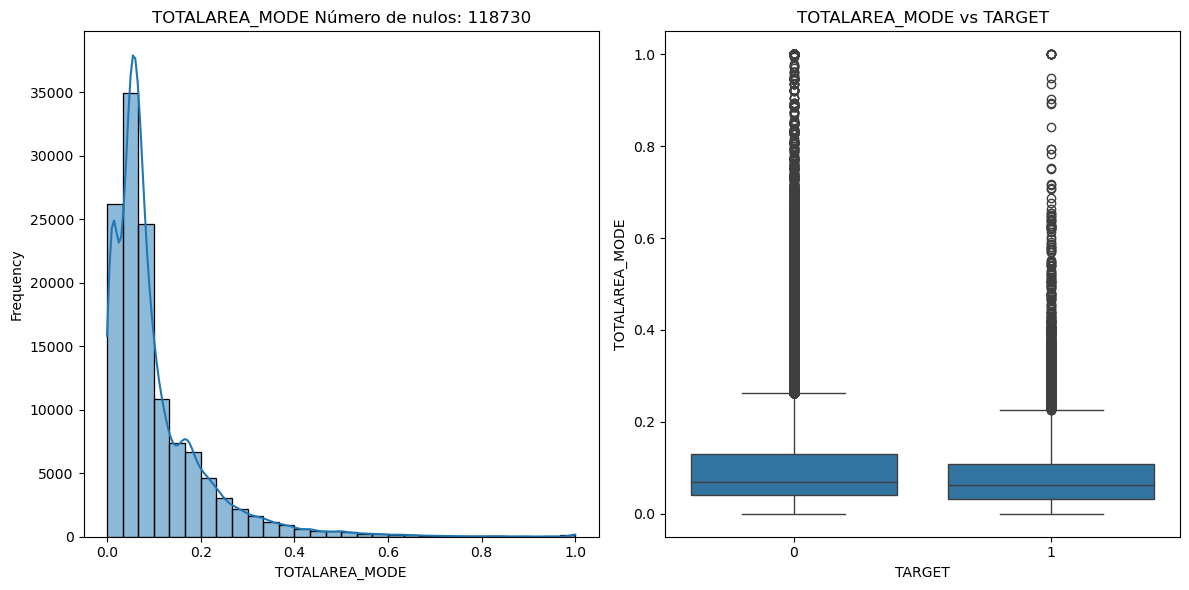

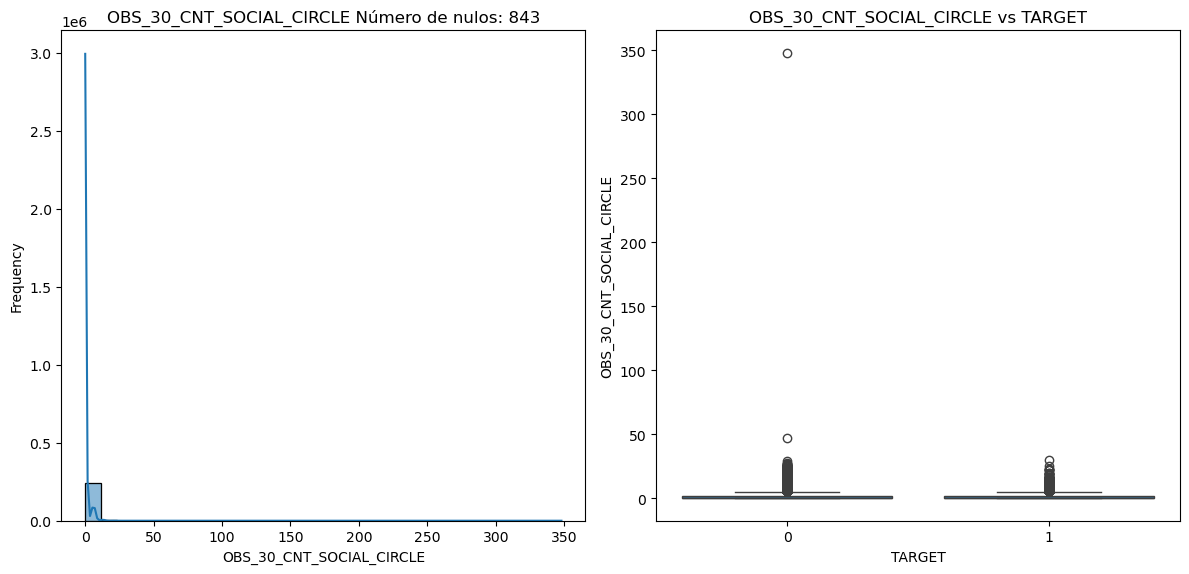

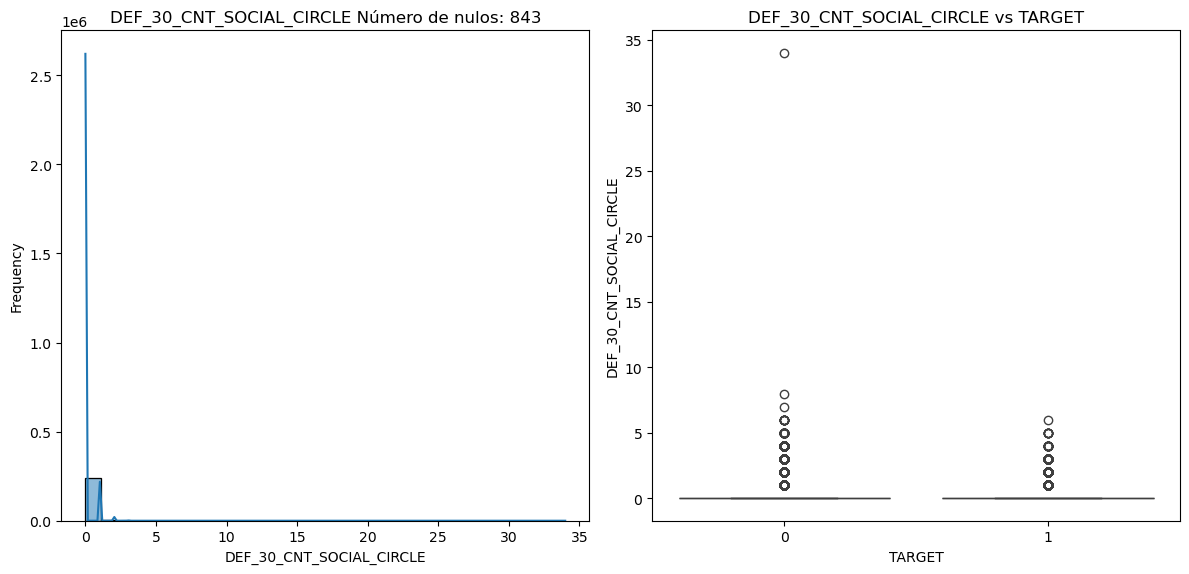

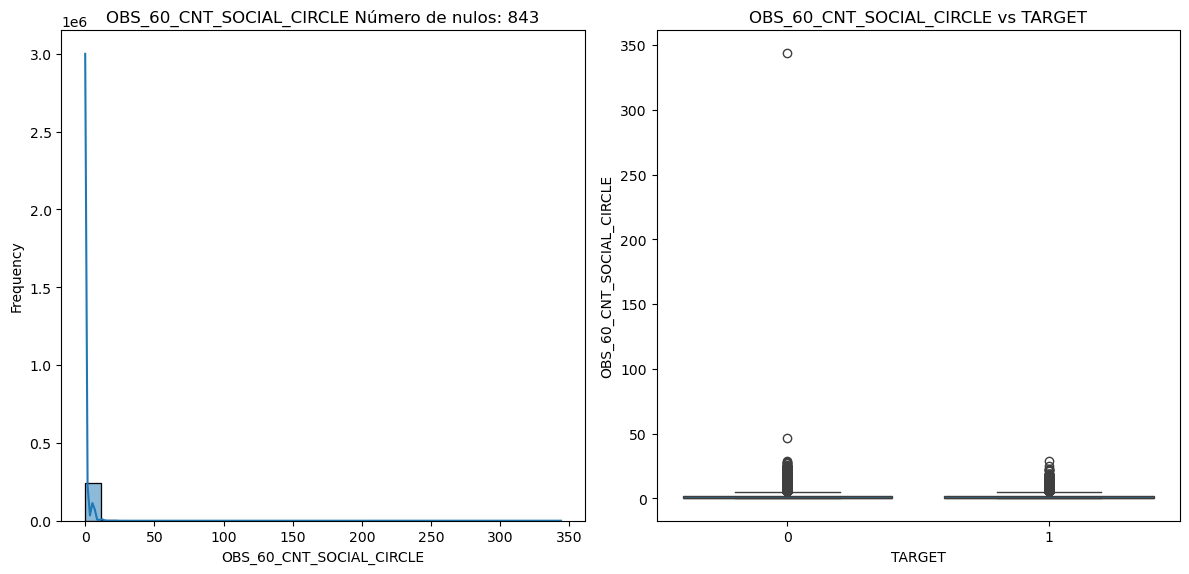

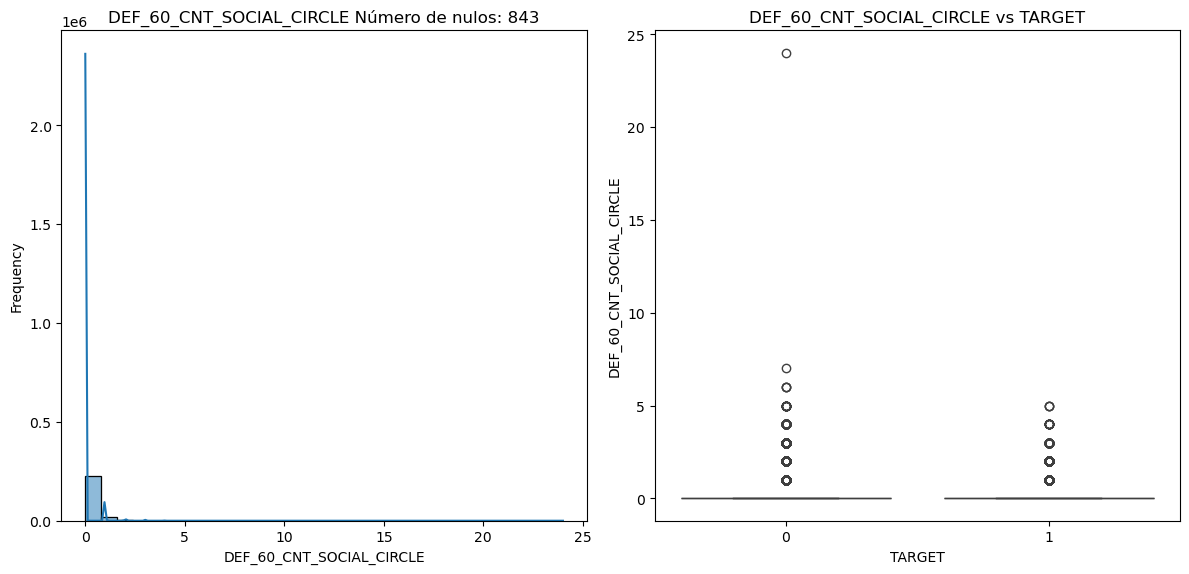

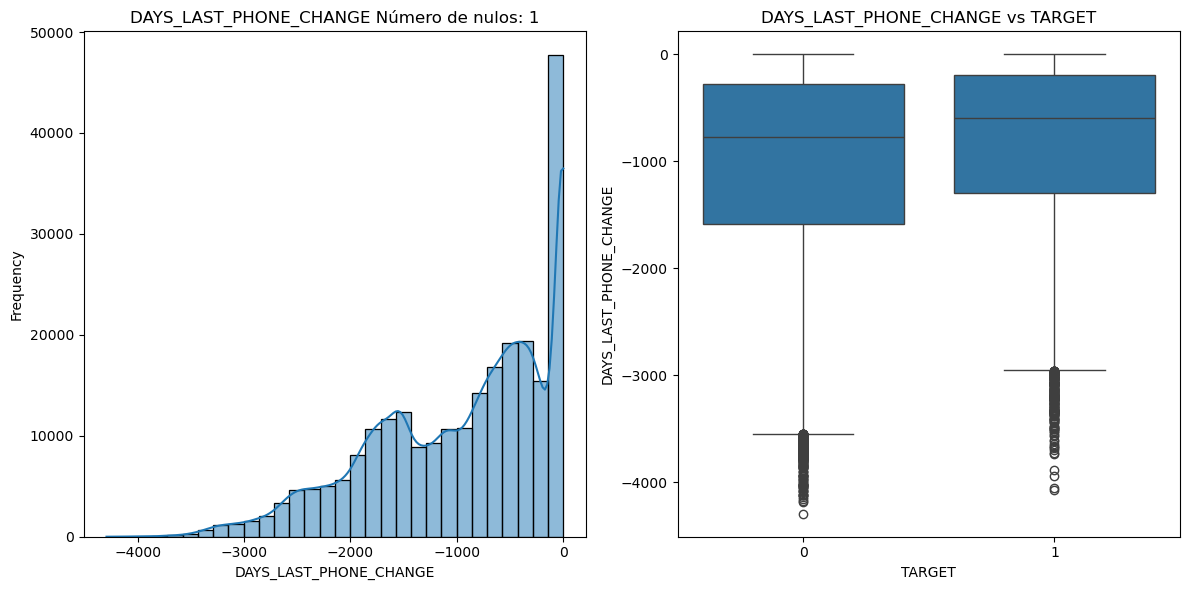

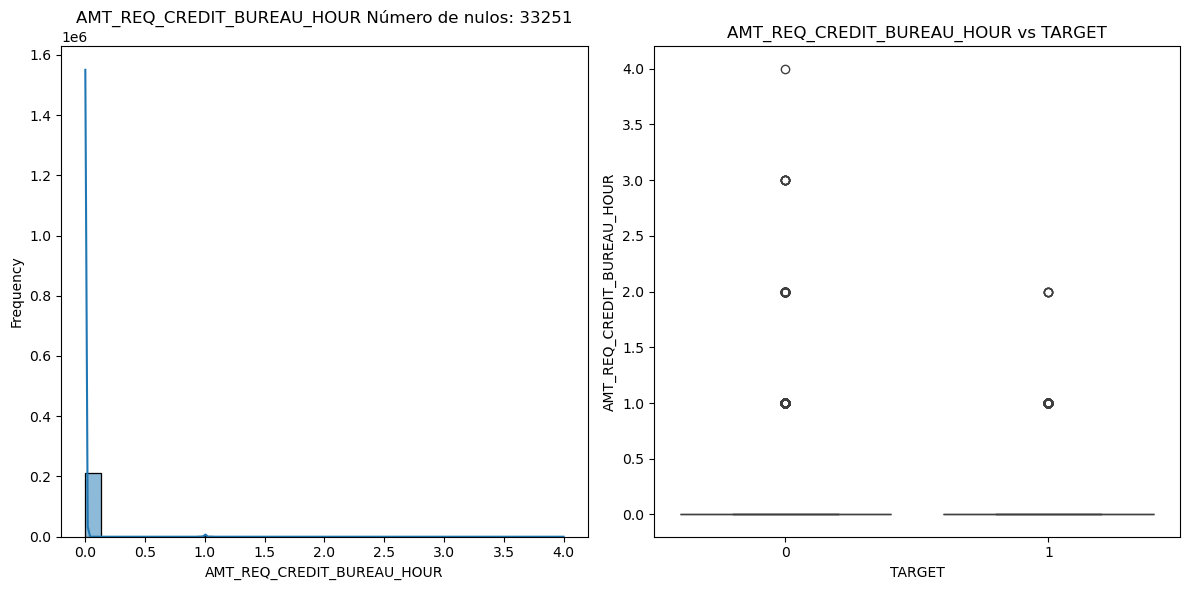

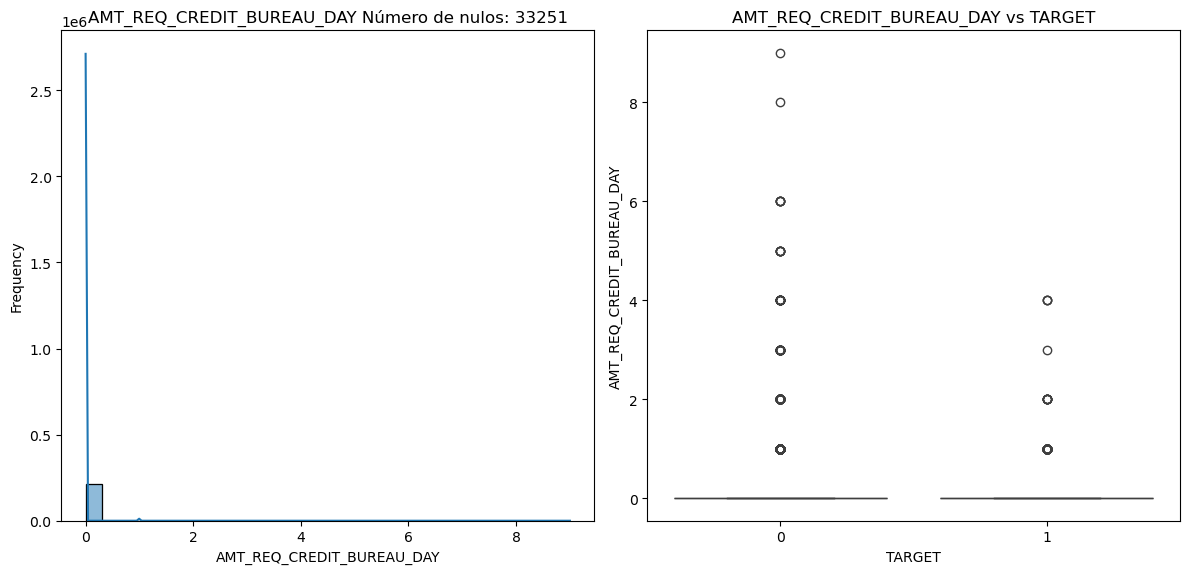

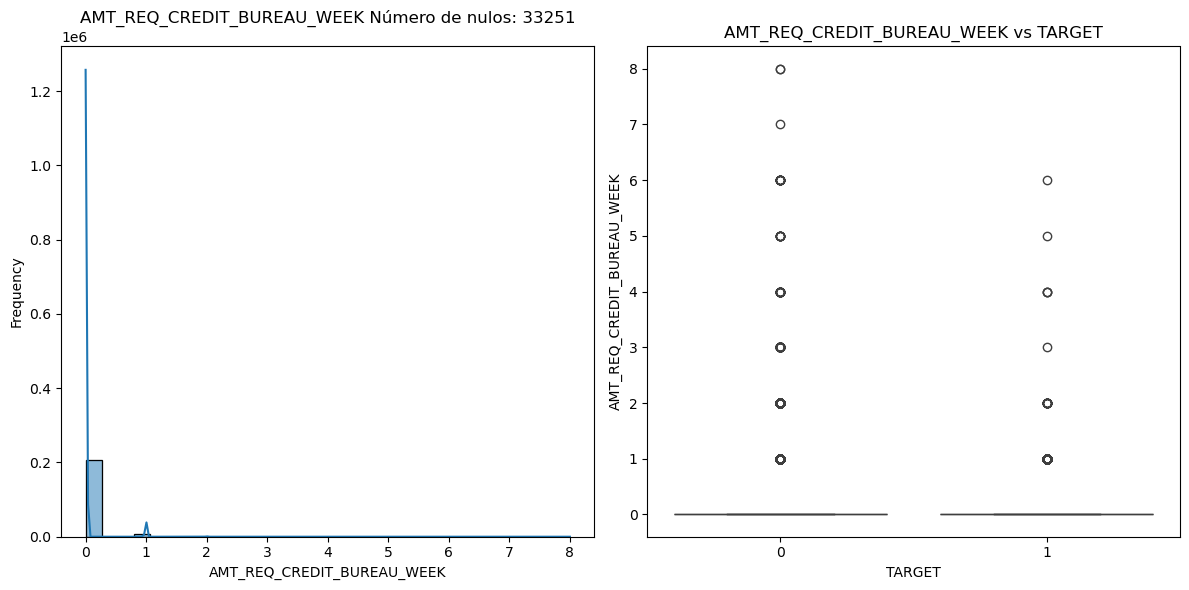

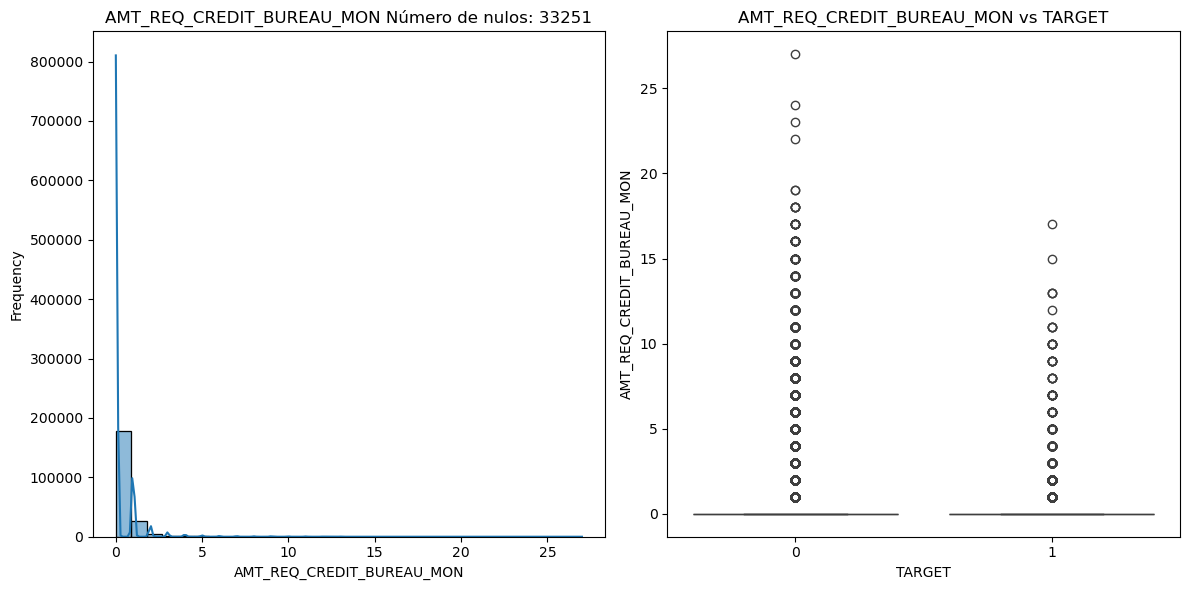

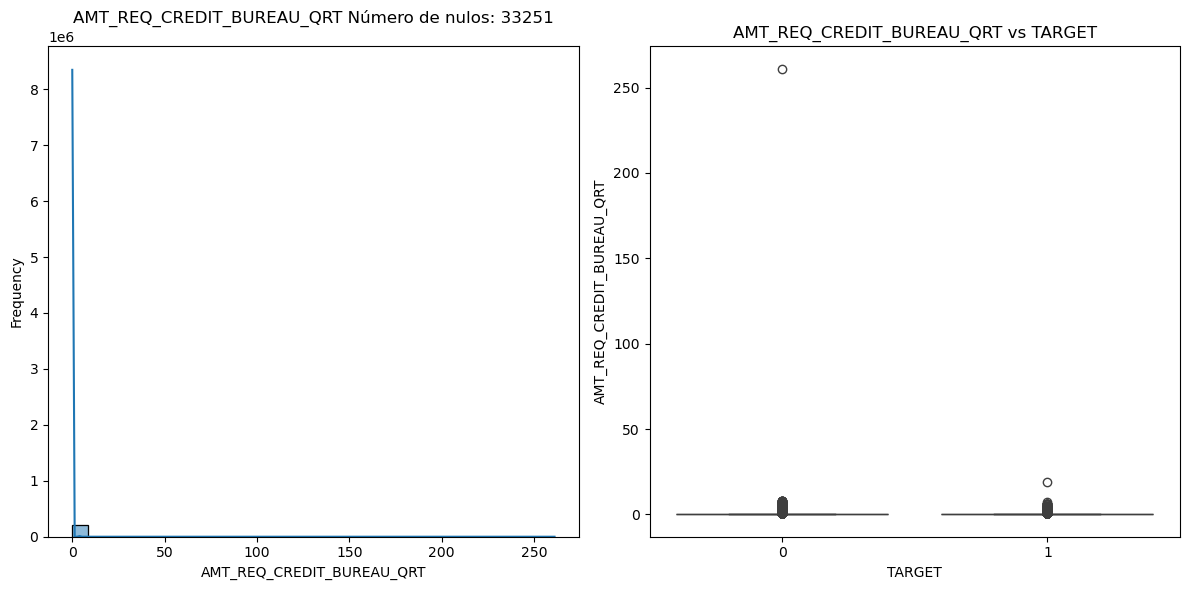

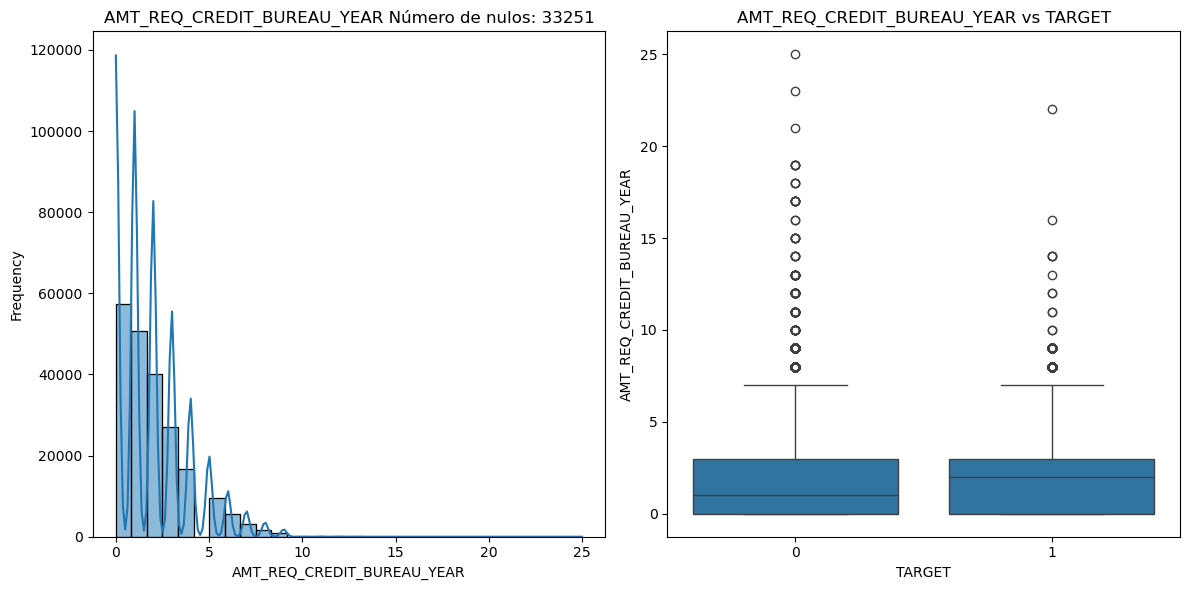

In [20]:
for variable in list_var_continuous:  # Lista de variables continuas
    if variable != "TARGET":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Histograma
        sns.histplot(data=pd_loan_train, x=variable, kde=True, ax=axes[0], bins=30)
        axes[0].set_title(f'{variable} Número de nulos: {pd_loan_train[variable].isna().sum()}')
        axes[0].set_ylabel('Frequency')

        # Boxplot vs TARGET
        sns.boxplot(data=pd_loan_train, x='TARGET', y=variable, ax=axes[1])
        axes[1].set_title(f'{variable} vs TARGET')
        axes[1].set_ylabel(variable)
        axes[1].set_xlabel('TARGET')

        # Ajustar diseño
        plt.tight_layout()
        plt.show()




Una vez realizados los gráficos de las variables continuas con la variable objetivo (TARGET), procederemos a realizar algunos comentarios de algunas variables que puedan influir
en la misma, así como algunas que no sean tan significativas para tener un ejemplo de todo. A continuación, veremos cuáles son las variables elegidas.

OWN_CAR_AGE (Edad del coche propio).
Como vemos en el gráfico de la izquierda, hay un número considerable de valores nulos, concretamente 162.426, lo que indica que muchas personas no poseen automóvil o no hay información a cerca de ellos. Esto se debería gestionar mediante, por ejemplo, con la imputación o creando una categoría específica para los que no tienen automóvil. La mayoría de los coches tienen entre 0 y 20 años, con una concentración importante sobre todo de 0 a 10. No hay casi valores más allá de los 40 años, solo unos pocos datos sobrepasan los 60 años. En cuanto a su relación con TARGET, vemos en los boxplots que no hay grandes diferencias en la mediana ni en el rango intercuartílico para 0 y para 1, lo que nos puede indicar que no el coche propio puede no ser un factor influyente en cuanto a devolver o no el crédito.

EXT_SOURCE_1 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas).
En el gráfico de la izquierda se puede observar que la variable sigue una distribución simétrica con forma similar a una distribución normal. Esta variable tiene una elevada cantidad de valores lo que indica que puede ser útil para discriminar entre distintos tipos de solicitantes. En cuanto a su relación con TARGET, observamos que el boxplot muestra que la mediana para los clientes que no incumplen (TARGET=0) es algo mayor que la de los que sí incumplen (TARGET=1) tienden a tener valores más altos, lo que puede decir que esta variable está asociada con un menor riesgo de incumplimiento.El rango intercuartílico es algo mayor también en los clientes cumplidores que en los que no. Podemos decir que esta variable puede tener un cierto poder predictivo.Los valores altos de EXT_SOURCE_1 se asocian con un menor riesgo de incumplimiento.


CNT_FAM_MEMBERS (Numero de miembros de la familia).
En el gráfico de la izquierda vemos que la variable posee 2 valores nulos, algo que no es significativo dentro del total de datos. En el histograma se muestra que la mayoría de los datos se encuentran entre 2 y 4 miembros, concentrándose sobre todo en 2, sugiriendo que una gran parte de las familias son pequeñas. En relación con TARGET, el boxplot muestra que la distribución es similiar tanto para los cumplidores como para los que no. Tanto la mediana como el rango intercuartílico son iguales, lo que indica que no hay una gran relación con la probabilidad de impago. Hay algunas familias con un número elevado de miembros, aunque no parece que tengan un efecto significativo.


AMT_INCOME_TOTAL (Ingresos totales).
Esta variable no posee valores nulos, por lo que podría ser representativa. En cuanto al histograma, la distribución de la variable está sesgada hacia la izquierda, lo que indica que la mayoría de clientes tienen ingresos bajos. La distribuación de los ingresos para TARGET=0 y TARGET=1 es muy similar, La mediana y el rango intercuartílico son también casi iguales, lo que indica que el nivel de ingresos no tiene una relación directa con la posibilidad de impago.

EXT_SOURCE_2 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas)
En este caso, presenta pocos valores nulos con respecto al total de los datos, aunque se podrían imputar para no perder demasiada información. En el histograma vemos que la mayoría de los valores están concentrados entre 0.4 y 0.8, es decir, sesgados a la derecha, mientras que los valores extremos son menos comunes.En cuanto a su relación con TARGET, vemos que los valores más altos están relacionados con los clientes que no incumplen. La mediana es mas alta para los clientes que no incumplen, lo que un valor más alto de la variable podría estar asociado con un menor riesgo de incumplimiento. El rango intercuartílico es bastante parecido, aunque se observa que los valores bajos se concentran más en los clientes que presentan incumplimiento, por lo que podemos decir que esta variable puede ser un buen predictor.

EXT_SOURCE_3 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas)
Al igual que en las variables anteriores como EXT_SOURCE_1 y EXT_SOURCE_2, prsenta los valores más altos asocidados a clientes que no incumplen el préstamo, lo que indica que valores bajos poseen un mayor riesgo de incumplimiento. Por lo tanto, podemos concluir que la información externa sobre clientes solicitantes de préstamo es una buena variable predictora.



TRATAMIENTO DE VARIABLES CONTINUAS

A continuación se tratarán tres aspectos clave del análisis de los datos: los valores missing, los outliers y las correlaciones entre las variables continuas

In [21]:

list_var_continuous


['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_M

In [22]:
def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función get_deviation_of_mean_perc:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función calcula el porcentaje de valores que se encuentran fuera de un 
        intervalo de confianza, determinado por la media y una desviación estándar 
        multiplicada por un factor (multiplier), para cada variable continua en el 
        DataFrame. Luego, analiza la relación entre estos valores atípicos y la variable 
        objetivo (TARGET), y devuelve un resumen con los porcentajes de valores atípicos 
        y su distribución en relación con la variable objetivo.
        
    - Inputs: 
        - pd_loan (DataFrame): DataFrame que contiene los datos de entrada.
        - list_var_continuous (list): Lista con los nombres de las variables continuas 
          a analizar.
        - target (str): Nombre de la variable objetivo en el DataFrame.
        - multiplier (float): Factor multiplicador para calcular el intervalo de confianza
          (desviación estándar).
        
    - Return:
        - pd_final (DataFrame): DataFrame que contiene el porcentaje de valores atípicos 
          por cada variable continua, su distribución con respecto a la variable objetivo 
          (TARGET), y otros detalles relevantes.
    '''
    
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]

            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

In [23]:
get_deviation_of_mean_perc(pd_loan_train, list_var_continuous, target='TARGET', multiplier=3)

0.0       1.0                      variable  sum_outlier_values  \
0    0.000000  1.000000              AMT_INCOME_TOTAL                2187   
1    0.946502  0.053498              AMT_INCOME_TOTAL                2187   
2    0.000000  1.000000                    AMT_CREDIT                2596   
3    0.957242  0.042758                    AMT_CREDIT                2596   
4    0.000000  1.000000                   AMT_ANNUITY                2356   
5    0.963497  0.036503                   AMT_ANNUITY                2356   
6    0.000000  1.000000               AMT_GOODS_PRICE                3298   
7    0.960279  0.039721               AMT_GOODS_PRICE                3298   
8    0.000000  1.000000    REGION_POPULATION_RELATIVE                6698   
9    0.961033  0.038967    REGION_POPULATION_RELATIVE                6698   
10   0.000000  1.000000             DAYS_REGISTRATION                 608   
11   0.960526  0.039474             DAYS_REGISTRATION                 608   
12   0.000000  1.000000                   OWN_CAR_AGE                2664   
13   0.920420  0.079580                   OWN_CAR_AGE                2664   
14   0.000000  1.000000               CNT_FAM_MEMBERS                3205   
15   0.898284  0.101716               CNT_FAM_MEMBERS                3205   
16   0.000000  1.000000                APARTMENTS_AVG                2345   
17   0.947548  0.052452                APARTMENTS_AVG                2345   
18   0.000000  1.000000              BASEMENTAREA_AVG                1587   
19   0.943289  0.056711              BASEMENTAREA_AVG                1587   
20   0.000000  1.000000   YEARS_BEGINEXPLUATATION_AVG                 553   
21   0.905967  0.094033   YEARS_BEGINEXPLUATATION_AVG                 553   
22   0.000000  1.000000               YEARS_BUILD_AVG                 947   
23   0.927138  0.072862               YEARS_BUILD_AVG                 947   
24   0.000000  1.000000                COMMONAREA_AVG                1364   
25   0.949413  0.050587                COMMONAREA_AVG                1364   
26   0.000000  1.000000                 ELEVATORS_AVG                1899   
27   0.953133  0.046867                 ELEVATORS_AVG                1899   
28   0.000000  1.000000                 ENTRANCES_AVG                1746   
29   0.935281  0.064719                 ENTRANCES_AVG                1746   
30   0.000000  1.000000                 FLOORSMAX_AVG                2051   
31   0.958557  0.041443                 FLOORSMAX_AVG                2051   
32   0.000000  1.000000                 FLOORSMIN_AVG                 474   
33   0.970464  0.029536                 FLOORSMIN_AVG                 474   
34   0.000000  1.000000                  LANDAREA_AVG                1672   
35   0.935407  0.064593                  LANDAREA_AVG                1672   
36   0.000000  1.000000          LIVINGAPARTMENTS_AVG                1376   
37   0.946948  0.053052          LIVINGAPARTMENTS_AVG                1376   
38   0.000000  1.000000                LIVINGAREA_AVG                2534   
39   0.946725  0.053275                LIVINGAREA_AVG                2534   
40   0.000000  1.000000       NONLIVINGAPARTMENTS_AVG                 577   
41   0.925477  0.074523       NONLIVINGAPARTMENTS_AVG                 577   
42   0.000000  1.000000             NONLIVINGAREA_AVG                1907   
43   0.947562  0.052438             NONLIVINGAREA_AVG                1907   
44   0.000000  1.000000               APARTMENTS_MODE                2346   
45   0.945865  0.054135               APARTMENTS_MODE                2346   
46   0.000000  1.000000             BASEMENTAREA_MODE                1648   
47   0.941141  0.058859             BASEMENTAREA_MODE                1648   
48   0.000000  1.000000  YEARS_BEGINEXPLUATATION_MODE                 542   
49   0.904059  0.095941  YEARS_BEGINEXPLUATATION_MODE                 542   
50   0.000000  1.000000              YEARS_BUILD_MODE                 955   
51   0

CORRELACIONES

In [24]:
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    ''''
    ----------------------------------------------------------------------------------------------------------
    Función get_corr_matrix:
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función calcula y visualiza la matriz de correlación entre las variables 
        numéricas de un conjunto de datos. 

    - Inputs: 
        - dataset (DataFrame): Conjunto de datos con las variables numéricas a analizar.
        - metodo (str): Método de correlación a utilizar.
        - size_figure (list): Tamaño de la figura del gráfico.

    - Return:
        - None: Muestra un mapa de calor de la matriz de correlación.
    ----------------------------------------------------------------------------------------------------------
    '''
    
    # Comprobación de que se ha proporcionado el dataset
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    
    # Calcular la matriz de correlación
    corr = dataset.corr(method=metodo) 
    
    # Establecer la autocorrelación a cero para evitar distracciones
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    
    f, ax = plt.subplots(figsize=size_figure)
    
    # Dibujar el mapa de calor con la correlación
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

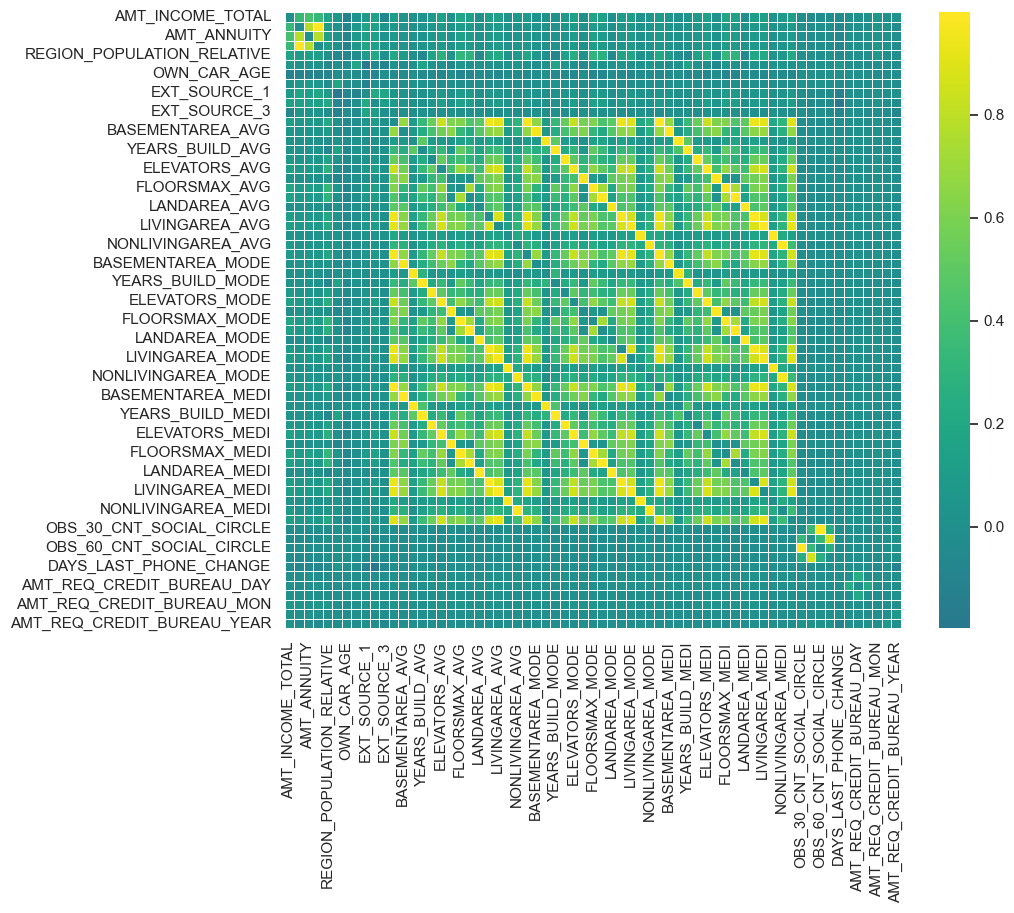

0

In [25]:
get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

En la matriz de correlación se observan varias correlaciones de Pearson cercanas o iguales a 1, lo que indica que algunas variables están perfectamente correlacionadas. Esto puede deberse a la existencia de variables redundantes o derivadas de otras, lo que podría generar problemas de multicolinealidad en modelos estadísticos. Es recomendable revisar estas variables y, en caso de ser necesario, eliminar las que sean idénticas o altamente correlacionadas para evitar distorsiones en los resultados del modelo.

In [26]:
corr = pd_loan_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
3694      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.998514
2744              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998454
3074                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.997279
3008                FLOORSMAX_MEDI                 FLOORSMAX_AVG     0.997015
2942                ENTRANCES_MEDI                 ENTRANCES_AVG     0.996893
2876                ELEVATORS_MEDI                 ELEVATORS_AVG     0.996207
2810               COMMONAREA_MEDI                COMMONAREA_AVG     0.995471
3272               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995280
2546               APARTMENTS_MEDI                APARTMENTS_AVG     0.995117
2612             BASEMENTAREA_MEDI              BASEMENTAREA_AVG     0.994780
3206         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.994544
2678  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.994378
3338      NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.991786
3140                 LANDAREA_MEDI                  LANDAREA_AVG     0.991740
3404            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.990674
2758              YEARS_BUILD_MEDI              YEARS_BUILD_MODE     0.989445
1834              YEARS_BUILD_MODE               YEARS_BUILD_AVG     0.989417
3088                FLOORSMIN_MEDI                FLOORSMIN_MODE     0.988434
3022                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.988090
196                AMT_GOODS_PRICE                    AMT_CREDIT     0.986929
2164                FLOORSMIN_MODE                 FLOORSMIN_AVG     0.985960
2098                FLOORSMAX_MODE                 FLOORSMAX_AVG     0.985577
2890                ELEVATORS_MEDI                ELEVATORS_MODE     0.982941
3154                 LANDAREA_MEDI                 LANDAREA_MODE     0.981883
2956                ENTRANCES_MEDI                ENTRANCES_MODE     0.980671
2824               COMMONAREA_MEDI               COMMONAREA_MODE     0.979752
1966                ELEVATORS_MODE                 ELEVATORS_AVG     0.979015
2032                ENTRANCES_MODE                 ENTRANCES_AVG     0.977723
2626             BASEMENTAREA_MEDI             BASEMENTAREA_MODE     0.977227
2560               APARTMENTS_MEDI               APARTMENTS_MODE     0.976900
1900               COMMONAREA_MODE                COMMONAREA_AVG     0.976325
3352      NONLIVINGAPARTMENTS_MEDI      NONLIVINGAPARTMENTS_MODE     0.975725
2230                 LANDAREA_MODE                  LANDAREA_AVG     0.975100
3418            NONLIVINGAREA_MEDI            NONLIVINGAREA_MODE     0.974836
3220         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.974520
3286               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.974122
1702             BASEMENTAREA_MODE              BASEMENTAREA_AVG     0.973261
1768  YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG     0.973241
1636               APARTMENTS_MODE                APARTMENTS_AVG     0.973040
2362               LIVINGAREA_MODE                LIVINGAREA_AVG     0.971317
2296         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG     0.969774
2428      NONLIVINGAPARTMENTS_MODE       NONLIVINGAPARTMENTS_AVG     0.967589
2494            NONLIVINGAREA_MODE             NONLIVINGAREA_AVG     0.965281
2692  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.964416
1376          LIVINGAPARTMENTS_AVG                APARTMENTS_AVG     0.943325
3224         LIVINGAPARTMENTS_MEDI               APARTMENTS_MEDI     0.941575
3196         LIVINGAPARTMENTS_MEDI                APARTMENTS_AVG     0.940442
2300         LIVINGAPARTMENTS_MODE               APARTMENTS_MODE     0.936308
2556               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.935321
2570               APARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.930829
2286         LIVINGAPARTMENTS_MODE               

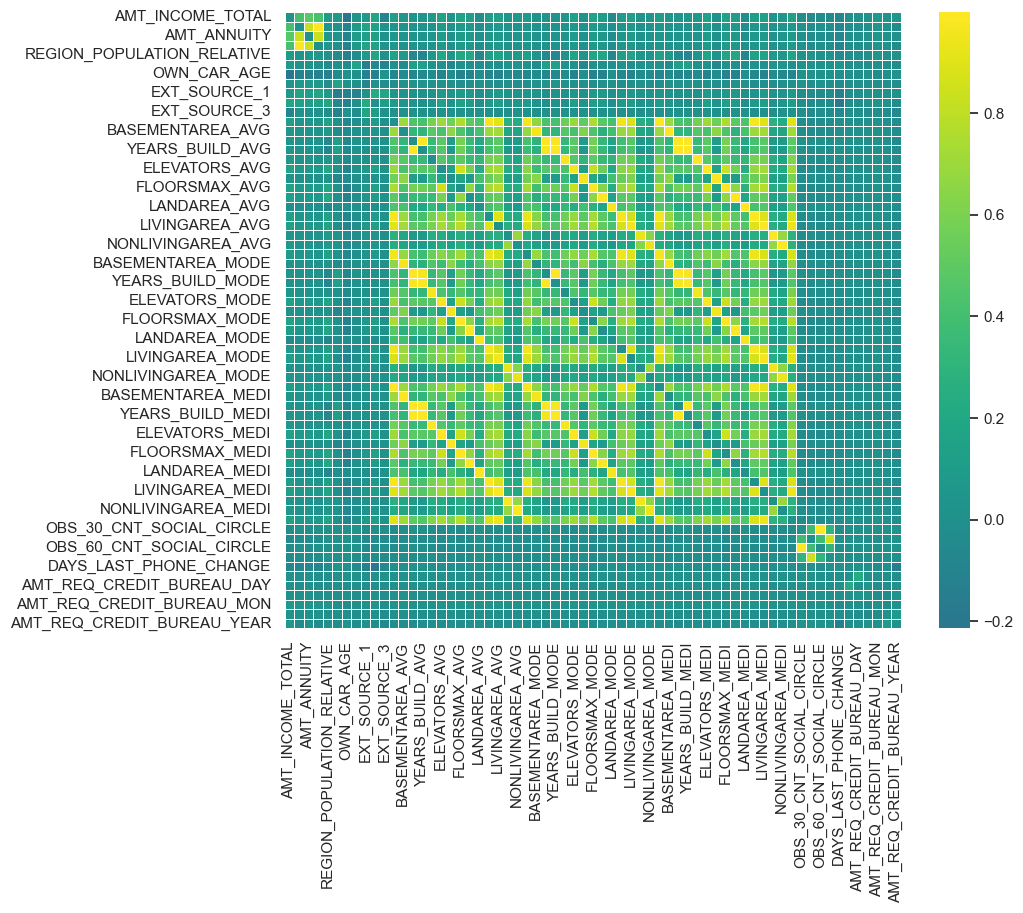

0

In [27]:
get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='spearman', size_figure=[10,8])

También hemos hecho la matriz de spearman. Ambas matrices proporcionan resultados muy parecidos, por lo que llegamos a la conclusión de que es necesario realizar una simplificación de las variables para evitar problemas en el modelado, ya que muchas de nuestras variables no nos están aportando un valor añadido y nos hace el trabajo más complejo.

In [28]:
corr = pd_loan_train[list_var_continuous].corr('spearman')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
2744              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998416
2678  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.997450
3694      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.997376
3140                 LANDAREA_MEDI                  LANDAREA_AVG     0.996411
3074                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.996286
3206         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.996119
2810               COMMONAREA_MEDI                COMMONAREA_AVG     0.995749
3272               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995541
2546               APARTMENTS_MEDI                APARTMENTS_AVG     0.995248
3008                FLOORSMAX_MEDI                 FLOORSMAX_AVG     0.994943
2612             BASEMENTAREA_MEDI              BASEMENTAREA_AVG     0.994792
2942                ENTRANCES_MEDI                 ENTRANCES_AVG     0.993437
2876                ELEVATORS_MEDI                 ELEVATORS_AVG     0.991171
2758              YEARS_BUILD_MEDI              YEARS_BUILD_MODE     0.987994
1834              YEARS_BUILD_MODE               YEARS_BUILD_AVG     0.987693
923                YEARS_BUILD_AVG   YEARS_BEGINEXPLUATATION_AVG     0.986985
3088                FLOORSMIN_MEDI                FLOORSMIN_MODE     0.986387
3022                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.986375
2771              YEARS_BUILD_MEDI  YEARS_BEGINEXPLUATATION_MEDI     0.986048
2692  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.985598
2743              YEARS_BUILD_MEDI   YEARS_BEGINEXPLUATATION_AVG     0.985557
1768  YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG     0.985229
196                AMT_GOODS_PRICE                    AMT_CREDIT     0.984895
2679  YEARS_BEGINEXPLUATATION_MEDI               YEARS_BUILD_AVG     0.984651
2164                FLOORSMIN_MODE                 FLOORSMIN_AVG     0.982697
3338      NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.981757
2098                FLOORSMAX_MODE                 FLOORSMAX_AVG     0.981643
1847              YEARS_BUILD_MODE  YEARS_BEGINEXPLUATATION_MODE     0.980850
3404            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.980823
2890                ELEVATORS_MEDI                ELEVATORS_MODE     0.977978
1833              YEARS_BUILD_MODE   YEARS_BEGINEXPLUATATION_AVG     0.975123
2693  YEARS_BEGINEXPLUATATION_MEDI              YEARS_BUILD_MODE     0.974860
3220         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.973453
1376          LIVINGAPARTMENTS_AVG                APARTMENTS_AVG     0.973382
2824               COMMONAREA_MEDI               COMMONAREA_MODE     0.971104
3154                 LANDAREA_MEDI                 LANDAREA_MODE     0.970817
3224         LIVINGAPARTMENTS_MEDI               APARTMENTS_MEDI     0.970764
2560               APARTMENTS_MEDI               APARTMENTS_MODE     0.969877
2757              YEARS_BUILD_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.969857
1769  YEARS_BEGINEXPLUATATION_MODE               YEARS_BUILD_AVG     0.969559
3196         LIVINGAPARTMENTS_MEDI                APARTMENTS_AVG     0.969534
2296         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG     0.969473
1966                ELEVATORS_MODE                 ELEVATORS_AVG     0.969201
3286               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.969048
2556               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.967592
2230                 LANDAREA_MODE                  LANDAREA_AVG     0.967388
1900               COMMONAREA_MODE                COMMONAREA_AVG     0.965749
2956                ENTRANCES_MEDI                ENTRANCES_MODE     0.965027
1636               APARTMENTS_MODE                APARTMENTS_AVG     0.964807
2362               LIVINGAREA_MODE                LIVINGAREA_AVG     0.964042
2626             BASEMENTAREA_MEDI             BA

TRATAMIENTO DE LOS VALORES NULOS

In [29]:
def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum() > 0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]
                                             .value_counts(normalize=True).reset_index()).T

            # Verifica cuántas columnas tiene pd_concat_percent antes de asignarlas
            if pd_concat_percent.shape[1] >= 2:
                pd_concat_percent.columns = [pd_concat_percent.iloc[0, 0],
                                             pd_concat_percent.iloc[0, 1]]
            elif pd_concat_percent.shape[1] == 1:
                pd_concat_percent.columns = [pd_concat_percent.iloc[0, 0]]

            pd_concat_percent = pd_concat_percent.drop(target, axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum() / pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)

    if pd_final.empty:
        print('No existen variables con valores nulos')

    return pd_final



In [30]:
get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')


0.0                      variable  sum_null_values  \
0   1.000000                   AMT_ANNUITY                9   
1   0.921397               AMT_GOODS_PRICE              229   
2   0.914689                   OWN_CAR_AGE           162464   
3   1.000000               CNT_FAM_MEMBERS                2   
4   0.914966                  EXT_SOURCE_1           138803   
5   0.915709                  EXT_SOURCE_2              522   
6   0.907393                  EXT_SOURCE_3            48787   
7   0.908305                APARTMENTS_AVG           124849   
8   0.910521              BASEMENTAREA_AVG           144000   
9   0.907739   YEARS_BEGINEXPLUATATION_AVG           119997   
10  0.913040               YEARS_BUILD_AVG           163592   
11  0.914218                COMMONAREA_AVG           171913   
12  0.908684                 ELEVATORS_AVG           131073   
13  0.907944                 ENTRANCES_AVG           123816   
14  0.907816                 FLOORSMAX_AVG           122429   
15  0.913647                 FLOORSMIN_AVG           166943   
16  0.911610                  LANDAREA_AVG           146113   
17  0.913778          LIVINGAPARTMENTS_AVG           168206   
18  0.908343                LIVINGAREA_AVG           123471   
19  0.914138       NONLIVINGAPARTMENTS_AVG           170833   
20  0.909499             NONLIVINGAREA_AVG           135755   
21  0.908305               APARTMENTS_MODE           124849   
22  0.910521             BASEMENTAREA_MODE           144000   
23  0.907739  YEARS_BEGINEXPLUATATION_MODE           119997   
24  0.913040              YEARS_BUILD_MODE           163592   
25  0.914218               COMMONAREA_MODE           171913   
26  0.908684                ELEVATORS_MODE           131073   
27  0.907944                ENTRANCES_MODE           123816   
28  0.907816                FLOORSMAX_MODE           122429   
29  0.913647                FLOORSMIN_MODE           166943   
30  0.911610                 LANDAREA_MODE           146113   
31  0.913778         LIVINGAPARTMENTS_MODE           168206   
32  0.908343               LIVINGAREA_MODE           123471   
33  0.914138      NONLIVINGAPARTMENTS_MODE           170833   
34  0.909499            NONLIVINGAREA_MODE           135755   
35  0.908305               APARTMENTS_MEDI           124849   
36  0.910521             BASEMENTAREA_MEDI           144000   
37  0.907739  YEARS_BEGINEXPLUATATION_MEDI           119997   
38  0.913040              YEARS_BUILD_MEDI           163592   
39  0.914218               COMMONAREA_MEDI           171913   
40  0.908684                ELEVATORS_MEDI           131073   
41  0.907944                ENTRANCES_MEDI           123816   
42  0.907816                FLOORSMAX_MEDI           122429   
43  0.913647                FLOORSMIN_MEDI           166943   
44  0.911610                 LANDAREA_MEDI           146113   
45  0.913778         LIVINGAPARTMENTS_MEDI           168206   
46  0.908343               LIVINGAREA_MEDI           123471   
47  0.914138      NONLIVINGAPARTMENTS_MEDI           170833   
48  0.909499            NONLIVINGAREA_MEDI           135755   
49  0.907445                TOTALAREA_MODE           118730   
50  0.965599      OBS_30_CNT_SOCIAL_CIRCLE              843   
51  0.965599      DEF_30_CNT_SOCIAL_CIRCLE              843   
52  0.965599      OBS_60_CNT_SOCIAL_CIRCLE              843   
53  0.965599      DEF_60_CNT_SOCIAL_CIRCLE              843   
54  1.000000        DAYS_LAST_PHONE_CHANGE                1   
55  0.897417    AMT_REQ_CREDIT_BUREAU_HOUR            33251   
56  0.897417     AMT_REQ_CREDIT_BUREAU_DAY            33251   
57  0.897417    AMT_REQ_CREDIT_BUREAU_WEEK            33251   
58  0.897417     AMT_REQ_CREDIT_BUREAU_MON            33251   
59  0.897417     AMT_REQ_CREDIT_BUREAU_QRT            33251   
60  0.897417    AMT_REQ_CREDIT_BUREAU_YEAR            33251   

    porcentaje_sum_null_values       1.0  
0                     0.000037       NaN  
1               

Vamos a cambiar los valores nulos de las columnas continuas por la mediana de los valores no nulos de la columna, se ha elegido la mediana ya que a diferencia de la media (promedio), la mediana no se ve afectada por valores atípicos o extremos en los datos. Al tener un dataset con variables con valores muy extremos (como se puede observar en los gráficos) la mediana es una mejor medida de tendencia central porque representa el punto medio de la distribución.

In [44]:

medianas_train = pd_loan_train[list_var_continuous].median()
pd_loan_train[list_var_continuous] = pd_loan_train[list_var_continuous].fillna(medianas_train)
pd_loan_test[list_var_continuous] = pd_loan_test[list_var_continuous].fillna(medianas_train)

Comprobamos que n existen valores nulos en las columnas

In [47]:
get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')

No existen variables con valores nulos


Empty DataFrame
Columns: []
Index: []

TRATAMIENTO VARIABLES CATEGORICAS

In [48]:
list_var_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [50]:
from scipy.stats import chi2_contingency
def cramers_v(matrix):
    chi2, p, dof, ex = chi2_contingency(matrix)  # Chi-squared test
    return np.sqrt(chi2 / (matrix.sum().sum() * (min(matrix.shape) - 1)))

cramers_v_results = {}

for col in list_var_cat:
    # Calculamos la matriz de confusión entre las variable categórica y TARGET
    confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train[col])
    
    # Calculamos el Cramér's V para esta matriz
    cramers_v_value = cramers_v(confusion_matrix.values)
    
    # Guardamos el resultado en el diccionario
    cramers_v_results[col] = cramers_v_value

cramers_v_df = pd.DataFrame(list(cramers_v_results.items()), columns=['Variable', 'Cramér\'s V'])
cramers_v_df = cramers_v_df.sort_values(by='Cramér\'s V', ascending=False)

print(cramers_v_df)

                      Variable  Cramér's V
9              OCCUPATION_TYPE    0.078551
11           ORGANIZATION_TYPE    0.072094
5             NAME_INCOME_TYPE    0.063683
6          NAME_EDUCATION_TYPE    0.057060
1                  CODE_GENDER    0.055116
14          WALLSMATERIAL_MODE    0.045075
15         EMERGENCYSTATE_MODE    0.043118
13              HOUSETYPE_MODE    0.041642
7           NAME_FAMILY_STATUS    0.040930
8            NAME_HOUSING_TYPE    0.038018
0           NAME_CONTRACT_TYPE    0.031849
12          FONDKAPREMONT_MODE    0.031243
2                 FLAG_OWN_CAR    0.023452
4              NAME_TYPE_SUITE    0.012199
10  WEEKDAY_APPR_PROCESS_START    0.006439
3              FLAG_OWN_REALTY    0.006397


OPCIÓN 2

In [51]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

TARGET       0      1
TARGET               
0       226148      0
1            0  19860


0.9999726128248573

In [52]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
cramers_v(confusion_matrix.values)

0.9999726128248573

In [53]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["OWN_CAR_AGE"])
cramers_v(confusion_matrix.values)

0.04159556349977331

In [54]:
pd_loan_train[list_var_cat] = pd_loan_train[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")
pd_loan_test[list_var_cat] = pd_loan_test[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")

print(pd_loan_test)

           NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
SK_ID_CURR                                                               
344817             Cash loans           F            N               Y   
304895             Cash loans           M            N               Y   
274533             Cash loans           F            N               Y   
416053             Cash loans           M            Y               Y   
328656             Cash loans           F            N               Y   
...                       ...         ...          ...             ...   
314339             Cash loans           F            N               Y   
107600             Cash loans           F            N               Y   
342675             Cash loans           F            Y               N   
109967             Cash loans           M            N               Y   
326396             Cash loans           F            N               N   

            CNT_CHILDREN  AMT_INCOME_

In [56]:
pd_loan_train.isna().sum().sum()

0

In [57]:
pd_loan_train.to_csv("../data/train_pd_data_preprocessing_missing_outlier.csv")
pd_loan_test.to_csv("../data/test_pd_data_preprocessing_missing_outlier.csv")